In [ ]:
# ✅ Step 1: Install Required Libraries
!pip install transformers pandas tqdm -q


In [ ]:
# ✅ Step 2: Import Libraries
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import re
from datasets import Dataset
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import pandas as pd
from torch.nn.functional import softmax
from tqdm import tqdm



In [ ]:
# ✅ Step 3: Load Your Dataset
#df = pd.read_csv("your_file.csv")  # Replace with actual file
df=pd.read_csv("/content/drive/MyDrive/all_english_labeled_news.csv")
df = df.dropna(subset=["text"])
df = df.reset_index(drop=True)
df["text"] = df["text"].str[:512]
dataset = Dataset.from_pandas(df)


In [ ]:
# ✅ Step 4: Define Moral Foundations
labels = [
    "Care", "Harm", "Fairness", "Cheating",
    "Loyalty", "Betrayal", "Authority", "Subversion",
    "Sanctity", "Degradation", "Liberty", "Oppression"
]
def make_hypotheses(label_list):
    return [f"This text expresses {label}." for label in label_list]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "facebook/bart-large-mnli"  # Can replace with smaller NLI model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)


In [ ]:
def classify_batch_manual(batch_texts, batch_size=32):
    all_results = []

    for i in tqdm(range(0, len(batch_texts), batch_size)):
        texts = batch_texts[i:i+batch_size]
        batch_out = []

        for text in texts:
            hypotheses = make_hypotheses(labels)
            premise_list = [text] * len(hypotheses)

            # Tokenize and move to GPU
            inputs = tokenizer(premise_list, hypotheses, padding=True, truncation=True, return_tensors="pt").to(device)
            with torch.no_grad():
                logits = model(**inputs).logits
            probs = softmax(logits, dim=1)[:, 2]  # Class 2 = entailment

            # Store label + score
            label_scores = [(label, float(score)) for label, score in zip(labels, probs) if score > 0.5]
            batch_out.append(label_scores if label_scores else [("None", 1.0)])

        all_results.extend(batch_out)

    return all_results


In [ ]:
results = classify_batch_manual(df["Details"].tolist(), batch_size=32)
df["moral_foundations"] = [[label for label, score in r] for r in results]
df["moral_scores"] = [dict(r) for r in results]


  1%|          | 9/1180 [05:23<11:40:41, 35.90s/it]


KeyboardInterrupt: 

In [ ]:
# ✅ Step 1: Install required libraries
!pip install transformers datasets nltk -q

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from torch.nn.functional import softmax
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import nltk
nltk.download("punkt")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# ✅ Step 2: Load and preprocess your data
df = pd.read_csv("/content/drive/MyDrive/all_english_labeled_news.csv")
df=df.iloc[0:12000]
df = df.dropna(subset=["text"]).reset_index(drop=True)

from transformers import AutoTokenizer

# Load tokenizer first
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Function to truncate text to 512 tokens (word-level)
def truncate_to_512_tokens(text):
    encoded = tokenizer.encode(text, max_length=512, truncation=True)
    return tokenizer.decode(encoded, skip_special_tokens=True)

# Apply token-level truncation to "Details" column
df["text"] = df["text"].apply(lambda x: truncate_to_512_tokens(str(x)))

# Truncate each article to top 3 sentences for speed
#df["text"] = df["text"].str[:512]

# Remove short or empty entries
df = df[df["text"].str.len() > 30].reset_index(drop=True)


In [ ]:
# ✅ Step 3: Load the fast model and tokenizer
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)


In [ ]:
# ✅ Step 4: Define labels and helper function
labels = [
    "Care", "Harm", "Fairness", "Cheating",
    "Loyalty", "Betrayal", "Authority", "Subversion",
    "Sanctity", "Degradation", "Liberty", "Oppression"
]

def make_hypotheses(label_list):
    return [f"This text expresses {label}." for label in label_list]

def classify_batch_manual(batch_texts, batch_size=32):
    all_results = []

    for i in tqdm(range(0, len(batch_texts), batch_size)):
        texts = batch_texts[i:i+batch_size]
        batch_out = []

        for text in texts:
            hypotheses = make_hypotheses(labels)
            premise_list = [text] * len(hypotheses)

            # Tokenize and run inference on GPU
            inputs = tokenizer(premise_list, hypotheses, padding=True, truncation=True, return_tensors="pt").to(device)
            with torch.no_grad():
                logits = model(**inputs).logits
            probs = softmax(logits, dim=1)[:, 2]  # Class 2 = entailment

            label_scores = [(label, float(score)) for label, score in zip(labels, probs) if score > 0.5]
            batch_out.append(label_scores if label_scores else [("None", 1.0)])

        all_results.extend(batch_out)

    return all_results


In [ ]:
# ✅ Step 5: Run the model on all rows and save
results = classify_batch_manual(df["text"].tolist(), batch_size=32)

# Extract just the labels and full score dictionaries
df["moral_foundations"] = [[label for label, score in r] for r in results]
df["moral_scores"] = [dict(r) for r in results]

# ✅ Save to CSV
#df.to_csv("/content/drive/MyDrive/moral_foundation_labeled_fast.csv", index=False)
#print("✅ Done! Output saved to: moral_foundation_labeled_fast.csv")


100%|██████████| 375/375 [1:16:15<00:00, 12.20s/it]


In [ ]:
df.to_csv("/content/drive/MyDrive/moral_foundation_labeled_fast.csv", index=False)

In [ ]:
import os
os.kill(os.getpid(), 9)


In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/all_english_moral_foundation_labeled_bart_with_top_moral.csv")
df

,Unnamed: 0,Date,Title,Link,Details,newspaper_name,text,sentiment,emotion,top_2_moral_foundations,top_2_moral_scores
0,0,2024-09-24,Ex-IGP Mamun on 4-day remand in murder case,https://www.thedailystar.net/news/bangladesh/c...,A Dhaka court today placed former inspector ge...,The Daily Star,Ex-IGP Mamun on 4-day remand in murder case. A...,LABEL_0,anger,"['Authority', 'Care']","{'Authority': 0.7845588326454163, 'Care': 0.64..."
1,1,2024-09-24,"Touhid, Jaishankar meet at UNGA, discuss mutua...",https://www.thedailystar.net/news/bangladesh/d...,"Foreign Affairs Adviser, HE Md. Touhid Hossai...",The Daily Star,"Touhid, Jaishankar meet at UNGA, discuss mutua...",LABEL_1,fear,"['Authority', 'Loyalty']","{'Authority': 0.8064534068107605, 'Loyalty': 0..."
2,2,2024-09-24,Army chief pledges support for Yunus' interim ...,https://www.thedailystar.net/news/bangladesh/n...,Bangladesh's army chief vowed to back the coun...,The Daily Star,Army chief pledges support for Yunus' interim ...,LABEL_1,anger,"['Subversion', 'Oppression']","{'Subversion': 0.9299159646034241, 'Oppression..."
3,3,2024-09-24,Released top criminals at it again,https://www.thedailystar.net/news/bangladesh/c...,"Nasir Biswas, a 26-year-old mason, was walking...",The Daily Star,Released top criminals at it again. Nasir Bisw...,LABEL_1,anger,"['Sanctity', 'Subversion']","{'Sanctity': 0.8243871927261353, 'Subversion':..."
4,4,2024-09-24,Shibir now out into the open at DU,https://www.thedailystar.net/campus/news/shibi...,"After around three and a half decades, Islami ...",The Daily Star,Shibir now out into the open at DU. After arou...,LABEL_1,disgust,"['Sanctity', 'Cheating']","{'Sanctity': 0.8725903630256653, 'Cheating': 0..."
...,...,...,...,...,...,...,...,...,...,...,...
37552,37552,2024-10-05,India foreign minister to visit Pakistan in ra...,https://en.prothomalo.com/international/india/...,India's foreign minister will be in Pakistan l...,Prothom Alo,India foreign minister to visit Pakistan in ra...,LABEL_1,neutral,"['Authority', 'Care']","{'Authority': 0.7862706184387207, 'Care': 0.57..."
37553,37553,2024-10-05,Initiative to reform Shilpakala Academy Act,https://en.prothomalo.com/entertainment/tkx9v6...,An initiative has been taken to reform Banglad...,Prothom Alo,Initiative to reform Shilpakala Academy Act. A...,LABEL_1,neutral,"['Authority', 'Care']","{'Authority': 0.8890504837036133, 'Care': 0.70..."
37554,37554,2024-10-05,India bemoan 'harsh' T20 World Cup run-out row,https://en.prothomalo.com/sports/cricket/xzyc3...,India star Jemimah Rodrigues described a run-o...,Prothom Alo,India bemoan 'harsh' T20 World Cup run-out row...,LABEL_1,disgust,"['Harm', 'Care']","{'Harm': 0.9209035634994507, 'Care': 0.8041914..."
37555,37555,2024-10-05,Reform commissions likely to start operations ...,https://en.prothomalo.com/bangladesh/op5bwbj4iz,Although the notification regarding the five o...,Prothom Alo,Reform commissions likely to start operations ...,LABEL_1,neutral,"['Authority', 'Loyalty']","{'Authority': 0.800456702709198, 'Loyalty': 0...."


In [ ]:
df.groupby('emotion').size()

,0
emotion,
anger,8469
disgust,1651
fear,4485
joy,4213
neutral,13130
sadness,5341
surprise,248


In [ ]:
# prompt: emotion group that are count less than 10 remove them from the data set

# Identify emotion groups with counts less than 10
emotion_counts = df.groupby('emotion').size()
emotions_to_remove = emotion_counts[emotion_counts < 10].index.tolist()

# Remove rows where the 'emotion' is in the list of emotions to remove
df_filtered = df[~df['emotion'].isin(emotions_to_remove)].reset_index(drop=True)

# Display the new counts to verify
print("Counts after removing low-count emotion groups:")
print(df_filtered.groupby('emotion').size())

# Update the original DataFrame reference if you want to work with the filtered data
df = df_filtered

Counts after removing low-count emotion groups:
emotion
anger        8469
disgust      1651
fear         4485
joy          4213
neutral     13130
sadness      5341
surprise      248
dtype: int64


In [ ]:
df.to_csv("/content/drive/MyDrive/all_english_moral_foundation_labeled_bart_with_top_moral.csv")

/tmp/ipython-input-2-1850293196.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["emotion"] = df["emotion"].astype(str).str.strip()
/tmp/ipython-input-2-1850293196.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["top_2_moral_foundations"] = df["top_2_moral_foundations"].astype(str).str.strip()
/tmp/ipython-input-2-1850293196.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

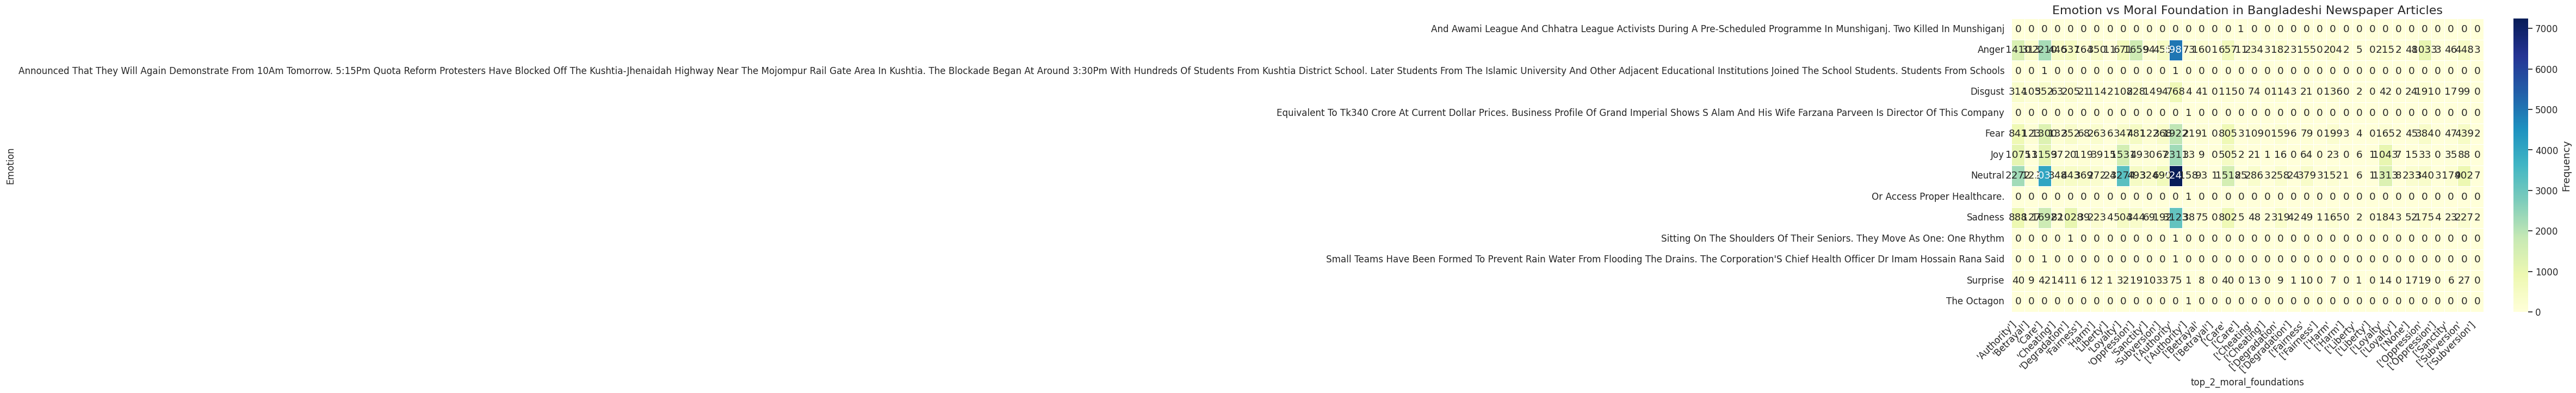

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
  # replace with your actual path if needed

# Drop rows with missing required fields
df = df.dropna(subset=["emotion", "top_2_moral_foundations"])

# Ensure all values are strings and strip any whitespace
df["emotion"] = df["emotion"].astype(str).str.strip()
df["top_2_moral_foundations"] = df["top_2_moral_foundations"].astype(str).str.strip()

# Split multi-label moral_foundation into lists
df["top_2_moral_foundations"] = df["top_2_moral_foundations"].str.split(",\s*")

# Explode to create one row per foundation-emotion pair
df_exploded = df.explode("top_2_moral_foundations")

# Optional: normalize inconsistent labels (capitalize, strip)
df_exploded["top_2_moral_foundations"] = df_exploded["top_2_moral_foundations"].str.strip().str.title()
df_exploded["emotion"] = df_exploded["emotion"].str.strip().str.title()

# Count co-occurrences
heatmap_data = df_exploded.groupby(["emotion", "top_2_moral_foundations"]).size().unstack(fill_value=0)

# Sort axes for cleaner visualization
heatmap_data = heatmap_data.loc[sorted(heatmap_data.index), sorted(heatmap_data.columns)]

# Plot heatmap
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid", font_scale=1.1)
ax = sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Frequency"})

# Labeling
plt.title("Emotion vs Moral Foundation in Bangladeshi Newspaper Articles", fontsize=16)
plt.xlabel("top_2_moral_foundations", fontsize=12)
plt.ylabel("Emotion", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/all_english_labeled_news.csv")
df

,Unnamed: 0,Date,Title,Link,Details,newspaper_name,text,sentiment,emotion,moral_foundation
0,1,2024-09-24,Ex-IGP Mamun on 4-day remand in murder case,https://www.thedailystar.net/news/bangladesh/c...,A Dhaka court today placed former inspector ge...,The Daily Star,Ex-IGP Mamun on 4-day remand in murder case. A...,LABEL_0,anger,"Liberty/Oppression, Authority/Subversion, Care..."
1,2,2024-09-24,"Touhid, Jaishankar meet at UNGA, discuss mutua...",https://www.thedailystar.net/news/bangladesh/d...,"Foreign Affairs Adviser, HE Md. Touhid Hossai...",The Daily Star,"Touhid, Jaishankar meet at UNGA, discuss mutua...",LABEL_1,fear,Care/Harm
2,3,2024-09-24,Army chief pledges support for Yunus' interim ...,https://www.thedailystar.net/news/bangladesh/n...,Bangladesh's army chief vowed to back the coun...,The Daily Star,Army chief pledges support for Yunus' interim ...,LABEL_1,anger,"Fairness/Cheating, Care/Harm, Authority/Subver..."
3,4,2024-09-24,Released top criminals at it again,https://www.thedailystar.net/news/bangladesh/c...,"Nasir Biswas, a 26-year-old mason, was walking...",The Daily Star,Released top criminals at it again. Nasir Bisw...,LABEL_1,anger,"Care/Harm, Authority/Subversion, Loyalty/Betra..."
4,5,2024-09-24,Shibir now out into the open at DU,https://www.thedailystar.net/campus/news/shibi...,"After around three and a half decades, Islami ...",The Daily Star,Shibir now out into the open at DU. After arou...,LABEL_1,disgust,"Care/Harm, Authority/Subversion, Sanctity/Degr..."
...,...,...,...,...,...,...,...,...,...,...
37749,139942,2024-10-16,World Cup qualifierVintage Messi nets hat tric...,https://en.prothomalo.com/sports/football/c0gc...,Lionel Messi struck a vintage hat trick as wor...,Prothom Alo,World Cup qualifierVintage Messi nets hat tric...,LABEL_1,fear,Fairness/Cheating
37750,139943,2024-10-16,Netanyahu vows ‘no ceasefire’ in Lebanon after...,https://en.prothomalo.com/international/middle...,Israeli prime minister Benjamin Netanyahu reje...,Prothom Alo,Netanyahu vows ‘no ceasefire’ in Lebanon after...,LABEL_0,fear,"Sanctity/Degradation, Liberty/Oppression, Auth..."
37751,139944,2024-10-16,Italy transfers migrants including Bangladeshi...,https://en.prothomalo.com/bangladesh/qlek3uucey,Italian prime minister Giorgia Meloni on Tuesd...,Prothom Alo,Italy transfers migrants including Bangladeshi...,LABEL_1,neutral,"Fairness/Cheating, Loyalty/Betrayal, Care/Harm..."
37752,139945,2024-10-16,OpinionWhy gender-based violence is worth disc...,https://en.prothomalo.com/opinion/op-ed/xkaaeq...,"Growing up, I often witnessed misogynistic nar...",Prothom Alo,OpinionWhy gender-based violence is worth disc...,LABEL_0,anger,"Care/Harm, Authority/Subversion, Loyalty/Betra..."


In [ ]:
!pip install transformers datasets nltk -q

# ✅ Step 2: Import libraries
import pandas as pd
import torch
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# ✅ Step 1: Install dependencies


# ✅ Step 3: Load dataset
df = pd.read_csv("/content/drive/MyDrive/all_english_labeled_news.csv")
df=df.iloc[0:8000]
df = df.dropna(subset=["text"]).reset_index(drop=True)

# ✅ Step 4: Load model and tokenizer (facebook/bart-large-mnli)
model_name = "facebook/bart-large-mnli"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

# ✅ Step 5: Truncate to 512 tokens
def truncate_to_512_tokens(text):
    encoded = tokenizer.encode(text, max_length=512, truncation=True)
    return tokenizer.decode(encoded, skip_special_tokens=True)

df["text"] = df["text"].apply(lambda x: truncate_to_512_tokens(str(x)))
df = df[df["text"].str.len() > 30].reset_index(drop=True)

# ✅ Step 6: Moral foundations and hypothesis builder
labels = [
    "Care", "Harm", "Fairness", "Cheating",
    "Loyalty", "Betrayal", "Authority", "Subversion",
    "Sanctity", "Degradation", "Liberty", "Oppression"
]

def make_hypotheses(label_list):
    return [f"This text expresses {label}." for label in label_list]

# ✅ Step 7: Batched classification with progress and timing
def classify_batch_manual(batch_texts, batch_size=16):
    all_results = []
    total = len(batch_texts)
    start_time = time.time()

    for i in tqdm(range(0, total, batch_size)):
        texts = batch_texts[i:i+batch_size]
        batch_out = []

        for text in texts:
            hypotheses = make_hypotheses(labels)
            premise_list = [text] * len(hypotheses)
            inputs = tokenizer(premise_list, hypotheses, padding=True, truncation=True, return_tensors="pt").to(device)

            with torch.no_grad():
                logits = model(**inputs).logits
            probs = softmax(logits, dim=1)[:, 2]  # entailment

            label_scores = [(label, float(score)) for label, score in zip(labels, probs) if score > 0.5]
            batch_out.append(label_scores if label_scores else [("None", 1.0)])

        all_results.extend(batch_out)

        # ⏱ ETA
        elapsed = time.time() - start_time
        avg_time = elapsed / (i + batch_size)
        remaining = avg_time * (total - (i + batch_size))
        print(f"\n⏳ ETA: {remaining/60:.1f} min remaining\n")

    return all_results

# ✅ Step 8: Run classification
results = classify_batch_manual(df["Details"].tolist(), batch_size=16)

# ✅ Step 9: Store results
df["moral_foundations"] = [[label for label, score in r] for r in results]
df["moral_scores"] = [dict(r) for r in results]

# ✅ Step 10: Save to CSV
output_path = "/content/drive/MyDrive/moral_foundation_labeled_bart.csv"
df.to_csv(output_path, index=False)
print(f"✅ Done! File saved to: {output_path}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

  0%|          | 1/500 [00:19<2:41:21, 19.40s/it]


⏳ ETA: 161.4 min remaining



  0%|          | 2/500 [00:38<2:40:20, 19.32s/it]


⏳ ETA: 160.5 min remaining



  1%|          | 3/500 [00:51<2:14:38, 16.25s/it]


⏳ ETA: 141.6 min remaining



  1%|          | 4/500 [01:01<1:55:06, 13.92s/it]


⏳ ETA: 127.4 min remaining



  1%|          | 5/500 [01:21<2:13:38, 16.20s/it]


⏳ ETA: 135.1 min remaining



  1%|          | 6/500 [01:37<2:11:47, 16.01s/it]


⏳ ETA: 133.8 min remaining



  1%|▏         | 7/500 [01:48<1:57:27, 14.30s/it]


⏳ ETA: 127.1 min remaining



  2%|▏         | 8/500 [02:00<1:51:05, 13.55s/it]


⏳ ETA: 123.2 min remaining



  2%|▏         | 9/500 [02:20<2:08:07, 15.66s/it]


⏳ ETA: 127.8 min remaining



  2%|▏         | 10/500 [02:41<2:20:33, 17.21s/it]


⏳ ETA: 131.6 min remaining



  2%|▏         | 11/500 [02:58<2:21:44, 17.39s/it]


⏳ ETA: 132.6 min remaining



  2%|▏         | 12/500 [03:11<2:10:17, 16.02s/it]


⏳ ETA: 130.0 min remaining



  3%|▎         | 13/500 [03:30<2:17:10, 16.90s/it]


⏳ ETA: 131.6 min remaining



  3%|▎         | 14/500 [03:53<2:29:58, 18.51s/it]


⏳ ETA: 134.8 min remaining



  3%|▎         | 15/500 [04:09<2:23:38, 17.77s/it]


⏳ ETA: 134.2 min remaining



  3%|▎         | 16/500 [04:29<2:30:48, 18.70s/it]


⏳ ETA: 136.1 min remaining



  3%|▎         | 17/500 [04:46<2:24:16, 17.92s/it]


⏳ ETA: 135.5 min remaining



  4%|▎         | 18/500 [04:56<2:06:18, 15.72s/it]


⏳ ETA: 132.4 min remaining



  4%|▍         | 19/500 [05:12<2:06:45, 15.81s/it]


⏳ ETA: 131.9 min remaining



  4%|▍         | 20/500 [05:26<2:01:25, 15.18s/it]


⏳ ETA: 130.6 min remaining



  4%|▍         | 21/500 [05:48<2:17:52, 17.27s/it]


⏳ ETA: 132.5 min remaining



  4%|▍         | 22/500 [06:04<2:15:33, 17.01s/it]


⏳ ETA: 132.2 min remaining



  5%|▍         | 23/500 [06:16<2:02:46, 15.44s/it]


⏳ ETA: 130.2 min remaining



  5%|▍         | 24/500 [06:35<2:11:21, 16.56s/it]


⏳ ETA: 130.9 min remaining



  5%|▌         | 25/500 [06:55<2:18:20, 17.48s/it]


⏳ ETA: 131.6 min remaining



  5%|▌         | 26/500 [07:13<2:18:43, 17.56s/it]


⏳ ETA: 131.6 min remaining



  5%|▌         | 27/500 [07:27<2:09:58, 16.49s/it]


⏳ ETA: 130.6 min remaining



  6%|▌         | 28/500 [07:44<2:10:59, 16.65s/it]


⏳ ETA: 130.4 min remaining



  6%|▌         | 29/500 [08:09<2:31:18, 19.27s/it]


⏳ ETA: 132.5 min remaining



  6%|▌         | 30/500 [08:26<2:25:11, 18.54s/it]


⏳ ETA: 132.2 min remaining



  6%|▌         | 31/500 [08:39<2:11:36, 16.84s/it]


⏳ ETA: 131.0 min remaining



  6%|▋         | 32/500 [08:56<2:11:29, 16.86s/it]


⏳ ETA: 130.7 min remaining



  7%|▋         | 33/500 [09:17<2:21:28, 18.18s/it]


⏳ ETA: 131.5 min remaining



  7%|▋         | 34/500 [09:33<2:16:13, 17.54s/it]


⏳ ETA: 131.0 min remaining



  7%|▋         | 35/500 [09:49<2:13:04, 17.17s/it]


⏳ ETA: 130.6 min remaining



  7%|▋         | 36/500 [10:11<2:23:00, 18.49s/it]


⏳ ETA: 131.4 min remaining



  7%|▋         | 37/500 [10:28<2:20:07, 18.16s/it]


⏳ ETA: 131.2 min remaining



  8%|▊         | 38/500 [10:49<2:25:15, 18.86s/it]


⏳ ETA: 131.6 min remaining



  8%|▊         | 39/500 [11:09<2:28:15, 19.30s/it]


⏳ ETA: 131.9 min remaining



  8%|▊         | 40/500 [11:21<2:11:38, 17.17s/it]


⏳ ETA: 130.7 min remaining



  8%|▊         | 41/500 [11:37<2:06:48, 16.58s/it]


⏳ ETA: 130.1 min remaining



  8%|▊         | 42/500 [11:52<2:05:04, 16.39s/it]


⏳ ETA: 129.6 min remaining



  9%|▊         | 43/500 [12:14<2:17:18, 18.03s/it]


⏳ ETA: 130.2 min remaining



  9%|▉         | 44/500 [12:26<2:01:28, 15.98s/it]


⏳ ETA: 128.9 min remaining



  9%|▉         | 45/500 [12:38<1:52:31, 14.84s/it]


⏳ ETA: 127.8 min remaining



  9%|▉         | 46/500 [12:56<1:59:54, 15.85s/it]


⏳ ETA: 127.7 min remaining



  9%|▉         | 47/500 [13:10<1:55:00, 15.23s/it]


⏳ ETA: 126.9 min remaining



 10%|▉         | 48/500 [13:35<2:17:15, 18.22s/it]


⏳ ETA: 128.0 min remaining



 10%|▉         | 49/500 [13:51<2:11:18, 17.47s/it]


⏳ ETA: 127.5 min remaining



 10%|█         | 50/500 [14:01<1:55:34, 15.41s/it]


⏳ ETA: 126.3 min remaining



 10%|█         | 51/500 [14:19<2:00:42, 16.13s/it]


⏳ ETA: 126.1 min remaining



 10%|█         | 52/500 [14:38<2:07:01, 17.01s/it]


⏳ ETA: 126.2 min remaining



 11%|█         | 53/500 [14:51<1:58:35, 15.92s/it]


⏳ ETA: 125.4 min remaining



 11%|█         | 54/500 [15:04<1:51:14, 14.96s/it]


⏳ ETA: 124.5 min remaining



 11%|█         | 55/500 [15:22<1:56:37, 15.73s/it]


⏳ ETA: 124.4 min remaining



 11%|█         | 56/500 [15:38<1:56:42, 15.77s/it]


⏳ ETA: 124.0 min remaining



 11%|█▏        | 57/500 [15:57<2:05:01, 16.93s/it]


⏳ ETA: 124.1 min remaining



 12%|█▏        | 58/500 [16:13<2:02:09, 16.58s/it]


⏳ ETA: 123.6 min remaining



 12%|█▏        | 59/500 [16:30<2:01:42, 16.56s/it]


⏳ ETA: 123.3 min remaining



 12%|█▏        | 60/500 [16:47<2:03:44, 16.87s/it]


⏳ ETA: 123.2 min remaining



 12%|█▏        | 61/500 [17:03<2:01:48, 16.65s/it]


⏳ ETA: 122.8 min remaining



 12%|█▏        | 62/500 [17:22<2:05:26, 17.18s/it]


⏳ ETA: 122.7 min remaining



 13%|█▎        | 63/500 [17:38<2:02:50, 16.87s/it]


⏳ ETA: 122.4 min remaining



 13%|█▎        | 64/500 [17:54<2:01:07, 16.67s/it]


⏳ ETA: 122.0 min remaining



 13%|█▎        | 65/500 [18:10<1:59:06, 16.43s/it]


⏳ ETA: 121.6 min remaining



 13%|█▎        | 66/500 [18:29<2:04:35, 17.23s/it]


⏳ ETA: 121.6 min remaining



 13%|█▎        | 67/500 [18:43<1:57:13, 16.24s/it]


⏳ ETA: 121.0 min remaining



 14%|█▎        | 68/500 [19:07<2:13:28, 18.54s/it]


⏳ ETA: 121.5 min remaining



 14%|█▍        | 69/500 [19:28<2:19:05, 19.36s/it]


⏳ ETA: 121.7 min remaining



 14%|█▍        | 70/500 [19:45<2:12:30, 18.49s/it]


⏳ ETA: 121.3 min remaining



 14%|█▍        | 71/500 [19:58<2:00:39, 16.87s/it]


⏳ ETA: 120.7 min remaining



 14%|█▍        | 72/500 [20:14<1:59:54, 16.81s/it]


⏳ ETA: 120.4 min remaining



 15%|█▍        | 73/500 [20:29<1:54:20, 16.07s/it]


⏳ ETA: 119.8 min remaining



 15%|█▍        | 74/500 [20:45<1:54:37, 16.14s/it]


⏳ ETA: 119.5 min remaining



 15%|█▌        | 75/500 [21:05<2:01:56, 17.21s/it]


⏳ ETA: 119.5 min remaining



 15%|█▌        | 76/500 [21:20<1:56:57, 16.55s/it]


⏳ ETA: 119.0 min remaining



 15%|█▌        | 77/500 [21:33<1:48:47, 15.43s/it]


⏳ ETA: 118.4 min remaining



 16%|█▌        | 78/500 [21:47<1:47:27, 15.28s/it]


⏳ ETA: 117.9 min remaining



 16%|█▌        | 79/500 [22:04<1:50:11, 15.71s/it]


⏳ ETA: 117.7 min remaining



 16%|█▌        | 80/500 [22:18<1:45:39, 15.09s/it]


⏳ ETA: 117.1 min remaining



 16%|█▌        | 81/500 [22:35<1:49:44, 15.72s/it]


⏳ ETA: 116.9 min remaining



 16%|█▋        | 82/500 [23:01<2:10:35, 18.75s/it]


⏳ ETA: 117.4 min remaining



 17%|█▋        | 83/500 [23:25<2:21:27, 20.35s/it]


⏳ ETA: 117.7 min remaining



 17%|█▋        | 84/500 [23:41<2:11:32, 18.97s/it]


⏳ ETA: 117.3 min remaining



 17%|█▋        | 85/500 [24:05<2:21:49, 20.50s/it]


⏳ ETA: 117.6 min remaining



 17%|█▋        | 86/500 [24:19<2:08:13, 18.58s/it]


⏳ ETA: 117.1 min remaining



 17%|█▋        | 87/500 [24:42<2:18:09, 20.07s/it]


⏳ ETA: 117.3 min remaining



 18%|█▊        | 88/500 [24:58<2:08:07, 18.66s/it]


⏳ ETA: 116.9 min remaining



 18%|█▊        | 89/500 [25:15<2:05:39, 18.34s/it]


⏳ ETA: 116.7 min remaining



 18%|█▊        | 90/500 [25:28<1:53:16, 16.58s/it]


⏳ ETA: 116.0 min remaining



 18%|█▊        | 91/500 [25:51<2:07:02, 18.64s/it]


⏳ ETA: 116.2 min remaining



 18%|█▊        | 92/500 [26:09<2:04:40, 18.33s/it]


⏳ ETA: 116.0 min remaining



 19%|█▊        | 93/500 [26:25<2:00:23, 17.75s/it]


⏳ ETA: 115.7 min remaining



 19%|█▉        | 94/500 [26:37<1:47:17, 15.86s/it]


⏳ ETA: 115.0 min remaining



 19%|█▉        | 95/500 [26:56<1:53:51, 16.87s/it]


⏳ ETA: 114.9 min remaining



 19%|█▉        | 96/500 [27:15<1:58:12, 17.56s/it]


⏳ ETA: 114.7 min remaining



 19%|█▉        | 97/500 [27:26<1:45:14, 15.67s/it]


⏳ ETA: 114.0 min remaining



 20%|█▉        | 98/500 [27:42<1:45:19, 15.72s/it]


⏳ ETA: 113.7 min remaining



 20%|█▉        | 99/500 [28:03<1:55:20, 17.26s/it]


⏳ ETA: 113.7 min remaining



 20%|██        | 100/500 [28:17<1:48:31, 16.28s/it]


⏳ ETA: 113.2 min remaining



 20%|██        | 101/500 [28:32<1:46:09, 15.96s/it]


⏳ ETA: 112.8 min remaining



 20%|██        | 102/500 [28:54<1:57:33, 17.72s/it]


⏳ ETA: 112.8 min remaining



 21%|██        | 103/500 [29:11<1:56:31, 17.61s/it]


⏳ ETA: 112.5 min remaining



 21%|██        | 104/500 [29:28<1:55:08, 17.45s/it]


⏳ ETA: 112.3 min remaining



 21%|██        | 105/500 [29:44<1:50:28, 16.78s/it]


⏳ ETA: 111.9 min remaining



 21%|██        | 106/500 [29:59<1:47:29, 16.37s/it]


⏳ ETA: 111.5 min remaining



 21%|██▏       | 107/500 [30:20<1:56:09, 17.73s/it]


⏳ ETA: 111.4 min remaining



 22%|██▏       | 108/500 [30:35<1:51:12, 17.02s/it]


⏳ ETA: 111.1 min remaining



 22%|██▏       | 109/500 [31:06<2:18:05, 21.19s/it]


⏳ ETA: 111.6 min remaining



 22%|██▏       | 110/500 [31:17<1:57:53, 18.14s/it]


⏳ ETA: 111.0 min remaining



 22%|██▏       | 111/500 [31:31<1:48:16, 16.70s/it]


⏳ ETA: 110.5 min remaining



 22%|██▏       | 112/500 [31:51<1:54:34, 17.72s/it]


⏳ ETA: 110.4 min remaining



 23%|██▎       | 113/500 [32:09<1:55:49, 17.96s/it]


⏳ ETA: 110.2 min remaining



 23%|██▎       | 114/500 [32:22<1:46:04, 16.49s/it]


⏳ ETA: 109.6 min remaining



 23%|██▎       | 115/500 [32:40<1:48:01, 16.83s/it]


⏳ ETA: 109.4 min remaining



 23%|██▎       | 116/500 [32:59<1:52:04, 17.51s/it]


⏳ ETA: 109.2 min remaining



 23%|██▎       | 117/500 [33:19<1:57:06, 18.35s/it]


⏳ ETA: 109.1 min remaining



 24%|██▎       | 118/500 [33:35<1:51:21, 17.49s/it]


⏳ ETA: 108.7 min remaining



 24%|██▍       | 119/500 [33:52<1:49:50, 17.30s/it]


⏳ ETA: 108.4 min remaining



 24%|██▍       | 120/500 [34:19<2:09:23, 20.43s/it]


⏳ ETA: 108.7 min remaining



 24%|██▍       | 121/500 [34:38<2:06:00, 19.95s/it]


⏳ ETA: 108.5 min remaining



 24%|██▍       | 122/500 [34:53<1:55:59, 18.41s/it]


⏳ ETA: 108.1 min remaining



 25%|██▍       | 123/500 [35:09<1:51:00, 17.67s/it]


⏳ ETA: 107.8 min remaining



 25%|██▍       | 124/500 [35:35<2:07:06, 20.28s/it]


⏳ ETA: 107.9 min remaining



 25%|██▌       | 125/500 [35:53<2:02:09, 19.54s/it]


⏳ ETA: 107.7 min remaining



 25%|██▌       | 126/500 [36:05<1:46:29, 17.08s/it]


⏳ ETA: 107.1 min remaining



 25%|██▌       | 127/500 [36:27<1:56:34, 18.75s/it]


⏳ ETA: 107.1 min remaining



 26%|██▌       | 128/500 [36:45<1:54:04, 18.40s/it]


⏳ ETA: 106.8 min remaining



 26%|██▌       | 129/500 [36:57<1:42:05, 16.51s/it]


⏳ ETA: 106.3 min remaining



 26%|██▌       | 130/500 [37:10<1:34:41, 15.36s/it]


⏳ ETA: 105.8 min remaining



 26%|██▌       | 131/500 [37:27<1:38:15, 15.98s/it]


⏳ ETA: 105.5 min remaining



 26%|██▋       | 132/500 [37:45<1:41:56, 16.62s/it]


⏳ ETA: 105.3 min remaining



 27%|██▋       | 133/500 [37:57<1:33:12, 15.24s/it]


⏳ ETA: 104.7 min remaining



 27%|██▋       | 134/500 [38:21<1:49:16, 17.92s/it]


⏳ ETA: 104.8 min remaining



 27%|██▋       | 135/500 [38:40<1:51:11, 18.28s/it]


⏳ ETA: 104.6 min remaining



 27%|██▋       | 136/500 [38:56<1:45:05, 17.32s/it]


⏳ ETA: 104.2 min remaining



 27%|██▋       | 137/500 [39:20<1:57:51, 19.48s/it]


⏳ ETA: 104.2 min remaining



 28%|██▊       | 138/500 [39:33<1:45:01, 17.41s/it]


⏳ ETA: 103.8 min remaining



 28%|██▊       | 139/500 [39:44<1:34:12, 15.66s/it]


⏳ ETA: 103.2 min remaining



 28%|██▊       | 140/500 [39:57<1:29:02, 14.84s/it]


⏳ ETA: 102.8 min remaining



 28%|██▊       | 141/500 [40:17<1:36:59, 16.21s/it]


⏳ ETA: 102.6 min remaining



 28%|██▊       | 142/500 [40:28<1:27:47, 14.71s/it]


⏳ ETA: 102.0 min remaining



 29%|██▊       | 143/500 [40:42<1:26:24, 14.52s/it]


⏳ ETA: 101.6 min remaining



 29%|██▉       | 144/500 [40:54<1:22:16, 13.87s/it]


⏳ ETA: 101.1 min remaining



 29%|██▉       | 145/500 [41:15<1:33:57, 15.88s/it]


⏳ ETA: 101.0 min remaining



 29%|██▉       | 146/500 [41:31<1:34:24, 16.00s/it]


⏳ ETA: 100.7 min remaining



 29%|██▉       | 147/500 [41:43<1:27:13, 14.83s/it]


⏳ ETA: 100.2 min remaining



 30%|██▉       | 148/500 [41:55<1:22:42, 14.10s/it]


⏳ ETA: 99.7 min remaining



 30%|██▉       | 149/500 [42:05<1:14:21, 12.71s/it]


⏳ ETA: 99.2 min remaining



 30%|███       | 150/500 [42:25<1:26:07, 14.76s/it]


⏳ ETA: 99.0 min remaining



 30%|███       | 151/500 [42:38<1:23:47, 14.41s/it]


⏳ ETA: 98.6 min remaining



 30%|███       | 152/500 [42:51<1:21:08, 13.99s/it]


⏳ ETA: 98.1 min remaining



 31%|███       | 153/500 [43:03<1:17:32, 13.41s/it]


⏳ ETA: 97.7 min remaining



 31%|███       | 154/500 [43:18<1:20:05, 13.89s/it]


⏳ ETA: 97.3 min remaining



 31%|███       | 155/500 [43:30<1:16:43, 13.34s/it]


⏳ ETA: 96.9 min remaining



 31%|███       | 156/500 [43:40<1:09:52, 12.19s/it]


⏳ ETA: 96.3 min remaining



 31%|███▏      | 157/500 [43:52<1:09:32, 12.16s/it]


⏳ ETA: 95.8 min remaining



 32%|███▏      | 158/500 [44:05<1:11:06, 12.48s/it]


⏳ ETA: 95.4 min remaining



 32%|███▏      | 159/500 [44:27<1:27:45, 15.44s/it]


⏳ ETA: 95.4 min remaining



 32%|███▏      | 160/500 [44:39<1:21:25, 14.37s/it]


⏳ ETA: 94.9 min remaining



 32%|███▏      | 161/500 [44:53<1:20:44, 14.29s/it]


⏳ ETA: 94.5 min remaining



 32%|███▏      | 162/500 [45:11<1:25:50, 15.24s/it]


⏳ ETA: 94.3 min remaining



 33%|███▎      | 163/500 [45:33<1:37:30, 17.36s/it]


⏳ ETA: 94.2 min remaining



 33%|███▎      | 164/500 [45:49<1:35:14, 17.01s/it]


⏳ ETA: 93.9 min remaining



 33%|███▎      | 165/500 [46:07<1:36:07, 17.22s/it]


⏳ ETA: 93.6 min remaining



 33%|███▎      | 166/500 [46:33<1:49:57, 19.75s/it]


⏳ ETA: 93.7 min remaining



 33%|███▎      | 167/500 [46:44<1:35:29, 17.21s/it]


⏳ ETA: 93.2 min remaining



 34%|███▎      | 168/500 [47:04<1:40:36, 18.18s/it]


⏳ ETA: 93.0 min remaining



 34%|███▍      | 169/500 [47:29<1:50:58, 20.12s/it]


⏳ ETA: 93.0 min remaining



 34%|███▍      | 170/500 [47:44<1:42:14, 18.59s/it]


⏳ ETA: 92.7 min remaining



 34%|███▍      | 171/500 [47:59<1:35:16, 17.37s/it]


⏳ ETA: 92.3 min remaining



 34%|███▍      | 172/500 [48:12<1:28:10, 16.13s/it]


⏳ ETA: 91.9 min remaining



 35%|███▍      | 173/500 [48:34<1:38:08, 18.01s/it]


⏳ ETA: 91.8 min remaining



 35%|███▍      | 174/500 [48:54<1:40:17, 18.46s/it]


⏳ ETA: 91.6 min remaining



 35%|███▌      | 175/500 [49:05<1:27:47, 16.21s/it]


⏳ ETA: 91.2 min remaining



 35%|███▌      | 176/500 [49:14<1:16:59, 14.26s/it]


⏳ ETA: 90.7 min remaining



 35%|███▌      | 177/500 [49:29<1:17:19, 14.36s/it]


⏳ ETA: 90.3 min remaining



 36%|███▌      | 178/500 [49:53<1:31:48, 17.11s/it]


⏳ ETA: 90.2 min remaining



 36%|███▌      | 179/500 [50:02<1:19:33, 14.87s/it]


⏳ ETA: 89.7 min remaining



 36%|███▌      | 180/500 [50:08<1:04:08, 12.03s/it]


⏳ ETA: 89.1 min remaining



 36%|███▌      | 181/500 [50:22<1:07:51, 12.76s/it]


⏳ ETA: 88.8 min remaining



 36%|███▋      | 182/500 [50:39<1:14:08, 13.99s/it]


⏳ ETA: 88.5 min remaining



 37%|███▋      | 183/500 [50:51<1:11:05, 13.46s/it]


⏳ ETA: 88.1 min remaining



 37%|███▋      | 184/500 [51:03<1:08:30, 13.01s/it]


⏳ ETA: 87.7 min remaining



 37%|███▋      | 185/500 [51:20<1:14:49, 14.25s/it]


⏳ ETA: 87.4 min remaining



 37%|███▋      | 186/500 [51:43<1:28:00, 16.82s/it]


⏳ ETA: 87.3 min remaining



 37%|███▋      | 187/500 [51:57<1:22:35, 15.83s/it]


⏳ ETA: 87.0 min remaining



 38%|███▊      | 188/500 [52:17<1:30:09, 17.34s/it]


⏳ ETA: 86.8 min remaining



 38%|███▊      | 189/500 [52:39<1:36:39, 18.65s/it]


⏳ ETA: 86.7 min remaining



 38%|███▊      | 190/500 [52:57<1:34:38, 18.32s/it]


⏳ ETA: 86.4 min remaining



 38%|███▊      | 191/500 [53:19<1:40:08, 19.44s/it]


⏳ ETA: 86.3 min remaining



 38%|███▊      | 192/500 [53:37<1:37:13, 18.94s/it]


⏳ ETA: 86.0 min remaining



 39%|███▊      | 193/500 [53:51<1:29:57, 17.58s/it]


⏳ ETA: 85.7 min remaining



 39%|███▉      | 194/500 [54:13<1:35:51, 18.80s/it]


⏳ ETA: 85.5 min remaining



 39%|███▉      | 195/500 [54:31<1:34:25, 18.58s/it]


⏳ ETA: 85.3 min remaining



 39%|███▉      | 196/500 [54:44<1:25:41, 16.91s/it]


⏳ ETA: 84.9 min remaining



 39%|███▉      | 197/500 [55:11<1:41:29, 20.10s/it]


⏳ ETA: 84.9 min remaining



 40%|███▉      | 198/500 [55:31<1:40:15, 19.92s/it]


⏳ ETA: 84.7 min remaining



 40%|███▉      | 199/500 [55:44<1:29:45, 17.89s/it]


⏳ ETA: 84.3 min remaining



 40%|████      | 200/500 [56:13<1:46:00, 21.20s/it]


⏳ ETA: 84.3 min remaining



 40%|████      | 201/500 [56:32<1:43:00, 20.67s/it]


⏳ ETA: 84.1 min remaining



 40%|████      | 202/500 [56:50<1:38:30, 19.83s/it]


⏳ ETA: 83.9 min remaining



 41%|████      | 203/500 [57:10<1:38:19, 19.86s/it]


⏳ ETA: 83.7 min remaining



 41%|████      | 204/500 [57:32<1:41:12, 20.51s/it]


⏳ ETA: 83.5 min remaining



 41%|████      | 205/500 [57:46<1:31:19, 18.57s/it]


⏳ ETA: 83.1 min remaining



 41%|████      | 206/500 [58:09<1:37:54, 19.98s/it]


⏳ ETA: 83.0 min remaining



 41%|████▏     | 207/500 [58:22<1:26:44, 17.76s/it]


⏳ ETA: 82.6 min remaining



 42%|████▏     | 208/500 [58:34<1:17:50, 16.00s/it]


⏳ ETA: 82.2 min remaining



 42%|████▏     | 209/500 [58:56<1:26:54, 17.92s/it]


⏳ ETA: 82.1 min remaining



 42%|████▏     | 210/500 [59:16<1:28:57, 18.40s/it]


⏳ ETA: 81.9 min remaining



 42%|████▏     | 211/500 [59:32<1:25:55, 17.84s/it]


⏳ ETA: 81.6 min remaining



 42%|████▏     | 212/500 [59:49<1:24:25, 17.59s/it]


⏳ ETA: 81.3 min remaining



 43%|████▎     | 213/500 [1:00:05<1:21:22, 17.01s/it]


⏳ ETA: 81.0 min remaining



 43%|████▎     | 214/500 [1:00:28<1:30:21, 18.96s/it]


⏳ ETA: 80.8 min remaining



 43%|████▎     | 215/500 [1:00:47<1:29:11, 18.78s/it]


⏳ ETA: 80.6 min remaining



 43%|████▎     | 216/500 [1:01:11<1:36:58, 20.49s/it]


⏳ ETA: 80.5 min remaining



 43%|████▎     | 217/500 [1:01:40<1:47:52, 22.87s/it]


⏳ ETA: 80.4 min remaining



 44%|████▎     | 218/500 [1:02:08<1:55:09, 24.50s/it]


⏳ ETA: 80.4 min remaining



 44%|████▍     | 219/500 [1:02:36<1:59:29, 25.51s/it]


⏳ ETA: 80.3 min remaining



 44%|████▍     | 220/500 [1:02:59<1:56:04, 24.87s/it]


⏳ ETA: 80.2 min remaining



 44%|████▍     | 221/500 [1:03:13<1:40:24, 21.59s/it]


⏳ ETA: 79.8 min remaining



 44%|████▍     | 222/500 [1:03:23<1:23:17, 17.98s/it]


⏳ ETA: 79.4 min remaining



 45%|████▍     | 223/500 [1:03:35<1:15:19, 16.32s/it]


⏳ ETA: 79.0 min remaining



 45%|████▍     | 224/500 [1:03:52<1:16:04, 16.54s/it]


⏳ ETA: 78.7 min remaining



 45%|████▌     | 225/500 [1:04:04<1:08:38, 14.98s/it]


⏳ ETA: 78.3 min remaining



 45%|████▌     | 226/500 [1:04:18<1:07:05, 14.69s/it]


⏳ ETA: 78.0 min remaining



 45%|████▌     | 227/500 [1:04:33<1:07:40, 14.88s/it]


⏳ ETA: 77.6 min remaining



 46%|████▌     | 228/500 [1:04:52<1:13:48, 16.28s/it]


⏳ ETA: 77.4 min remaining



 46%|████▌     | 229/500 [1:05:09<1:14:26, 16.48s/it]


⏳ ETA: 77.1 min remaining



 46%|████▌     | 230/500 [1:05:21<1:07:16, 14.95s/it]


⏳ ETA: 76.7 min remaining



 46%|████▌     | 231/500 [1:05:33<1:02:52, 14.02s/it]


⏳ ETA: 76.3 min remaining



 46%|████▋     | 232/500 [1:05:43<58:20, 13.06s/it]  


⏳ ETA: 75.9 min remaining



 47%|████▋     | 233/500 [1:06:02<1:05:52, 14.80s/it]


⏳ ETA: 75.7 min remaining



 47%|████▋     | 234/500 [1:06:15<1:02:38, 14.13s/it]


⏳ ETA: 75.3 min remaining



 47%|████▋     | 235/500 [1:06:32<1:06:13, 14.99s/it]


⏳ ETA: 75.0 min remaining



 47%|████▋     | 236/500 [1:06:55<1:16:36, 17.41s/it]


⏳ ETA: 74.9 min remaining



 47%|████▋     | 237/500 [1:07:10<1:13:41, 16.81s/it]


⏳ ETA: 74.6 min remaining



 48%|████▊     | 238/500 [1:07:23<1:07:45, 15.52s/it]


⏳ ETA: 74.2 min remaining



 48%|████▊     | 239/500 [1:07:36<1:04:18, 14.78s/it]


⏳ ETA: 73.8 min remaining



 48%|████▊     | 240/500 [1:07:59<1:14:28, 17.19s/it]


⏳ ETA: 73.7 min remaining



 48%|████▊     | 241/500 [1:08:11<1:08:08, 15.79s/it]


⏳ ETA: 73.3 min remaining



 48%|████▊     | 242/500 [1:08:29<1:10:35, 16.42s/it]


⏳ ETA: 73.0 min remaining



 49%|████▊     | 243/500 [1:08:44<1:08:09, 15.91s/it]


⏳ ETA: 72.7 min remaining



 49%|████▉     | 244/500 [1:09:03<1:11:23, 16.73s/it]


⏳ ETA: 72.4 min remaining



 49%|████▉     | 245/500 [1:09:18<1:09:23, 16.33s/it]


⏳ ETA: 72.1 min remaining



 49%|████▉     | 246/500 [1:09:32<1:06:15, 15.65s/it]


⏳ ETA: 71.8 min remaining



 49%|████▉     | 247/500 [1:09:56<1:16:22, 18.11s/it]


⏳ ETA: 71.6 min remaining



 50%|████▉     | 248/500 [1:10:10<1:10:40, 16.83s/it]


⏳ ETA: 71.3 min remaining



 50%|████▉     | 249/500 [1:10:25<1:08:18, 16.33s/it]


⏳ ETA: 71.0 min remaining



 50%|█████     | 250/500 [1:10:46<1:14:31, 17.89s/it]


⏳ ETA: 70.8 min remaining



 50%|█████     | 251/500 [1:11:08<1:19:19, 19.11s/it]


⏳ ETA: 70.6 min remaining



 50%|█████     | 252/500 [1:11:20<1:09:25, 16.80s/it]


⏳ ETA: 70.2 min remaining



 51%|█████     | 253/500 [1:11:32<1:04:07, 15.58s/it]


⏳ ETA: 69.9 min remaining



 51%|█████     | 254/500 [1:11:53<1:10:33, 17.21s/it]


⏳ ETA: 69.6 min remaining



 51%|█████     | 255/500 [1:12:13<1:13:01, 17.88s/it]


⏳ ETA: 69.4 min remaining



 51%|█████     | 256/500 [1:12:25<1:05:24, 16.08s/it]


⏳ ETA: 69.0 min remaining



 51%|█████▏    | 257/500 [1:12:41<1:05:21, 16.14s/it]


⏳ ETA: 68.7 min remaining



 52%|█████▏    | 258/500 [1:13:04<1:13:38, 18.26s/it]


⏳ ETA: 68.5 min remaining



 52%|█████▏    | 259/500 [1:13:20<1:09:41, 17.35s/it]


⏳ ETA: 68.2 min remaining



 52%|█████▏    | 260/500 [1:13:36<1:08:36, 17.15s/it]


⏳ ETA: 67.9 min remaining



 52%|█████▏    | 261/500 [1:13:56<1:11:20, 17.91s/it]


⏳ ETA: 67.7 min remaining



 52%|█████▏    | 262/500 [1:14:08<1:03:43, 16.07s/it]


⏳ ETA: 67.3 min remaining



 53%|█████▎    | 263/500 [1:14:28<1:08:44, 17.40s/it]


⏳ ETA: 67.1 min remaining



 53%|█████▎    | 264/500 [1:14:45<1:07:51, 17.25s/it]


⏳ ETA: 66.8 min remaining



 53%|█████▎    | 265/500 [1:15:02<1:07:40, 17.28s/it]


⏳ ETA: 66.6 min remaining



 53%|█████▎    | 266/500 [1:15:22<1:09:57, 17.94s/it]


⏳ ETA: 66.3 min remaining



 53%|█████▎    | 267/500 [1:15:38<1:07:41, 17.43s/it]


⏳ ETA: 66.0 min remaining



 54%|█████▎    | 268/500 [1:15:54<1:05:20, 16.90s/it]


⏳ ETA: 65.7 min remaining



 54%|█████▍    | 269/500 [1:16:14<1:08:21, 17.75s/it]


⏳ ETA: 65.5 min remaining



 54%|█████▍    | 270/500 [1:16:33<1:09:33, 18.15s/it]


⏳ ETA: 65.2 min remaining



 54%|█████▍    | 271/500 [1:16:45<1:02:33, 16.39s/it]


⏳ ETA: 64.9 min remaining



 54%|█████▍    | 272/500 [1:17:05<1:06:19, 17.45s/it]


⏳ ETA: 64.6 min remaining



 55%|█████▍    | 273/500 [1:17:18<1:00:42, 16.04s/it]


⏳ ETA: 64.3 min remaining



 55%|█████▍    | 274/500 [1:17:33<59:50, 15.89s/it]  


⏳ ETA: 64.0 min remaining



 55%|█████▌    | 275/500 [1:17:48<58:18, 15.55s/it]


⏳ ETA: 63.7 min remaining



 55%|█████▌    | 276/500 [1:18:01<55:37, 14.90s/it]


⏳ ETA: 63.3 min remaining



 55%|█████▌    | 277/500 [1:18:15<53:40, 14.44s/it]


⏳ ETA: 63.0 min remaining



 56%|█████▌    | 278/500 [1:18:33<57:55, 15.65s/it]


⏳ ETA: 62.7 min remaining



 56%|█████▌    | 279/500 [1:18:47<55:32, 15.08s/it]


⏳ ETA: 62.4 min remaining



 56%|█████▌    | 280/500 [1:19:04<57:10, 15.59s/it]


⏳ ETA: 62.1 min remaining



 56%|█████▌    | 281/500 [1:19:20<57:27, 15.74s/it]


⏳ ETA: 61.8 min remaining



 56%|█████▋    | 282/500 [1:19:37<58:23, 16.07s/it]


⏳ ETA: 61.5 min remaining



 57%|█████▋    | 283/500 [1:19:47<51:48, 14.33s/it]


⏳ ETA: 61.2 min remaining



 57%|█████▋    | 284/500 [1:20:07<57:44, 16.04s/it]


⏳ ETA: 60.9 min remaining



 57%|█████▋    | 285/500 [1:20:18<52:42, 14.71s/it]


⏳ ETA: 60.6 min remaining



 57%|█████▋    | 286/500 [1:20:42<1:02:04, 17.40s/it]


⏳ ETA: 60.4 min remaining



 57%|█████▋    | 287/500 [1:20:56<58:26, 16.46s/it]  


⏳ ETA: 60.1 min remaining



 58%|█████▊    | 288/500 [1:21:09<54:17, 15.37s/it]


⏳ ETA: 59.7 min remaining



 58%|█████▊    | 289/500 [1:21:29<58:36, 16.67s/it]


⏳ ETA: 59.5 min remaining



 58%|█████▊    | 290/500 [1:21:45<58:01, 16.58s/it]


⏳ ETA: 59.2 min remaining



 58%|█████▊    | 291/500 [1:22:01<57:05, 16.39s/it]


⏳ ETA: 58.9 min remaining



 58%|█████▊    | 292/500 [1:22:21<59:57, 17.30s/it]


⏳ ETA: 58.7 min remaining



 59%|█████▊    | 293/500 [1:22:36<57:52, 16.77s/it]


⏳ ETA: 58.4 min remaining



 59%|█████▉    | 294/500 [1:22:48<52:53, 15.41s/it]


⏳ ETA: 58.0 min remaining



 59%|█████▉    | 295/500 [1:23:04<52:43, 15.43s/it]


⏳ ETA: 57.7 min remaining



 59%|█████▉    | 296/500 [1:23:22<55:03, 16.19s/it]


⏳ ETA: 57.5 min remaining



 59%|█████▉    | 297/500 [1:23:34<50:40, 14.98s/it]


⏳ ETA: 57.1 min remaining



 60%|█████▉    | 298/500 [1:23:46<47:22, 14.07s/it]


⏳ ETA: 56.8 min remaining



 60%|█████▉    | 299/500 [1:24:09<56:31, 16.87s/it]


⏳ ETA: 56.6 min remaining



 60%|██████    | 300/500 [1:24:24<54:16, 16.28s/it]


⏳ ETA: 56.3 min remaining



 60%|██████    | 301/500 [1:24:47<1:00:52, 18.35s/it]


⏳ ETA: 56.1 min remaining



 60%|██████    | 302/500 [1:25:07<1:01:26, 18.62s/it]


⏳ ETA: 55.8 min remaining



 61%|██████    | 303/500 [1:25:20<55:49, 17.00s/it]  


⏳ ETA: 55.5 min remaining



 61%|██████    | 304/500 [1:25:43<1:01:22, 18.79s/it]


⏳ ETA: 55.3 min remaining



 61%|██████    | 305/500 [1:26:02<1:01:03, 18.79s/it]


⏳ ETA: 55.0 min remaining



 61%|██████    | 306/500 [1:26:19<58:53, 18.22s/it]  


⏳ ETA: 54.7 min remaining



 61%|██████▏   | 307/500 [1:26:37<58:51, 18.30s/it]


⏳ ETA: 54.5 min remaining



 62%|██████▏   | 308/500 [1:26:53<55:57, 17.49s/it]


⏳ ETA: 54.2 min remaining



 62%|██████▏   | 309/500 [1:27:08<53:53, 16.93s/it]


⏳ ETA: 53.9 min remaining



 62%|██████▏   | 310/500 [1:27:24<52:47, 16.67s/it]


⏳ ETA: 53.6 min remaining



 62%|██████▏   | 311/500 [1:27:37<48:48, 15.50s/it]


⏳ ETA: 53.3 min remaining



 62%|██████▏   | 312/500 [1:27:51<46:48, 14.94s/it]


⏳ ETA: 52.9 min remaining



 63%|██████▎   | 313/500 [1:28:11<51:05, 16.39s/it]


⏳ ETA: 52.7 min remaining



 63%|██████▎   | 314/500 [1:28:31<54:12, 17.49s/it]


⏳ ETA: 52.4 min remaining



 63%|██████▎   | 315/500 [1:28:45<50:37, 16.42s/it]


⏳ ETA: 52.1 min remaining



 63%|██████▎   | 316/500 [1:29:05<53:55, 17.58s/it]


⏳ ETA: 51.9 min remaining



 63%|██████▎   | 317/500 [1:29:22<53:18, 17.48s/it]


⏳ ETA: 51.6 min remaining



 64%|██████▎   | 318/500 [1:29:34<48:14, 15.90s/it]


⏳ ETA: 51.3 min remaining



 64%|██████▍   | 319/500 [1:29:47<45:17, 15.02s/it]


⏳ ETA: 50.9 min remaining



 64%|██████▍   | 320/500 [1:30:03<45:37, 15.21s/it]


⏳ ETA: 50.7 min remaining



 64%|██████▍   | 321/500 [1:30:25<51:26, 17.24s/it]


⏳ ETA: 50.4 min remaining



 64%|██████▍   | 322/500 [1:30:43<52:04, 17.55s/it]


⏳ ETA: 50.2 min remaining



 65%|██████▍   | 323/500 [1:30:59<50:06, 16.99s/it]


⏳ ETA: 49.9 min remaining



 65%|██████▍   | 324/500 [1:31:16<49:45, 16.96s/it]


⏳ ETA: 49.6 min remaining



 65%|██████▌   | 325/500 [1:31:37<53:38, 18.39s/it]


⏳ ETA: 49.3 min remaining



 65%|██████▌   | 326/500 [1:31:51<49:24, 17.04s/it]


⏳ ETA: 49.0 min remaining



 65%|██████▌   | 327/500 [1:32:06<47:23, 16.44s/it]


⏳ ETA: 48.7 min remaining



 66%|██████▌   | 328/500 [1:32:29<52:13, 18.22s/it]


⏳ ETA: 48.5 min remaining



 66%|██████▌   | 329/500 [1:32:46<51:05, 17.92s/it]


⏳ ETA: 48.2 min remaining



 66%|██████▌   | 330/500 [1:32:59<46:46, 16.51s/it]


⏳ ETA: 47.9 min remaining



 66%|██████▌   | 331/500 [1:33:22<52:11, 18.53s/it]


⏳ ETA: 47.7 min remaining



 66%|██████▋   | 332/500 [1:33:34<46:00, 16.43s/it]


⏳ ETA: 47.4 min remaining



 67%|██████▋   | 333/500 [1:33:50<45:29, 16.34s/it]


⏳ ETA: 47.1 min remaining



 67%|██████▋   | 334/500 [1:34:15<52:19, 18.91s/it]


⏳ ETA: 46.8 min remaining



 67%|██████▋   | 335/500 [1:34:31<49:23, 17.96s/it]


⏳ ETA: 46.6 min remaining



 67%|██████▋   | 336/500 [1:34:49<49:09, 17.98s/it]


⏳ ETA: 46.3 min remaining



 67%|██████▋   | 337/500 [1:35:02<45:17, 16.67s/it]


⏳ ETA: 46.0 min remaining



 68%|██████▊   | 338/500 [1:35:14<41:10, 15.25s/it]


⏳ ETA: 45.7 min remaining



 68%|██████▊   | 339/500 [1:35:34<44:14, 16.49s/it]


⏳ ETA: 45.4 min remaining



 68%|██████▊   | 340/500 [1:35:54<46:39, 17.50s/it]


⏳ ETA: 45.1 min remaining



 68%|██████▊   | 341/500 [1:36:11<46:15, 17.46s/it]


⏳ ETA: 44.9 min remaining



 68%|██████▊   | 342/500 [1:36:22<41:18, 15.68s/it]


⏳ ETA: 44.5 min remaining



 69%|██████▊   | 343/500 [1:36:40<42:20, 16.18s/it]


⏳ ETA: 44.2 min remaining



 69%|██████▉   | 344/500 [1:36:58<43:37, 16.78s/it]


⏳ ETA: 44.0 min remaining



 69%|██████▉   | 345/500 [1:37:15<43:42, 16.92s/it]


⏳ ETA: 43.7 min remaining



 69%|██████▉   | 346/500 [1:37:34<44:38, 17.40s/it]


⏳ ETA: 43.4 min remaining



 69%|██████▉   | 347/500 [1:37:50<43:26, 17.03s/it]


⏳ ETA: 43.1 min remaining



 70%|██████▉   | 348/500 [1:38:10<45:21, 17.91s/it]


⏳ ETA: 42.9 min remaining



 70%|██████▉   | 349/500 [1:38:31<47:42, 18.96s/it]


⏳ ETA: 42.6 min remaining



 70%|███████   | 350/500 [1:38:48<45:50, 18.34s/it]


⏳ ETA: 42.3 min remaining



 70%|███████   | 351/500 [1:39:07<45:34, 18.35s/it]


⏳ ETA: 42.1 min remaining



 70%|███████   | 352/500 [1:39:23<43:51, 17.78s/it]


⏳ ETA: 41.8 min remaining



 71%|███████   | 353/500 [1:39:44<46:11, 18.86s/it]


⏳ ETA: 41.5 min remaining



 71%|███████   | 354/500 [1:39:58<42:20, 17.40s/it]


⏳ ETA: 41.2 min remaining



 71%|███████   | 355/500 [1:40:15<41:17, 17.09s/it]


⏳ ETA: 40.9 min remaining



 71%|███████   | 356/500 [1:40:30<39:23, 16.42s/it]


⏳ ETA: 40.7 min remaining



 71%|███████▏  | 357/500 [1:40:44<37:21, 15.67s/it]


⏳ ETA: 40.3 min remaining



 72%|███████▏  | 358/500 [1:41:09<43:43, 18.47s/it]


⏳ ETA: 40.1 min remaining



 72%|███████▏  | 359/500 [1:41:23<40:44, 17.33s/it]


⏳ ETA: 39.8 min remaining



 72%|███████▏  | 360/500 [1:41:35<36:22, 15.59s/it]


⏳ ETA: 39.5 min remaining



 72%|███████▏  | 361/500 [1:41:58<41:12, 17.79s/it]


⏳ ETA: 39.3 min remaining



 72%|███████▏  | 362/500 [1:42:16<41:18, 17.96s/it]


⏳ ETA: 39.0 min remaining



 73%|███████▎  | 363/500 [1:42:26<35:34, 15.58s/it]


⏳ ETA: 38.7 min remaining



 73%|███████▎  | 364/500 [1:42:46<38:10, 16.84s/it]


⏳ ETA: 38.4 min remaining



 73%|███████▎  | 365/500 [1:43:06<40:14, 17.89s/it]


⏳ ETA: 38.1 min remaining



 73%|███████▎  | 366/500 [1:43:23<39:27, 17.67s/it]


⏳ ETA: 37.9 min remaining



 73%|███████▎  | 367/500 [1:43:39<37:46, 17.04s/it]


⏳ ETA: 37.6 min remaining



 74%|███████▎  | 368/500 [1:44:02<41:45, 18.98s/it]


⏳ ETA: 37.3 min remaining



 74%|███████▍  | 369/500 [1:44:13<36:16, 16.61s/it]


⏳ ETA: 37.0 min remaining



 74%|███████▍  | 370/500 [1:44:38<41:17, 19.06s/it]


⏳ ETA: 36.8 min remaining



 74%|███████▍  | 371/500 [1:44:57<40:59, 19.06s/it]


⏳ ETA: 36.5 min remaining



 74%|███████▍  | 372/500 [1:45:14<39:26, 18.48s/it]


⏳ ETA: 36.2 min remaining



 75%|███████▍  | 373/500 [1:45:28<35:59, 17.01s/it]


⏳ ETA: 35.9 min remaining



 75%|███████▍  | 374/500 [1:45:49<37:58, 18.08s/it]


⏳ ETA: 35.6 min remaining



 75%|███████▌  | 375/500 [1:46:02<34:31, 16.57s/it]


⏳ ETA: 35.3 min remaining



 75%|███████▌  | 376/500 [1:46:23<37:28, 18.13s/it]


⏳ ETA: 35.1 min remaining



 75%|███████▌  | 377/500 [1:46:40<36:08, 17.63s/it]


⏳ ETA: 34.8 min remaining



 76%|███████▌  | 378/500 [1:46:53<33:05, 16.27s/it]


⏳ ETA: 34.5 min remaining



 76%|███████▌  | 379/500 [1:47:10<33:30, 16.61s/it]


⏳ ETA: 34.2 min remaining



 76%|███████▌  | 380/500 [1:47:26<32:44, 16.37s/it]


⏳ ETA: 33.9 min remaining



 76%|███████▌  | 381/500 [1:47:38<29:56, 15.10s/it]


⏳ ETA: 33.6 min remaining



 76%|███████▋  | 382/500 [1:48:01<34:19, 17.46s/it]


⏳ ETA: 33.4 min remaining



 77%|███████▋  | 383/500 [1:48:20<34:52, 17.88s/it]


⏳ ETA: 33.1 min remaining



 77%|███████▋  | 384/500 [1:48:34<32:24, 16.77s/it]


⏳ ETA: 32.8 min remaining



 77%|███████▋  | 385/500 [1:48:52<32:41, 17.06s/it]


⏳ ETA: 32.5 min remaining



 77%|███████▋  | 386/500 [1:49:12<33:49, 17.80s/it]


⏳ ETA: 32.3 min remaining



 77%|███████▋  | 387/500 [1:49:27<32:27, 17.23s/it]


⏳ ETA: 32.0 min remaining



 78%|███████▊  | 388/500 [1:49:48<33:50, 18.13s/it]


⏳ ETA: 31.7 min remaining



 78%|███████▊  | 389/500 [1:50:10<35:55, 19.41s/it]


⏳ ETA: 31.4 min remaining



 78%|███████▊  | 390/500 [1:50:24<32:35, 17.78s/it]


⏳ ETA: 31.1 min remaining



 78%|███████▊  | 391/500 [1:50:41<31:45, 17.49s/it]


⏳ ETA: 30.9 min remaining



 78%|███████▊  | 392/500 [1:50:57<30:48, 17.11s/it]


⏳ ETA: 30.6 min remaining



 79%|███████▊  | 393/500 [1:51:11<28:31, 15.99s/it]


⏳ ETA: 30.3 min remaining



 79%|███████▉  | 394/500 [1:51:34<32:09, 18.20s/it]


⏳ ETA: 30.0 min remaining



 79%|███████▉  | 395/500 [1:51:49<30:14, 17.28s/it]


⏳ ETA: 29.7 min remaining



 79%|███████▉  | 396/500 [1:52:05<29:15, 16.88s/it]


⏳ ETA: 29.4 min remaining



 79%|███████▉  | 397/500 [1:52:20<27:53, 16.24s/it]


⏳ ETA: 29.1 min remaining



 80%|███████▉  | 398/500 [1:52:40<29:29, 17.34s/it]


⏳ ETA: 28.9 min remaining



 80%|███████▉  | 399/500 [1:52:54<27:55, 16.59s/it]


⏳ ETA: 28.6 min remaining



 80%|████████  | 400/500 [1:53:12<28:10, 16.91s/it]


⏳ ETA: 28.3 min remaining



 80%|████████  | 401/500 [1:53:36<31:15, 18.94s/it]


⏳ ETA: 28.0 min remaining



 80%|████████  | 402/500 [1:53:51<29:20, 17.96s/it]


⏳ ETA: 27.8 min remaining



 81%|████████  | 403/500 [1:54:13<30:39, 18.96s/it]


⏳ ETA: 27.5 min remaining



 81%|████████  | 404/500 [1:54:35<32:02, 20.02s/it]


⏳ ETA: 27.2 min remaining



 81%|████████  | 405/500 [1:54:50<29:12, 18.45s/it]


⏳ ETA: 26.9 min remaining



 81%|████████  | 406/500 [1:55:08<28:49, 18.40s/it]


⏳ ETA: 26.7 min remaining



 81%|████████▏ | 407/500 [1:55:30<29:49, 19.25s/it]


⏳ ETA: 26.4 min remaining



 82%|████████▏ | 408/500 [1:55:44<27:26, 17.89s/it]


⏳ ETA: 26.1 min remaining



 82%|████████▏ | 409/500 [1:56:06<29:05, 19.18s/it]


⏳ ETA: 25.8 min remaining



 82%|████████▏ | 410/500 [1:56:21<26:32, 17.70s/it]


⏳ ETA: 25.5 min remaining



 82%|████████▏ | 411/500 [1:56:34<24:05, 16.24s/it]


⏳ ETA: 25.2 min remaining



 82%|████████▏ | 412/500 [1:56:46<22:13, 15.16s/it]


⏳ ETA: 24.9 min remaining



 83%|████████▎ | 413/500 [1:57:06<24:06, 16.63s/it]


⏳ ETA: 24.7 min remaining



 83%|████████▎ | 414/500 [1:57:22<23:24, 16.33s/it]


⏳ ETA: 24.4 min remaining



 83%|████████▎ | 415/500 [1:57:35<21:40, 15.29s/it]


⏳ ETA: 24.1 min remaining



 83%|████████▎ | 416/500 [1:57:58<24:53, 17.78s/it]


⏳ ETA: 23.8 min remaining



 83%|████████▎ | 417/500 [1:58:14<23:35, 17.05s/it]


⏳ ETA: 23.5 min remaining



 84%|████████▎ | 418/500 [1:58:29<22:32, 16.49s/it]


⏳ ETA: 23.2 min remaining



 84%|████████▍ | 419/500 [1:58:48<23:27, 17.38s/it]


⏳ ETA: 23.0 min remaining



 84%|████████▍ | 420/500 [1:59:04<22:28, 16.86s/it]


⏳ ETA: 22.7 min remaining



 84%|████████▍ | 421/500 [1:59:16<20:15, 15.39s/it]


⏳ ETA: 22.4 min remaining



 84%|████████▍ | 422/500 [1:59:35<21:34, 16.59s/it]


⏳ ETA: 22.1 min remaining



 85%|████████▍ | 423/500 [1:59:57<23:16, 18.14s/it]


⏳ ETA: 21.8 min remaining



 85%|████████▍ | 424/500 [2:00:14<22:21, 17.65s/it]


⏳ ETA: 21.6 min remaining



 85%|████████▌ | 425/500 [2:00:28<20:59, 16.79s/it]


⏳ ETA: 21.3 min remaining



 85%|████████▌ | 426/500 [2:00:53<23:36, 19.14s/it]


⏳ ETA: 21.0 min remaining



 85%|████████▌ | 427/500 [2:01:08<21:45, 17.88s/it]


⏳ ETA: 20.7 min remaining



 86%|████████▌ | 428/500 [2:01:27<21:56, 18.28s/it]


⏳ ETA: 20.4 min remaining



 86%|████████▌ | 429/500 [2:01:44<21:18, 18.00s/it]


⏳ ETA: 20.1 min remaining



 86%|████████▌ | 430/500 [2:01:58<19:30, 16.73s/it]


⏳ ETA: 19.9 min remaining



 86%|████████▌ | 431/500 [2:02:12<18:06, 15.75s/it]


⏳ ETA: 19.6 min remaining



 86%|████████▋ | 432/500 [2:02:35<20:19, 17.94s/it]


⏳ ETA: 19.3 min remaining



 87%|████████▋ | 433/500 [2:02:47<18:15, 16.35s/it]


⏳ ETA: 19.0 min remaining



 87%|████████▋ | 434/500 [2:03:02<17:31, 15.94s/it]


⏳ ETA: 18.7 min remaining



 87%|████████▋ | 435/500 [2:03:22<18:35, 17.17s/it]


⏳ ETA: 18.4 min remaining



 87%|████████▋ | 436/500 [2:03:35<16:51, 15.81s/it]


⏳ ETA: 18.1 min remaining



 87%|████████▋ | 437/500 [2:03:51<16:33, 15.77s/it]


⏳ ETA: 17.9 min remaining



 88%|████████▊ | 438/500 [2:04:07<16:25, 15.90s/it]


⏳ ETA: 17.6 min remaining



 88%|████████▊ | 439/500 [2:04:18<14:50, 14.60s/it]


⏳ ETA: 17.3 min remaining



 88%|████████▊ | 440/500 [2:04:41<16:59, 16.99s/it]


⏳ ETA: 17.0 min remaining



 88%|████████▊ | 441/500 [2:04:59<16:56, 17.22s/it]


⏳ ETA: 16.7 min remaining



 88%|████████▊ | 442/500 [2:05:11<15:19, 15.86s/it]


⏳ ETA: 16.4 min remaining



 89%|████████▊ | 443/500 [2:05:27<14:55, 15.71s/it]


⏳ ETA: 16.1 min remaining



 89%|████████▉ | 444/500 [2:05:48<16:06, 17.26s/it]


⏳ ETA: 15.9 min remaining



 89%|████████▉ | 445/500 [2:06:09<16:57, 18.50s/it]


⏳ ETA: 15.6 min remaining



 89%|████████▉ | 446/500 [2:06:22<15:14, 16.93s/it]


⏳ ETA: 15.3 min remaining



 89%|████████▉ | 447/500 [2:06:36<13:59, 15.84s/it]


⏳ ETA: 15.0 min remaining



 90%|████████▉ | 448/500 [2:06:52<13:55, 16.06s/it]


⏳ ETA: 14.7 min remaining



 90%|████████▉ | 449/500 [2:07:06<12:59, 15.29s/it]


⏳ ETA: 14.4 min remaining



 90%|█████████ | 450/500 [2:07:22<12:56, 15.52s/it]


⏳ ETA: 14.2 min remaining



 90%|█████████ | 451/500 [2:07:41<13:36, 16.67s/it]


⏳ ETA: 13.9 min remaining



 90%|█████████ | 452/500 [2:07:57<13:12, 16.51s/it]


⏳ ETA: 13.6 min remaining



 91%|█████████ | 453/500 [2:08:15<13:15, 16.93s/it]


⏳ ETA: 13.3 min remaining



 91%|█████████ | 454/500 [2:08:31<12:38, 16.49s/it]


⏳ ETA: 13.0 min remaining



 91%|█████████ | 455/500 [2:08:43<11:24, 15.20s/it]


⏳ ETA: 12.7 min remaining



 91%|█████████ | 456/500 [2:09:04<12:23, 16.91s/it]


⏳ ETA: 12.5 min remaining



 91%|█████████▏| 457/500 [2:09:21<12:09, 16.96s/it]


⏳ ETA: 12.2 min remaining



 92%|█████████▏| 458/500 [2:09:38<11:54, 17.00s/it]


⏳ ETA: 11.9 min remaining



 92%|█████████▏| 459/500 [2:09:56<11:51, 17.36s/it]


⏳ ETA: 11.6 min remaining



 92%|█████████▏| 460/500 [2:10:13<11:25, 17.13s/it]


⏳ ETA: 11.3 min remaining



 92%|█████████▏| 461/500 [2:10:33<11:40, 17.97s/it]


⏳ ETA: 11.0 min remaining



 92%|█████████▏| 462/500 [2:10:49<11:06, 17.55s/it]


⏳ ETA: 10.8 min remaining



 93%|█████████▎| 463/500 [2:11:02<09:55, 16.11s/it]


⏳ ETA: 10.5 min remaining



 93%|█████████▎| 464/500 [2:11:22<10:23, 17.31s/it]


⏳ ETA: 10.2 min remaining



 93%|█████████▎| 465/500 [2:11:38<09:56, 17.04s/it]


⏳ ETA: 9.9 min remaining



 93%|█████████▎| 466/500 [2:11:54<09:22, 16.56s/it]


⏳ ETA: 9.6 min remaining



 93%|█████████▎| 467/500 [2:12:10<09:03, 16.48s/it]


⏳ ETA: 9.3 min remaining



 94%|█████████▎| 468/500 [2:12:32<09:37, 18.04s/it]


⏳ ETA: 9.1 min remaining



 94%|█████████▍| 469/500 [2:12:43<08:17, 16.06s/it]


⏳ ETA: 8.8 min remaining



 94%|█████████▍| 470/500 [2:12:59<08:02, 16.08s/it]


⏳ ETA: 8.5 min remaining



 94%|█████████▍| 471/500 [2:13:23<08:48, 18.24s/it]


⏳ ETA: 8.2 min remaining



 94%|█████████▍| 472/500 [2:13:42<08:39, 18.55s/it]


⏳ ETA: 7.9 min remaining



 95%|█████████▍| 473/500 [2:14:01<08:21, 18.56s/it]


⏳ ETA: 7.7 min remaining



 95%|█████████▍| 474/500 [2:14:17<07:44, 17.88s/it]


⏳ ETA: 7.4 min remaining



 95%|█████████▌| 475/500 [2:14:37<07:43, 18.55s/it]


⏳ ETA: 7.1 min remaining



 95%|█████████▌| 476/500 [2:14:51<06:49, 17.05s/it]


⏳ ETA: 6.8 min remaining



 95%|█████████▌| 477/500 [2:15:06<06:24, 16.72s/it]


⏳ ETA: 6.5 min remaining



 96%|█████████▌| 478/500 [2:15:29<06:43, 18.33s/it]


⏳ ETA: 6.2 min remaining



 96%|█████████▌| 479/500 [2:15:41<05:46, 16.49s/it]


⏳ ETA: 5.9 min remaining



 96%|█████████▌| 480/500 [2:16:04<06:07, 18.40s/it]


⏳ ETA: 5.7 min remaining



 96%|█████████▌| 481/500 [2:16:18<05:27, 17.23s/it]


⏳ ETA: 5.4 min remaining



 96%|█████████▋| 482/500 [2:16:38<05:22, 17.90s/it]


⏳ ETA: 5.1 min remaining



 97%|█████████▋| 483/500 [2:16:50<04:36, 16.27s/it]


⏳ ETA: 4.8 min remaining



 97%|█████████▋| 484/500 [2:17:02<04:01, 15.08s/it]


⏳ ETA: 4.5 min remaining



 97%|█████████▋| 485/500 [2:17:22<04:05, 16.34s/it]


⏳ ETA: 4.2 min remaining



 97%|█████████▋| 486/500 [2:17:40<03:56, 16.89s/it]


⏳ ETA: 4.0 min remaining



 97%|█████████▋| 487/500 [2:18:02<03:58, 18.37s/it]


⏳ ETA: 3.7 min remaining



 98%|█████████▊| 488/500 [2:18:17<03:28, 17.40s/it]


⏳ ETA: 3.4 min remaining



 98%|█████████▊| 489/500 [2:18:32<03:03, 16.66s/it]


⏳ ETA: 3.1 min remaining



 98%|█████████▊| 490/500 [2:18:49<02:48, 16.82s/it]


⏳ ETA: 2.8 min remaining



 98%|█████████▊| 491/500 [2:19:04<02:27, 16.34s/it]


⏳ ETA: 2.5 min remaining



 98%|█████████▊| 492/500 [2:19:23<02:16, 17.02s/it]


⏳ ETA: 2.3 min remaining



 99%|█████████▊| 493/500 [2:19:40<01:59, 17.13s/it]


⏳ ETA: 2.0 min remaining



 99%|█████████▉| 494/500 [2:19:55<01:39, 16.60s/it]


⏳ ETA: 1.7 min remaining



 99%|█████████▉| 495/500 [2:20:15<01:27, 17.41s/it]


⏳ ETA: 1.4 min remaining



 99%|█████████▉| 496/500 [2:20:35<01:13, 18.29s/it]


⏳ ETA: 1.1 min remaining



 99%|█████████▉| 497/500 [2:21:00<01:00, 20.33s/it]


⏳ ETA: 0.9 min remaining



100%|█████████▉| 498/500 [2:21:17<00:38, 19.17s/it]


⏳ ETA: 0.6 min remaining



100%|█████████▉| 499/500 [2:21:44<00:21, 21.74s/it]


⏳ ETA: 0.3 min remaining



100%|██████████| 500/500 [2:21:58<00:00, 17.04s/it]


⏳ ETA: 0.0 min remaining



✅ Done! File saved to: /content/drive/MyDrive/moral_foundation_labeled_bart.csv


In [ ]:
df

,Unnamed: 0,Date,Title,Link,Details,newspaper_name,text,sentiment,emotion,moral_foundation,moral_foundations,moral_scores
0,1,2024-09-24,Ex-IGP Mamun on 4-day remand in murder case,https://www.thedailystar.net/news/bangladesh/c...,A Dhaka court today placed former inspector ge...,The Daily Star,Ex-IGP Mamun on 4-day remand in murder case. A...,LABEL_0,anger,"Liberty/Oppression, Authority/Subversion, Care...","[Care, Loyalty, Betrayal, Authority, Degradati...","{'Care': 0.6486824154853821, 'Loyalty': 0.5260..."
1,2,2024-09-24,"Touhid, Jaishankar meet at UNGA, discuss mutua...",https://www.thedailystar.net/news/bangladesh/d...,"Foreign Affairs Adviser, HE Md. Touhid Hossai...",The Daily Star,"Touhid, Jaishankar meet at UNGA, discuss mutua...",LABEL_1,fear,Care/Harm,"[Care, Fairness, Loyalty, Authority]","{'Care': 0.7662321925163269, 'Fairness': 0.529..."
2,3,2024-09-24,Army chief pledges support for Yunus' interim ...,https://www.thedailystar.net/news/bangladesh/n...,Bangladesh's army chief vowed to back the coun...,The Daily Star,Army chief pledges support for Yunus' interim ...,LABEL_1,anger,"Fairness/Cheating, Care/Harm, Authority/Subver...","[Care, Harm, Fairness, Cheating, Loyalty, Betr...","{'Care': 0.897408127784729, 'Harm': 0.88604801..."
3,4,2024-09-24,Released top criminals at it again,https://www.thedailystar.net/news/bangladesh/c...,"Nasir Biswas, a 26-year-old mason, was walking...",The Daily Star,Released top criminals at it again. Nasir Bisw...,LABEL_1,anger,"Care/Harm, Authority/Subversion, Loyalty/Betra...","[Care, Harm, Fairness, Cheating, Loyalty, Betr...","{'Care': 0.8109585046768188, 'Harm': 0.7597998..."
4,5,2024-09-24,Shibir now out into the open at DU,https://www.thedailystar.net/campus/news/shibi...,"After around three and a half decades, Islami ...",The Daily Star,Shibir now out into the open at DU. After arou...,LABEL_1,disgust,"Care/Harm, Authority/Subversion, Sanctity/Degr...","[Care, Harm, Fairness, Cheating, Loyalty, Betr...","{'Care': 0.7904376983642578, 'Harm': 0.7848923..."
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7996,2024-04-07,Motorcyclist killed in Dhamrai road accident,https://www.thedailystar.net/news/bangladesh/a...,A motorcyclist was killed after he lost contro...,The Daily Star,Motorcyclist killed in Dhamrai road accident. ...,LABEL_0,sadness,Care/Harm,"[Care, Loyalty, Authority, Degradation]","{'Care': 0.5870019793510437, 'Loyalty': 0.5033..."
7996,7997,2024-04-07,Special Eid train for garment workers starts t...,https://www.thedailystar.net/news/bangladesh/t...,Special trains from Gazipur's Joydevpur Railwa...,The Daily Star,Special Eid train for garment workers starts t...,LABEL_1,neutral,"Authority/Subversion, Care/Harm, Loyalty/Betra...","[Care, Harm, Fairness, Loyalty, Authority, Sub...","{'Care': 0.7397732138633728, 'Harm': 0.5517163..."
7997,7998,2024-04-07,8 cops hurt as ruling party men try to snatch ...,https://www.thedailystar.net/news/bangladesh/c...,A Swecchasebak League leader and seven of his ...,The Daily Star,8 cops hurt as ruling party men try to snatch ...,LABEL_0,anger,"Authority/Subversion, Care/Harm, Loyalty/Betra...","[Care, Harm, Cheating, Loyalty, Betrayal, Auth...","{'Care': 0.7142696380615234, 'Harm': 0.5697172..."
7998,7999,2024-04-07,"Brazilian FM in Dhaka, talks with Hasan Mahmud...",https://www.thedailystar.net/news/bangladesh/d...,Brazilian Foreign Minister Mauro Vieira arrive...,The Daily Star,"Brazilian FM in Dhaka, talks with Hasan Mahmud...",LABEL_1,joy,NaN,"[Care, Fairness, Loyalty, Authority]","{'Care': 0.5594806671142578, 'Fairness': 0.618..."


In [ ]:
import ast

# ✅ Extract top 2 moral foundations based on score
def extract_top_2(moral_score_dict):
    sorted_items = sorted(moral_score_dict.items(), key=lambda x: x[1], reverse=True)
    return [label for label, score in sorted_items[:2]]

# Apply to each row
df["top_moral_foundations"] = df["moral_scores"].apply(extract_top_2)

# Optional: Add string version
df["top_moral_foundations_str"] = df["top_moral_foundations"].apply(lambda x: ", ".join(x))

# Preview
df[["text", "top_moral_foundations", "top_moral_foundations_str"]].head()



,text,top_moral_foundations,top_moral_foundations_str
0,Ex-IGP Mamun on 4-day remand in murder case. A...,"[Authority, Care]","Authority, Care"
1,"Touhid, Jaishankar meet at UNGA, discuss mutua...","[Authority, Loyalty]","Authority, Loyalty"
2,Army chief pledges support for Yunus' interim ...,"[Subversion, Oppression]","Subversion, Oppression"
3,Released top criminals at it again. Nasir Bisw...,"[Sanctity, Subversion]","Sanctity, Subversion"
4,Shibir now out into the open at DU. After arou...,"[Sanctity, Cheating]","Sanctity, Cheating"


In [ ]:
df

,Unnamed: 0,Date,Title,Link,Details,newspaper_name,text,sentiment,emotion,moral_foundation,moral_foundations,moral_scores,top_moral_foundations,top_moral_foundations_str
0,1,2024-09-24,Ex-IGP Mamun on 4-day remand in murder case,https://www.thedailystar.net/news/bangladesh/c...,A Dhaka court today placed former inspector ge...,The Daily Star,Ex-IGP Mamun on 4-day remand in murder case. A...,LABEL_0,anger,"Liberty/Oppression, Authority/Subversion, Care...","[Care, Loyalty, Betrayal, Authority, Degradati...","{'Care': 0.6486824154853821, 'Loyalty': 0.5260...","[Authority, Care]","Authority, Care"
1,2,2024-09-24,"Touhid, Jaishankar meet at UNGA, discuss mutua...",https://www.thedailystar.net/news/bangladesh/d...,"Foreign Affairs Adviser, HE Md. Touhid Hossai...",The Daily Star,"Touhid, Jaishankar meet at UNGA, discuss mutua...",LABEL_1,fear,Care/Harm,"[Care, Fairness, Loyalty, Authority]","{'Care': 0.7662321925163269, 'Fairness': 0.529...","[Authority, Loyalty]","Authority, Loyalty"
2,3,2024-09-24,Army chief pledges support for Yunus' interim ...,https://www.thedailystar.net/news/bangladesh/n...,Bangladesh's army chief vowed to back the coun...,The Daily Star,Army chief pledges support for Yunus' interim ...,LABEL_1,anger,"Fairness/Cheating, Care/Harm, Authority/Subver...","[Care, Harm, Fairness, Cheating, Loyalty, Betr...","{'Care': 0.897408127784729, 'Harm': 0.88604801...","[Subversion, Oppression]","Subversion, Oppression"
3,4,2024-09-24,Released top criminals at it again,https://www.thedailystar.net/news/bangladesh/c...,"Nasir Biswas, a 26-year-old mason, was walking...",The Daily Star,Released top criminals at it again. Nasir Bisw...,LABEL_1,anger,"Care/Harm, Authority/Subversion, Loyalty/Betra...","[Care, Harm, Fairness, Cheating, Loyalty, Betr...","{'Care': 0.8109585046768188, 'Harm': 0.7597998...","[Sanctity, Subversion]","Sanctity, Subversion"
4,5,2024-09-24,Shibir now out into the open at DU,https://www.thedailystar.net/campus/news/shibi...,"After around three and a half decades, Islami ...",The Daily Star,Shibir now out into the open at DU. After arou...,LABEL_1,disgust,"Care/Harm, Authority/Subversion, Sanctity/Degr...","[Care, Harm, Fairness, Cheating, Loyalty, Betr...","{'Care': 0.7904376983642578, 'Harm': 0.7848923...","[Sanctity, Cheating]","Sanctity, Cheating"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7996,2024-04-07,Motorcyclist killed in Dhamrai road accident,https://www.thedailystar.net/news/bangladesh/a...,A motorcyclist was killed after he lost contro...,The Daily Star,Motorcyclist killed in Dhamrai road accident. ...,LABEL_0,sadness,Care/Harm,"[Care, Loyalty, Authority, Degradation]","{'Care': 0.5870019793510437, 'Loyalty': 0.5033...","[Authority, Degradation]","Authority, Degradation"
7996,7997,2024-04-07,Special Eid train for garment workers starts t...,https://www.thedailystar.net/news/bangladesh/t...,Special trains from Gazipur's Joydevpur Railwa...,The Daily Star,Special Eid train for garment workers starts t...,LABEL_1,neutral,"Authority/Subversion, Care/Harm, Loyalty/Betra...","[Care, Harm, Fairness, Loyalty, Authority, Sub...","{'Care': 0.7397732138633728, 'Harm': 0.5517163...","[Authority, Loyalty]","Authority, Loyalty"
7997,7998,2024-04-07,8 cops hurt as ruling party men try to snatch ...,https://www.thedailystar.net/news/bangladesh/c...,A Swecchasebak League leader and seven of his ...,The Daily Star,8 cops hurt as ruling party men try to snatch ...,LABEL_0,anger,"Authority/Subversion, Care/Harm, Loyalty/Betra...","[Care, Harm, Cheating, Loyalty, Betrayal, Auth...","{'Care': 0.7142696380615234, 'Harm': 0.5697172...","[Authority, Subversion]","Authority, Subversion"
7998,7999,2024-04-07,"Brazilian FM in Dhaka, talks with Hasan Mahmud...",https://www.thedailystar.net/news/bangladesh/d...,Brazilian Foreign Minister Mauro Vieira arrive...,The Daily Star,"Brazilian FM in Dhaka, talks with Hasan Mahmud...",LABEL_1,joy,NaN,"[Care, Fairness, Loyalty, Authority]","{'Care': 0.5594806

In [ ]:
# prompt: groupby top_moral_foundations

# Assuming 'df' is your DataFrame containing 'top_moral_foundations' column

# Group by the 'top_moral_foundations' list and count the occurrences
# Since 'top_moral_foundations' is a list, we need to convert it to a hashable type
# like a tuple or string to use it in groupby.
# We'll convert the list to a string representation for grouping.

df['top_moral_foundations_str'] = df['top_moral_foundations'].apply(lambda x: str(sorted(x)))

# Group by the string representation and count
foundation_counts = df.groupby('top_moral_foundations_str').size().reset_index(name='count')

# Sort by count in descending order to see the most frequent combinations first
foundation_counts = foundation_counts.sort_values(by='count', ascending=False)

print("Counts of Top Moral Foundation Combinations:")
foundation_counts

# If you want to see the distribution of individual top foundations (if there's only one),
# you might need a different approach, exploding the list or focusing on the first element.
# Example: Group by the first element if lists are primarily single-element
# df['first_top_foundation'] = df['top_moral_foundations'].apply(lambda x: x[0] if x else 'None')
# first_foundation_counts = df.groupby('first_top_foundation').size().reset_index(name='count')
# print("\nCounts of the First Top Moral Foundation:")
# print(first_foundation_counts.sort_values(by='count', ascending=False))

Counts of Top Moral Foundation Combinations:


,top_moral_foundations_str,count
1,"['Authority', 'Care']",2756
7,"['Authority', 'Loyalty']",1056
8,"['Authority', 'Oppression']",942
3,"['Authority', 'Degradation']",756
25,"['Care', 'Loyalty']",251
...,...,...
44,['Degradation'],1
51,['Fairness'],1
58,"['Liberty', 'Subversion']",1
57,"['Liberty', 'Oppression']",1


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from tqdm import tqdm
import datetime

# Ensure spacy is imported
try:
    import spacy
except ImportError as e:
    raise ImportError("Spacy is required but not installed. Please install it with `pip install spacy` before running this notebook.")

from wordcloud import WordCloud

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/all_english_moral_foundation_labeled_bart_with_top_moral.csv")
df

,Unnamed: 0,Date,Title,Link,Details,newspaper_name,text,sentiment,emotion,top_2_moral_foundations,top_2_moral_scores
0,0,2024-09-24,Ex-IGP Mamun on 4-day remand in murder case,https://www.thedailystar.net/news/bangladesh/c...,A Dhaka court today placed former inspector ge...,The Daily Star,Ex-IGP Mamun on 4-day remand in murder case. A...,LABEL_0,anger,"['Authority', 'Care']","{'Authority': 0.7845588326454163, 'Care': 0.64..."
1,1,2024-09-24,"Touhid, Jaishankar meet at UNGA, discuss mutua...",https://www.thedailystar.net/news/bangladesh/d...,"Foreign Affairs Adviser, HE Md. Touhid Hossai...",The Daily Star,"Touhid, Jaishankar meet at UNGA, discuss mutua...",LABEL_1,fear,"['Authority', 'Loyalty']","{'Authority': 0.8064534068107605, 'Loyalty': 0..."
2,2,2024-09-24,Army chief pledges support for Yunus' interim ...,https://www.thedailystar.net/news/bangladesh/n...,Bangladesh's army chief vowed to back the coun...,The Daily Star,Army chief pledges support for Yunus' interim ...,LABEL_1,anger,"['Subversion', 'Oppression']","{'Subversion': 0.9299159646034241, 'Oppression..."
3,3,2024-09-24,Released top criminals at it again,https://www.thedailystar.net/news/bangladesh/c...,"Nasir Biswas, a 26-year-old mason, was walking...",The Daily Star,Released top criminals at it again. Nasir Bisw...,LABEL_1,anger,"['Sanctity', 'Subversion']","{'Sanctity': 0.8243871927261353, 'Subversion':..."
4,4,2024-09-24,Shibir now out into the open at DU,https://www.thedailystar.net/campus/news/shibi...,"After around three and a half decades, Islami ...",The Daily Star,Shibir now out into the open at DU. After arou...,LABEL_1,disgust,"['Sanctity', 'Cheating']","{'Sanctity': 0.8725903630256653, 'Cheating': 0..."
...,...,...,...,...,...,...,...,...,...,...,...
37531,37531,2024-10-05,India foreign minister to visit Pakistan in ra...,https://en.prothomalo.com/international/india/...,India's foreign minister will be in Pakistan l...,Prothom Alo,India foreign minister to visit Pakistan in ra...,LABEL_1,neutral,"['Authority', 'Care']","{'Authority': 0.7862706184387207, 'Care': 0.57..."
37532,37532,2024-10-05,Initiative to reform Shilpakala Academy Act,https://en.prothomalo.com/entertainment/tkx9v6...,An initiative has been taken to reform Banglad...,Prothom Alo,Initiative to reform Shilpakala Academy Act. A...,LABEL_1,neutral,"['Authority', 'Care']","{'Authority': 0.8890504837036133, 'Care': 0.70..."
37533,37533,2024-10-05,India bemoan 'harsh' T20 World Cup run-out row,https://en.prothomalo.com/sports/cricket/xzyc3...,India star Jemimah Rodrigues described a run-o...,Prothom Alo,India bemoan 'harsh' T20 World Cup run-out row...,LABEL_1,disgust,"['Harm', 'Care']","{'Harm': 0.9209035634994507, 'Care': 0.8041914..."
37534,37534,2024-10-05,Reform commissions likely to start operations ...,https://en.prothomalo.com/bangladesh/op5bwbj4iz,Although the notification regarding the five o...,Prothom Alo,Reform commissions likely to start operations ...,LABEL_1,neutral,"['Authority', 'Loyalty']","{'Authority': 0.800456702709198, 'Loyalty': 0...."


In [ ]:
# prompt: find the bad line in the emotion column     and remove them from the data

def is_valid_emotion(emotion):
    """Checks if the value in the 'emotion' column is a non-numeric string."""
    if pd.isna(emotion):
        return False  # Remove NaN values
    try:
        float(emotion)
        return False  # It's numeric (or can be converted to numeric), so it's likely "bad"
    except (ValueError, TypeError):
        return True # It's not numeric, so it's likely "good"

# Apply the check to the 'emotion' column and filter the DataFrame
initial_rows = len(df)
df = df[df['emotion'].apply(is_valid_emotion)].reset_index(drop=True)
removed_rows = initial_rows - len(df)

print(f"Removed {removed_rows} rows with bad data in the 'emotion' column.")
print("Remaining data:")
print(df.groupby('emotion').size())


Removed 0 rows with bad data in the 'emotion' column.
Remaining data:
emotion
anger        8468
disgust      1651
fear         4485
joy          4213
neutral     13130
sadness      5341
surprise      248
dtype: int64


In [ ]:
df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/all_english_moral_foundation_labeled_bart_with_top_moral.csv")


🔍 Example: 'Protest' Framing Context
            Date                                              Title  \
6194  2024-05-20  Battery-run rickshaw drivers continue protest,...   
15810 2024-07-11                           Students crossing limits   
1474  2024-08-28  Nationalisation of general Ansars difficult in...   

                                                    text  
6194   Battery-run rickshaw drivers continue protest,...  
15810  Students crossing limits. Home Minister Asaduz...  
1474   Nationalisation of general Ansars difficult in...  

📌 Entity-Moral Matrix (Sample):
{'Hasina': {"['Authority'": 2726, "'Care']": 1467, "'Authority']": 1215, "'Loyalty']": 1099, "['Care'": 840, "'Oppression']": 696, "['Loyalty'": 627, "['Oppression'": 474, "['Subversion'": 468, "'Subversion']": 369}, 'Police': {"['Authority'": 6644, "'Care']": 3062, "'Oppression']": 1688, "'Authority']": 1458, "'Degradation']": 1115, "'Loyalty']": 936, "['Care'": 828, "['Oppression'": 816, "['Subversion'"

<Figure size 1000x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


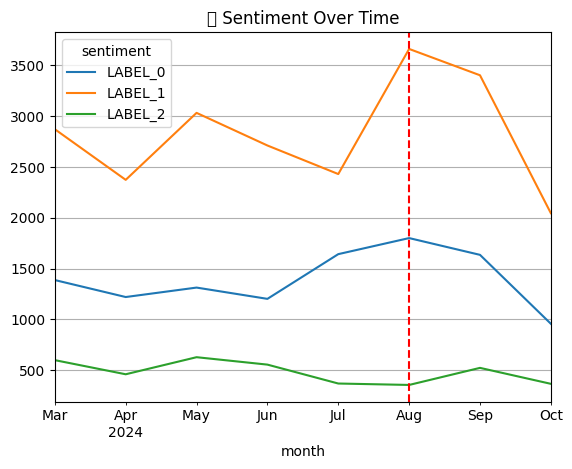

<Figure size 1000x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


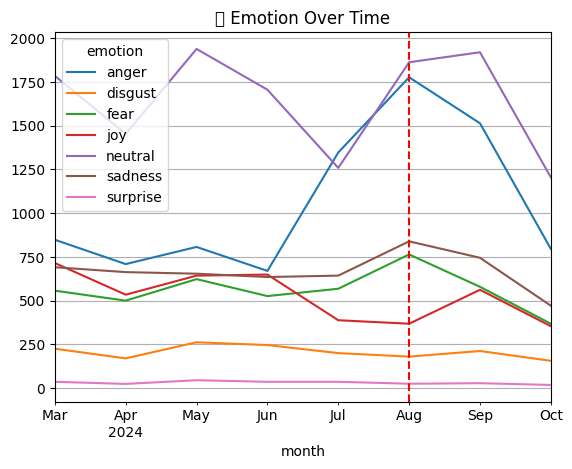


📰 Top Words in Corpus (naive):
the     1123659
of       505856
and      406691
to       401841
in       356967
a        261339
on       148481
for      137743
at       112110
is       107050
that     104474
from      93224
with      91764
he        87921
was       87592
said      85213
as        82610
by        79077
are       72913
has       69484
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


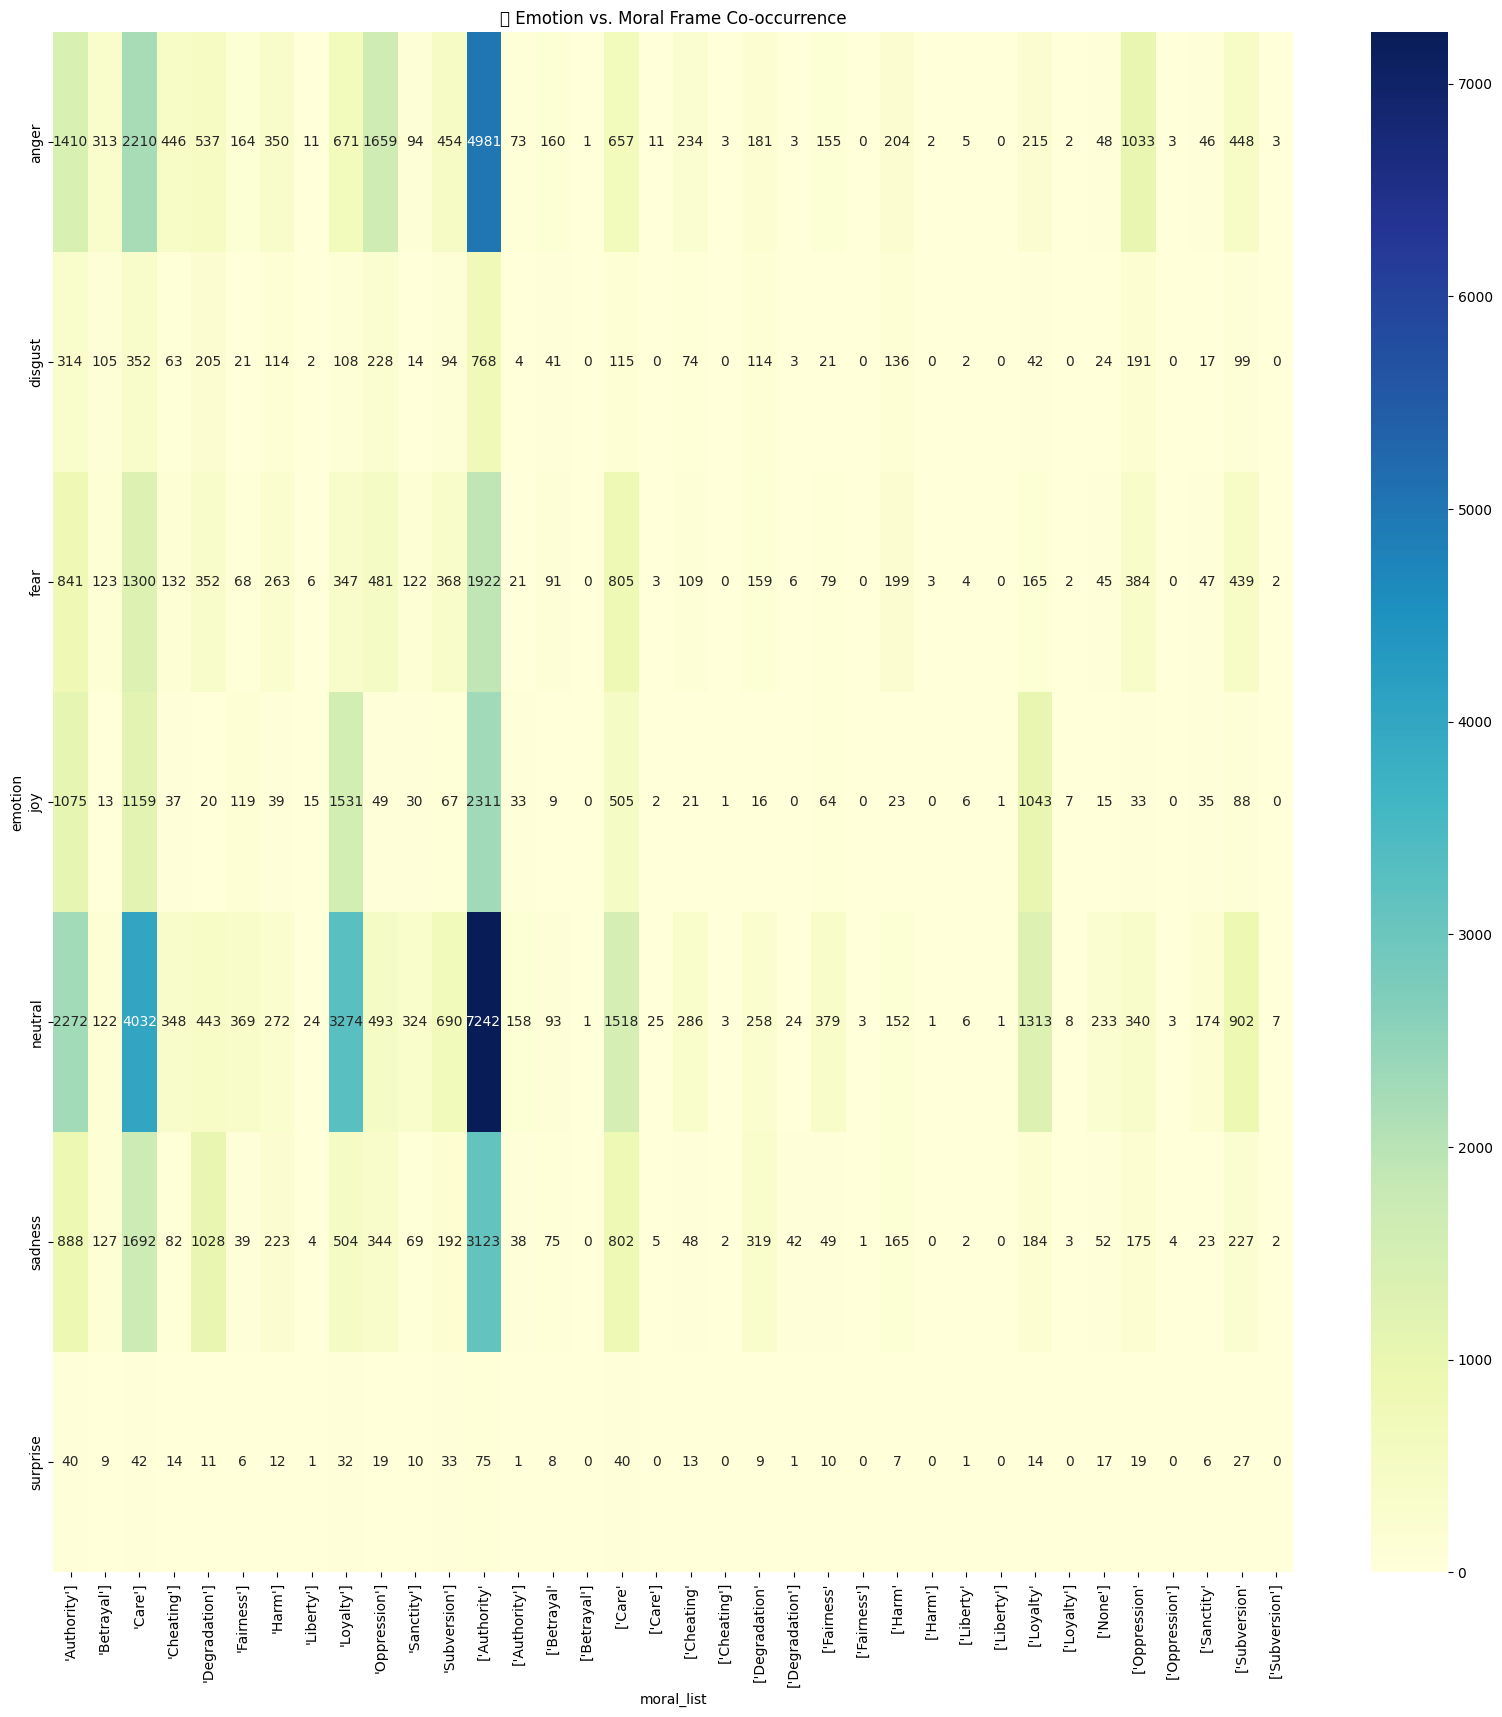

/tmp/ipython-input-10-3176330071.py:80: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


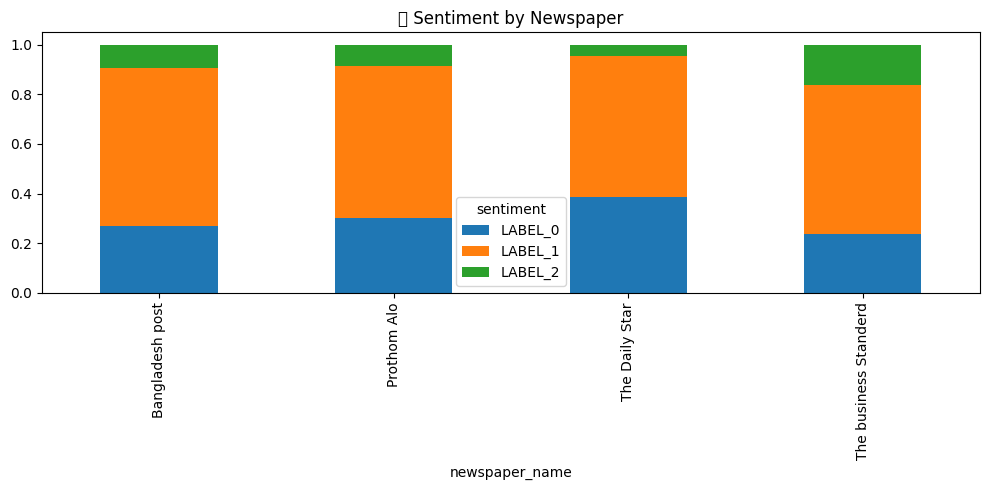


📍 Protest Article Sample:
            Date                                              Title  \
30739 2024-04-21  60 hurt in police, garment workers clash in N’...   
16371 2024-05-13         JnU female student gets 5 yrs in  DSA case   
35173 2024-07-29  74 aggrieved citizens demand investigation of ...   

            top_2_moral_foundations  
30739  ['Authority', 'Degradation']  
16371                      ['None']  
35173      ['Fairness', 'Cheating']  


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


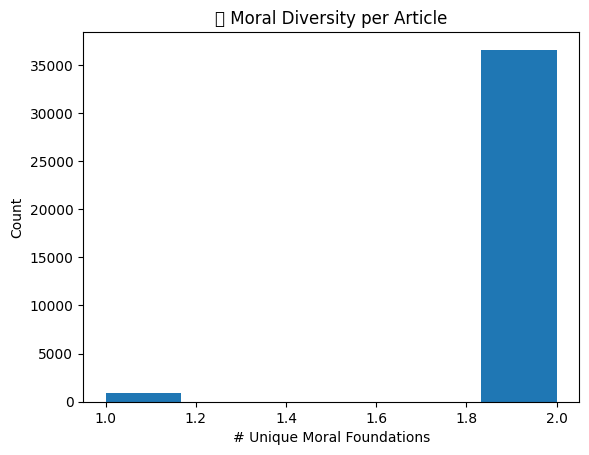

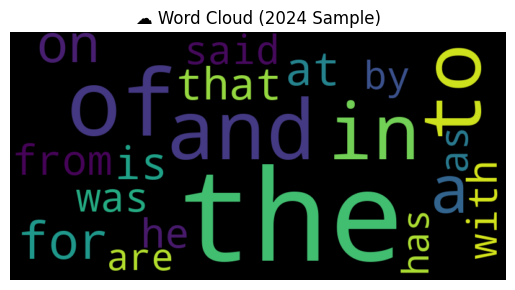


✅ Legitimation with 'order' — 5251 articles
            Date                                              Title
21140 2024-03-02  Chunnu, Rezaul want govt to take responsibilit...

✅ Legitimation with 'stability' — 552 articles
            Date                                              Title
30895 2024-03-25  Collaborative academic, research work underscored

✅ Legitimation with 'protect' — 2142 articles
           Date                                              Title
1602 2024-08-26  Govt responsible for protecting rights of ever...

✅ Legitimation with 'unity' — 2818 articles
            Date                                              Title
29678 2024-08-12  Ctg port urges importers to expedite delivery ...

✅ Legitimation with 'discipline' — 350 articles
            Date                                              Title
30503 2024-05-23  Govt working to create atmosphere for professi...

📉 Framing Decay: Moral Frame Sequences for Hasina
Top Transitions (Hasina):
'Loyalty'] 

In [ ]:
# 🧠 Comprehensive Analysis Roadmap for Moral Framing in Political News
# 10 Research-Aligned NLP Modules with Demos


# Load and prepare data

# Replace with your dataset path

df = df.dropna(subset=['Date', 'Title', 'Details'])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='mixed')

df['text'] = df['Title'].fillna('') + '. ' + df['Details'].fillna('')
df['month'] = df['Date'].dt.to_period('M')
df['regime'] = df['Date'].apply(lambda d: 'Before' if d < pd.to_datetime("2024-08-01") else 'After')
df['moral_list'] = df['top_2_moral_foundations'].fillna('None').apply(lambda x: [s.strip() for s in x.split(',')])
df_exploded = df.explode('moral_list')

moral_labels = ["Care","Harm", "Fairness","Cheating", "Loyalty","Betrayal", "Authority","Subversion", "Sanctity","Degradation", "Liberty","Oppression"]

# ----------------------
# 1. Framing Lexicon Example
# ----------------------
def show_context(keyword):
    return df[df['text'].str.contains(keyword, case=False)].sample(3)[['Date', 'Title', 'text']]
print("\n🔍 Example: 'Protest' Framing Context")
print(show_context("protest"))

# ----------------------
# 2. Entity Moral Framing
# ----------------------
entities = ["Hasina", "Yunus", "Awami League", "BNP", "Army", "Police"]
entity_moral = defaultdict(Counter)
for _, row in df_exploded.iterrows():
    for e in entities:
        if re.search(rf"\b{re.escape(e)}\b", row['text'], re.IGNORECASE):
            entity_moral[e][row['moral_list']] += 1
print("\n📌 Entity-Moral Matrix (Sample):")
print({k: dict(v.most_common(10)) for k,v in entity_moral.items()})

# ----------------------
# 3. Temporal Sentiment & Emotion Shifts
# ----------------------
sentiment_monthly = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)
emotion_monthly = df.groupby(['month', 'emotion']).size().unstack().fillna(0)

plt.figure(figsize=(10,4))
sentiment_monthly.plot(title='📈 Sentiment Over Time')
plt.axvline(pd.Period("2024-08"), color='red', linestyle='--', label='Regime Change')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
emotion_monthly.plot(title='📈 Emotion Over Time')
plt.axvline(pd.Period("2024-08"), color='red', linestyle='--', label='Regime Change')
plt.grid(True)
plt.show()

# ----------------------
# 4. Topic Salience
# ----------------------
top_words = pd.Series(' '.join(df['text']).lower().split()).value_counts().head(20)
print("\n📰 Top Words in Corpus (naive):")
print(top_words)

# ----------------------
# 5. Emotion-Moral Co-occurrence
# ----------------------
cross = pd.crosstab(df_exploded['emotion'], df_exploded['moral_list'])
plt.figure(figsize=(20,20))
sns.heatmap(cross, annot=True, fmt="d", cmap="YlGnBu")
plt.title("💬 Emotion vs. Moral Frame Co-occurrence")
plt.show()

# ----------------------
# 6. Newspaper Bias (Sentiment)
# ----------------------
newspaper_sentiment = df.groupby(['newspaper_name', 'sentiment']).size().unstack().fillna(0)
newspaper_sentiment = newspaper_sentiment.loc[newspaper_sentiment.sum(axis=1) > 50]
newspaper_sentiment.div(newspaper_sentiment.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,5), title='📰 Sentiment by Newspaper')
plt.tight_layout()
plt.show()

# ----------------------
# 7. Event-Specific Framing
# ----------------------
# Example: protest-related articles
protest_df = df[df['text'].str.contains("protest|march|demonstration", case=False)]
print("\n📍 Protest Article Sample:")
print(protest_df[['Date','Title','top_2_moral_foundations']].sample(3))

# ----------------------
# 8. Moral Polarization Score
# ----------------------
moral_diversity = df['moral_list'].apply(lambda x: 0 if x == ['None'] else len(set(x)))
plt.hist(moral_diversity, bins=6)
plt.title("📊 Moral Diversity per Article")
plt.xlabel("# Unique Moral Foundations")
plt.ylabel("Count")
plt.show()

# ----------------------
# 9. Keyword Drift (TF per period)
# ----------------------
df_2024 = df[df['Date'] < "2024-12-31"]
tokens = ' '.join(df_2024['text']).lower().split()
word_freq = pd.Series(tokens).value_counts().head(20)
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("☁️ Word Cloud (2024 Sample)")
plt.show()

# ----------------------
# 10. Moral Legitimation Discourse
# ----------------------
keywords_legitimation = ["order", "stability", "protect", "unity", "discipline"]
for kw in keywords_legitimation:
    hits = df[df['text'].str.contains(kw, case=False) & df['top_2_moral_foundations'].str.contains("Authority|Loyalty", na=False)]
    print(f"\n✅ Legitimation with '{kw}' — {len(hits)} articles")
    print(hits[['Date','Title']].sample(1))

# ----------------------
# 11. Framing Decay or Persistence (Markov Transition)
# ----------------------
print("\n📉 Framing Decay: Moral Frame Sequences for Hasina")
df_hasina = df_exploded[df_exploded['text'].str.contains("Hasina", case=False)]
df_hasina = df_hasina[df_hasina['moral_list'] != 'None']
df_hasina = df_hasina.sort_values('Date')

# Build moral transition sequences per month
moral_sequences = df_hasina.groupby('month')['moral_list'].apply(list)
transitions = defaultdict(Counter)
for sequence in moral_sequences:
    for i in range(len(sequence)-1):
        transitions[sequence[i]][sequence[i+1]] += 1

# Normalize to get Markov transition matrix
markov_matrix = {}
for from_state, counter in transitions.items():
    total = sum(counter.values())
    markov_matrix[from_state] = {to: count/total for to, count in counter.items()}

print("Top Transitions (Hasina):")
for from_m, to_dict in markov_matrix.items():
    top = sorted(to_dict.items(), key=lambda x: -x[1])[:2]
    print(f"{from_m} → {top}")

In [ ]:
!pip install spacy


🧪 Refined Legitimacy vs. Resistance Framing Detection


/tmp/ipython-input-40-2364027108.py:76: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


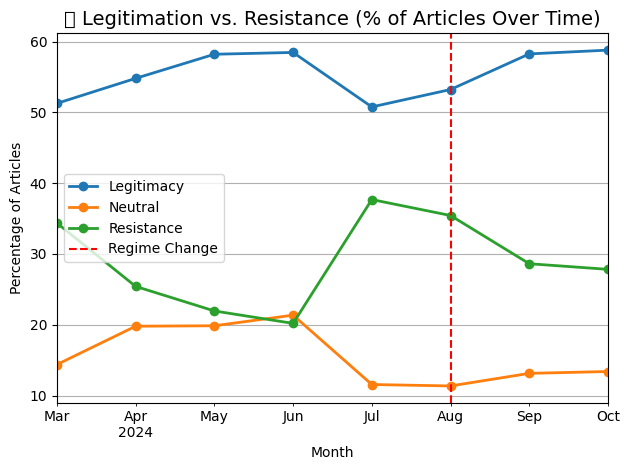


📈 Frame Type by Newspaper Over Time (% Distribution)


/tmp/ipython-input-40-2364027108.py:100: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


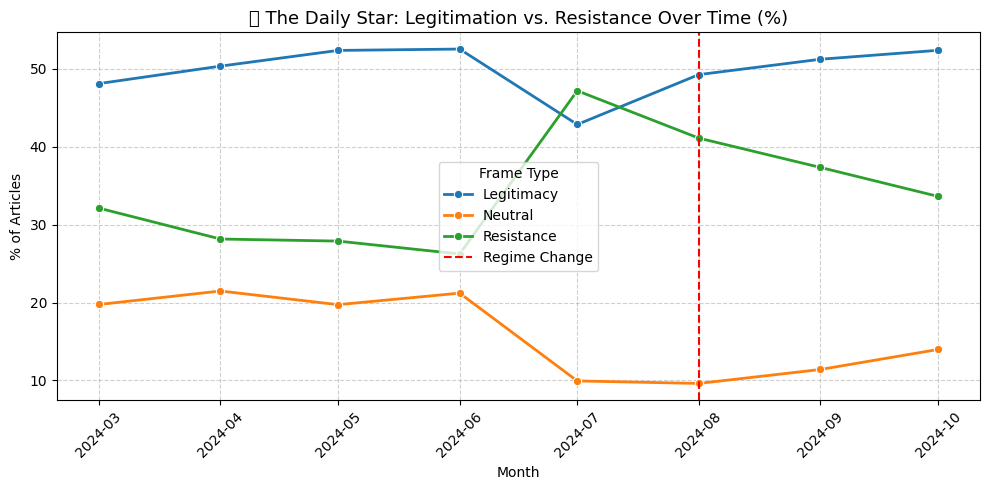

/tmp/ipython-input-40-2364027108.py:100: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


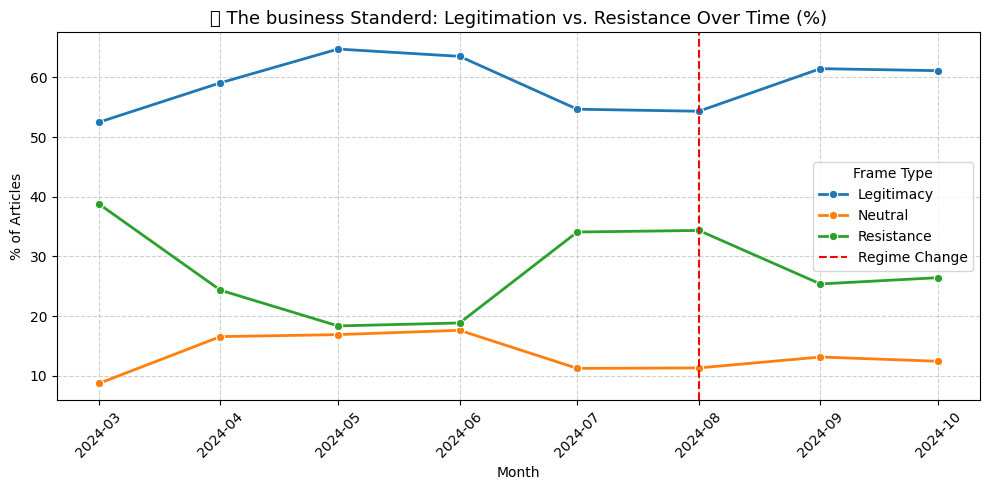

/tmp/ipython-input-40-2364027108.py:100: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


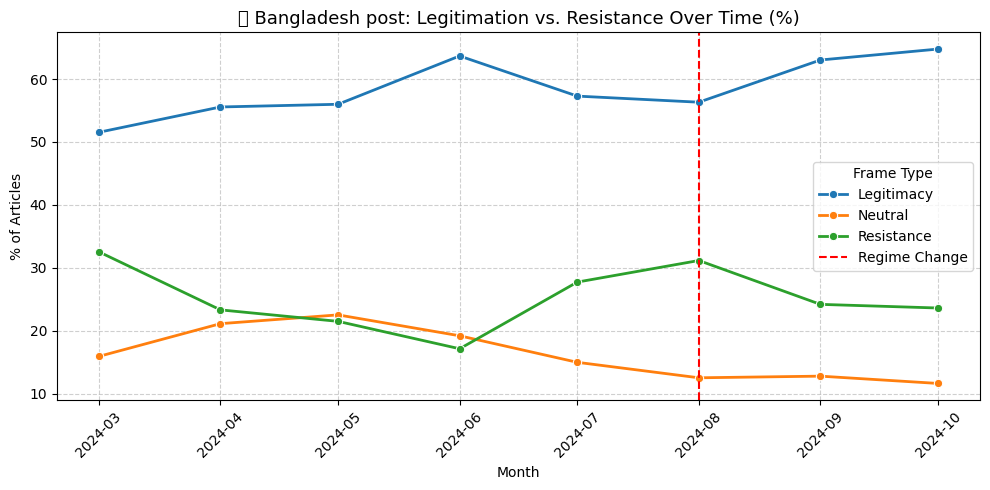

/tmp/ipython-input-40-2364027108.py:100: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


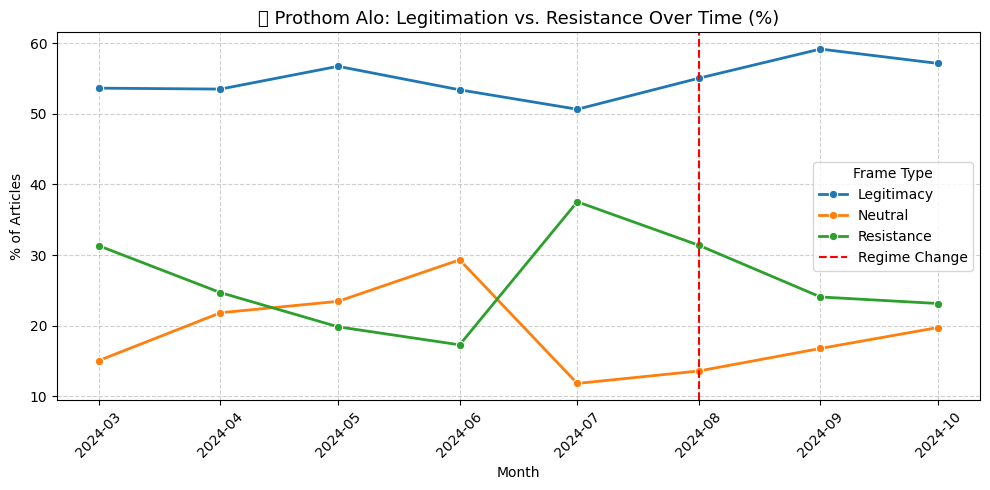


🧮 Example Frame Counts:
frame_type
Legitimacy    20785
Resistance    10953
Neutral        5795
Name: count, dtype: int64


In [ ]:
# 🧠 Comprehensive Analysis Roadmap for Moral Framing in Political News
# 10 Research-Aligned NLP Modules with Demos
# 🧠 Comprehensive Analysis Roadmap for Moral Framing in Political News
# 10 Research-Aligned NLP Modules with Demos

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from tqdm import tqdm

# Ensure spacy is imported
try:
    import spacy
except ImportError as e:
    raise ImportError("Spacy is required but not installed. Please install it with `pip install spacy` before running this notebook.")

from wordcloud import WordCloud

# Load and prepare data

# Replace with your dataset path
df = pd.read_csv("/content/drive/MyDrive/all_english_moral_foundation_labeled_bart_with_top_moral.csv", on_bad_lines='skip', engine='python')
df = df.dropna(subset=['Date', 'Title', 'Details'])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='mixed')
df = df.dropna(subset=['Date'])
df = df[df['Date'] >= pd.to_datetime("2024-01-01")]
df['text'] = df['Title'].fillna('') + '. ' + df['Details'].fillna('')
df['month'] = df['Date'].dt.to_period('M')
df['month_ts'] = df['Date'].dt.to_period('M').dt.to_timestamp()
df['regime'] = df['Date'].apply(lambda d: 'Before' if d < pd.to_datetime("2024-08-01") else 'After')
df['moral_list'] = df['top_2_moral_foundations'].fillna('None').apply(lambda x: [s.strip() for s in x.split(',')])
df_exploded = df.explode('moral_list')

moral_labels = ["Care","Harm", "Fairness","Cheating", "Loyalty","Betrayal", "Authority","Subversion", "Sanctity","Degradation", "Liberty","Oppression"]

# ----------------------
# 12. Refined Legitimacy vs. Resistance Classification
# ----------------------
print("\n🧪 Refined Legitimacy vs. Resistance Framing Detection")
keywords_legit = [
    "stability", "order", "unity", "protect", "security", "development", "progress", "discipline",
    "cooperation", "reform", "rebuild", "support", "authority", "law", "service", "harmony",
    "patriotism", "leadership", "vision", "nation building", "peace"
]

keywords_resist = [
    "protest", "riot", "crackdown", "detained", "resist", "march", "boycott", "dissent",
    "brutality", "arrest", "violence", "oppression", "corruption", "fear", "suppression", "abuse",
    "resignation", "demand", "blockade", "scandal", "activist"
]

def classify_frame_advanced(text):
    text_lower = text.lower()
    l_score = sum(text_lower.count(w) for w in keywords_legit)
    r_score = sum(text_lower.count(w) for w in keywords_resist)
    if l_score == r_score == 0:
        return "Neutral"
    return "Legitimacy" if l_score > r_score else "Resistance"

df['frame_type'] = df['text'].apply(classify_frame_advanced)

# Normalize to percentage per month
frame_month = df.groupby(['month_ts', 'frame_type']).size().unstack().fillna(0)
frame_month_percent = frame_month.div(frame_month.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12,6))
frame_month_percent.plot(marker='o', linewidth=2)
plt.axvline(pd.Timestamp("2024-08-01"), color='red', linestyle='--', label='Regime Change')
plt.title("📊 Legitimation vs. Resistance (% of Articles Over Time)", fontsize=14)
plt.ylabel("Percentage of Articles")
plt.xlabel("Month")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Per Newspaper Analysis — Enhanced Plotting
print("\n📈 Frame Type by Newspaper Over Time (% Distribution)")
news_month_frame = df.groupby(['newspaper_name', 'month_ts', 'frame_type']).size().unstack().fillna(0)
news_month_percent = news_month_frame.groupby(level=0).apply(lambda x: x.div(x.sum(axis=1), axis=0) * 100)

unique_papers = df['newspaper_name'].dropna().unique().tolist()

for paper in unique_papers:
    sub = news_month_percent.loc[paper].reset_index()
    melted = sub.melt(id_vars='month_ts', var_name='frame_type', value_name='percent')
    melted = melted[pd.to_numeric(melted['percent'], errors='coerce').notnull()]  # Filter out non-numeric rows
    melted['percent'] = melted['percent'].astype(float)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=melted, x='month_ts', y='percent', hue='frame_type', marker='o', linewidth=2)
    plt.axvline(pd.Timestamp("2024-08-01"), color='red', linestyle='--', label='Regime Change')
    plt.title(f"📰 {paper}: Legitimation vs. Resistance Over Time (%)", fontsize=13)
    plt.ylabel("% of Articles")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Frame Type")
    plt.tight_layout()
    plt.show()

print("\n🧮 Example Frame Counts:")
print(df['frame_type'].value_counts())





🧪 Refined Legitimacy vs. Resistance Framing Detection


/tmp/ipython-input-26-202434325.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


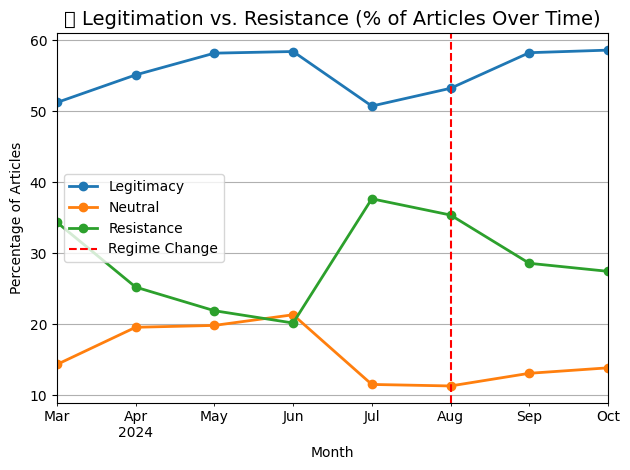


📈 Frame Type by Newspaper Over Time (% Distribution)


KeyError: 'month_ts'

In [ ]:
print("\n🧪 Refined Legitimacy vs. Resistance Framing Detection")
keywords_legit = [
    "stability", "order", "unity", "protect", "security", "development", "progress", "discipline",
    "cooperation", "reform", "rebuild", "support", "authority", "law", "service", "harmony",
    "patriotism", "leadership", "vision", "nation building", "peace"
]

keywords_resist = [
    "protest", "riot", "crackdown", "detained", "resist", "march", "boycott", "dissent",
    "brutality", "arrest", "violence", "oppression", "corruption", "fear", "suppression", "abuse",
    "resignation", "demand", "blockade", "scandal", "activist"
]

def classify_frame_advanced(text):
    text_lower = text.lower()
    l_score = sum(text_lower.count(w) for w in keywords_legit)
    r_score = sum(text_lower.count(w) for w in keywords_resist)
    if l_score == r_score == 0:
        return "Neutral"
    return "Legitimacy" if l_score > r_score else "Resistance"

df['frame_type'] = df['text'].apply(classify_frame_advanced)

# Normalize to percentage per month
frame_month = df.groupby(['month', 'frame_type']).size().unstack().fillna(0)
frame_month_percent = frame_month.div(frame_month.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12,6))
frame_month_percent.plot(marker='o', linewidth=2)
plt.axvline(pd.Timestamp("2024-08-01"), color='red', linestyle='--', label='Regime Change')
plt.title("📊 Legitimation vs. Resistance (% of Articles Over Time)", fontsize=14)
plt.ylabel("Percentage of Articles")
plt.xlabel("Month")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Per Newspaper Analysis
print("\n📈 Frame Type by Newspaper Over Time (% Distribution)")
news_month_frame = df.groupby(['newspaper_name', 'month', 'frame_type']).size().unstack().fillna(0)
news_month_percent = news_month_frame.groupby(level=0).apply(lambda x: x.div(x.sum(axis=1), axis=0) * 100)

for paper in df['newspaper_name'].unique():
    sub = news_month_percent.loc[paper]
    sub.plot(marker='o', linewidth=2, title=f"📰 {paper}: Legitimation vs. Resistance Over Time (%)", figsize=(10,4))
    plt.axvline(pd.Timestamp("2024-08-01"), color='red', linestyle='--', label='Regime Change')
    plt.ylabel("% of Articles")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n🧮 Example Frame Counts:")
print(df['frame_type'].value_counts())

In [ ]:
!pip install -q sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 925.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.6 MB/s eta 0:00:00


In [ ]:
def extract_context(entity, text, window=30):
    pattern = re.compile(r'\b{}\b'.format(re.escape(entity)), re.IGNORECASE)
    matches = pattern.finditer(text)
    contexts = []
    for match in matches:
        start = max(match.start() - window, 0)
        end = min(match.end() + window, len(text))
        contexts.append(text[start:end])
    return contexts
import pandas as pd
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/all_english_labeled_news.csv", on_bad_lines='skip', engine='python')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['text'] = df['Title'].fillna('') + '. ' + df['Details'].fillna('')
df['regime'] = df['Date'].apply(lambda d: 'Before' if d < pd.Timestamp("2024-08-01") else 'After')

entities_to_track =  [
    "Hasina", "Sheikh Hasina", "Yunus", "Dr. Md. Yunus", "Awami League", "AL", "BNP",
    "interim government", "caretaker government", "RAB", "Police", "Army", "Jatiya Party",
    "Jamaat-e-Islami",'jamaat','shibir',"chatradal","bal",'chatra league',"tarek zia","khaleda zia","khaleda" "Election Commission", "EC", "PM", "Ministry"
]

def extract_context(entity, text, window=50):
    pattern = re.compile(r'\b{}\b'.format(re.escape(entity)), re.IGNORECASE)
    matches = pattern.finditer(text)
    contexts = []
    for match in matches:
        start = max(match.start() - window, 0)
        end = min(match.end() + window, len(text))
        contexts.append(text[start:end])
    return contexts

entity_contexts = {ent: {'Before': [], 'After': []} for ent in entities_to_track}

for _, row in df.iterrows():
    for entity in entities_to_track:
        contexts = extract_context(entity, row['text'])
        if contexts:
            entity_contexts[entity][row['regime']].extend(contexts)

# 🔍 Now generate top words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_words(contexts):
    all_text = " ".join(contexts).lower()
    words = re.findall(r'\b\w+\b', all_text)
    words = [w for w in words if w not in stop_words and len(w) > 3]
    return Counter(words).most_common(100)

# 🔬 Print most used words around each entity (before vs after)
for ent in entities_to_track:
    print(f"\n🔷 {ent.upper()} — Before Regime Change")
    print(get_top_words(entity_contexts[ent]['Before']))
    print(f"🔶 {ent.upper()} — After Regime Change")
    print(get_top_words(entity_contexts[ent]['After']))


KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/tmp/ipython-input-45-2674489394.py:63: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) De

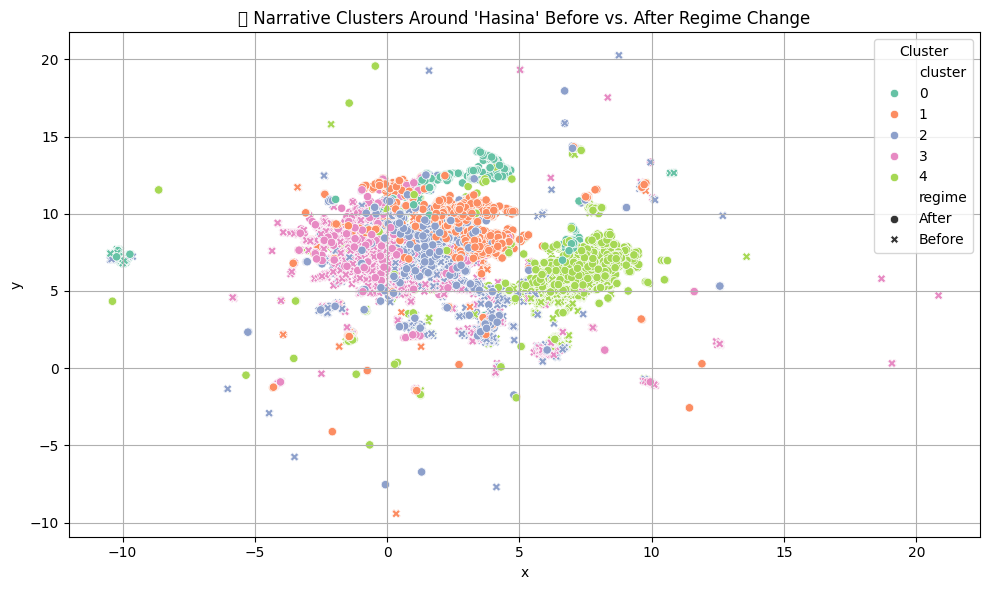


🔍 Top Contexts for Entity 'Hasina' by Cluster:


--- Cluster 0 ---
• ional Crimes Tribunal against Hasina and her party colleagues for
• ional Crimes Tribunal against Hasina and her party colleagues for
• early 200 cases filed against Hasina, a majority of them in connec
• ling garment worker on Aug 5: Hasina, Rehana, 69 others sued. Form
• Akhter filed the case against Hasina and others with the Court of

--- Cluster 1 ---
• ousted Prime Minister Sheikh Hasina, in his plea.
• er the constitution of Sheikh Hasina and her President Mohammed Sh
• 5, after hearing that Sheikh Hasina had fled the country. Little
• and after the fall of Sheikh Hasina led government, he continued
• former prime minister Sheikh Hasina's government is being accused

--- Cluster 2 ---
• ister, Sheikh Mujibur Rahman, Hasina's father. In 1990, the countr
• , 78 people, including Sheikh Hasina, Obaidul Quader, Zuanid Ahmed
• s on Dhaka-Delhi ties, Sheikh Hasina's stay in India, revival of S
• itiative to bring ba

In [ ]:
# 📦 Step 1: Install Sentence Transformers
!pip install -q sentence-transformers umap-learn

# 📚 Step 2: Import Libraries
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import re

# 🧠 Step 3: Load Model and Dataset
model = SentenceTransformer("all-MiniLM-L6-v2")

# Load your pre-labeled dataframe
df = pd.read_csv("/content/drive/MyDrive/all_english_moral_foundation_labeled_bart_with_top_moral.csv", on_bad_lines='skip', engine='python')
df = df.dropna(subset=['Date', 'Title', 'Details'])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df[df['Date'] >= pd.to_datetime("2024-01-01")]
df['text'] = df['Title'].fillna('') + ". " + df['Details'].fillna('')
df['regime'] = df['Date'].apply(lambda d: 'Before' if d < pd.to_datetime("2024-08-01") else 'After')

# 🕵️‍♂️ Step 4: Define Entity and Extract Context
target_entity = "Hasina"  # You can change to "Yunus", "RAB", etc.

def extract_context_windows(text, entity, window=30):
    text_lower = text.lower()
    matches = [m.start() for m in re.finditer(entity.lower(), text_lower)]
    windows = []
    for pos in matches:
        start = max(0, pos - window)
        end = min(len(text), pos + len(entity) + window)
        windows.append(text[start:end])
    return windows

df['context_windows'] = df['text'].apply(lambda t: extract_context_windows(t, target_entity))
df_exploded = df.explode('context_windows').dropna(subset=['context_windows'])

# 🧠 Step 5: Encode Contexts
contexts = df_exploded['context_windows'].tolist()
embeddings = model.encode(contexts, convert_to_tensor=False)

# 📊 Step 6: Cluster Embeddings
k = 5  # Number of clusters/themes
km = KMeans(n_clusters=k, random_state=42)
labels = km.fit_predict(embeddings)
df_exploded['cluster'] = labels

# 🌐 Step 7: UMAP Projection for Visualization
reducer = umap.UMAP(random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)
df_exploded['x'] = umap_embeddings[:,0]
df_exploded['y'] = umap_embeddings[:,1]

# 🎨 Step 8: Plot Clusters and Label Distributions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_exploded, x='x', y='y', hue='cluster', style='regime', palette='Set2')
plt.title(f"🧭 Narrative Clusters Around '{target_entity}' Before vs. After Regime Change")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# 🧾 Step 9: Show top phrases per cluster
print(f"\n🔍 Top Contexts for Entity '{target_entity}' by Cluster:\n")
for c in sorted(df_exploded['cluster'].unique()):
    print(f"\n--- Cluster {c} ---")
    top_texts = df_exploded[df_exploded['cluster'] == c]['context_windows'].head(5).tolist()
    for t in top_texts:
        print("•", t.strip())


/tmp/ipython-input-46-1472649733.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['Title'].fillna('') + '. ' + df['Details'].fillna('')
/tmp/ipython-input-46-1472649733.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['Date'].dt.to_period('M')
/tmp/ipython-input-46-1472649733.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 


🔍 Entity-Based Context Window Clustering: Hasina (Before/After)


/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/tmp/ipython-input-46-1472649733.py:72: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


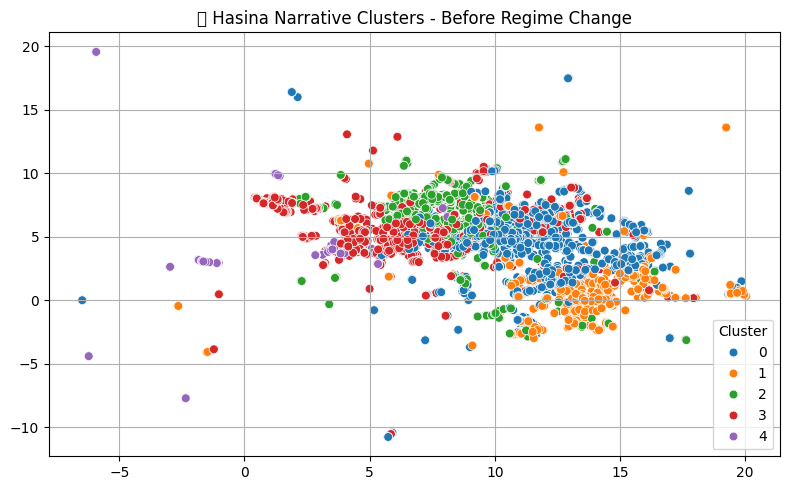

/tmp/ipython-input-46-1472649733.py:81: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


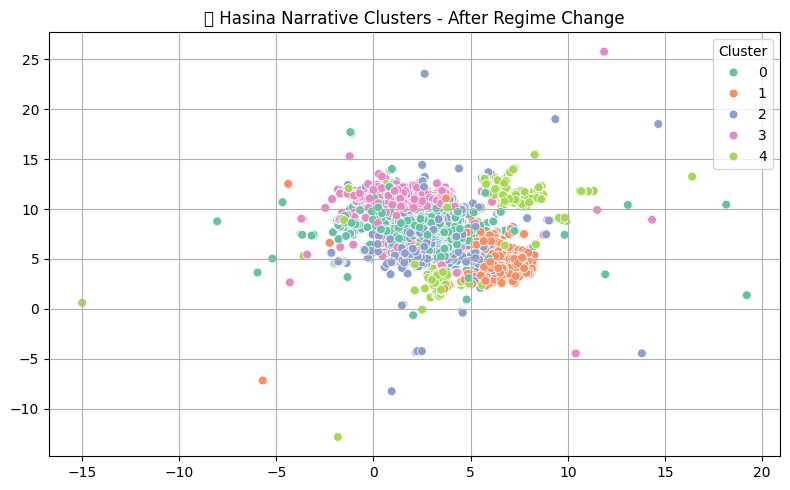


🧾 Cluster Interpretation — Before
--- Cluster 0 ---
• comprehensive strategic cooperative partners. "China stands ready to work with Bangladesh to deliver on the important co
• neighbour of India. It always gives support to the Bangladesh government and its people for implementation of Dhaka's vi
• Will take foreign tech support for judicial probe. Prime Minister Sheikh Hasina yesterday said the government will seek 
• to jeopardise the future of Bangladesh and its people. "We will not allow anyone to play with the fate of Bangladesh, so
• PM seeks Japan’s cooperation to reopen damaged metro rail stations. Prime Minister Sheikh Hasina today sought cooperatio

--- Cluster 1 ---
• PM visits Kurmitola hospital to see victims of recent violence. Prime Minister Sheikh Hasina visited Kurmitola General H
• PM to attend BIMSTEC summit in Thailand. Prime Minister Sheikh Hasina is set to visit Thailand to participate in the BIM
• PM to take stock of situation at today's cabinet meeting. Prime M

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from tqdm import tqdm
import spacy
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import umap
import numpy as np

# Load and prepare data

# Replace with your dataset path
df = pd.read_csv("/content/drive/MyDrive/all_english_moral_foundation_labeled_bart_with_top_moral.csv", on_bad_lines='skip', engine='python')
df = df.dropna(subset=['Date', 'Title', 'Details'])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='mixed')
df = df.dropna(subset=['Date'])
df = df[df['Date'] >= pd.to_datetime("2024-01-01")]
df['text'] = df['Title'].fillna('') + '. ' + df['Details'].fillna('')
df['month'] = df['Date'].dt.to_period('M')
df['month_ts'] = df['Date'].dt.to_period('M').dt.to_timestamp()
df['regime'] = df['Date'].apply(lambda d: 'Before' if d < pd.to_datetime("2024-08-01") else 'After')
df['moral_list'] = df['top_2_moral_foundations'].fillna('None').apply(lambda x: [s.strip() for s in x.split(',')])
df_exploded = df.explode('moral_list')

moral_labels = ["Care","Harm", "Fairness","Cheating", "Loyalty","Betrayal", "Authority","Subversion", "Sanctity","Degradation", "Liberty","Oppression"]
# ==============================
# ✳️ Entity-Based Context Window Clustering (Before vs After)
# ==============================
print("\n🔍 Entity-Based Context Window Clustering: Hasina (Before/After)")

nlp = spacy.load("en_core_web_sm")
entity_name = "Hasina"
window_size = 30

# Extract windows around entity
def extract_windows(text, entity=entity_name):
    words = text.split()
    indices = [i for i, w in enumerate(words) if entity.lower() in w.lower()]
    return [' '.join(words[max(0, i - window_size):i + window_size]) for i in indices]

windows_before = df[df['regime'] == 'Before']['text'].apply(extract_windows).explode().dropna().tolist()
windows_after = df[df['regime'] == 'After']['text'].apply(extract_windows).explode().dropna().tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode
X_before = model.encode(windows_before)
X_after = model.encode(windows_after)

# Dimensionality reduction
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine')
X_umap_before = umap_model.fit_transform(X_before)
X_umap_after = umap_model.fit_transform(X_after)

# Clustering
k = 5
kmeans_before = KMeans(n_clusters=k, random_state=42).fit(X_before)
kmeans_after = KMeans(n_clusters=k, random_state=42).fit(X_after)
labels_before = kmeans_before.labels_
labels_after = kmeans_after.labels_

# Plot Before
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_umap_before[:,0], y=X_umap_before[:,1], hue=labels_before, palette='tab10', s=40)
plt.title("🟡 Hasina Narrative Clusters - Before Regime Change")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot After
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_umap_after[:,0], y=X_umap_after[:,1], hue=labels_after, palette='Set2', s=40)
plt.title("🟢 Hasina Narrative Clusters - After Regime Change")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Show top 5 examples from each cluster
print("\n🧾 Cluster Interpretation — Before")
for i in range(k):
    print(f"--- Cluster {i} ---")
    cluster_texts = [w for w, label in zip(windows_before, labels_before) if label == i][:5]
    for t in cluster_texts:
        print("•", t[:120])
    print()

print("\n🧾 Cluster Interpretation — After")
for i in range(k):
    print(f"--- Cluster {i} ---")
    cluster_texts = [w for w, label in zip(windows_after, labels_after) if label == i][:5]
    for t in cluster_texts:
        print("•", t[:120])
    print()

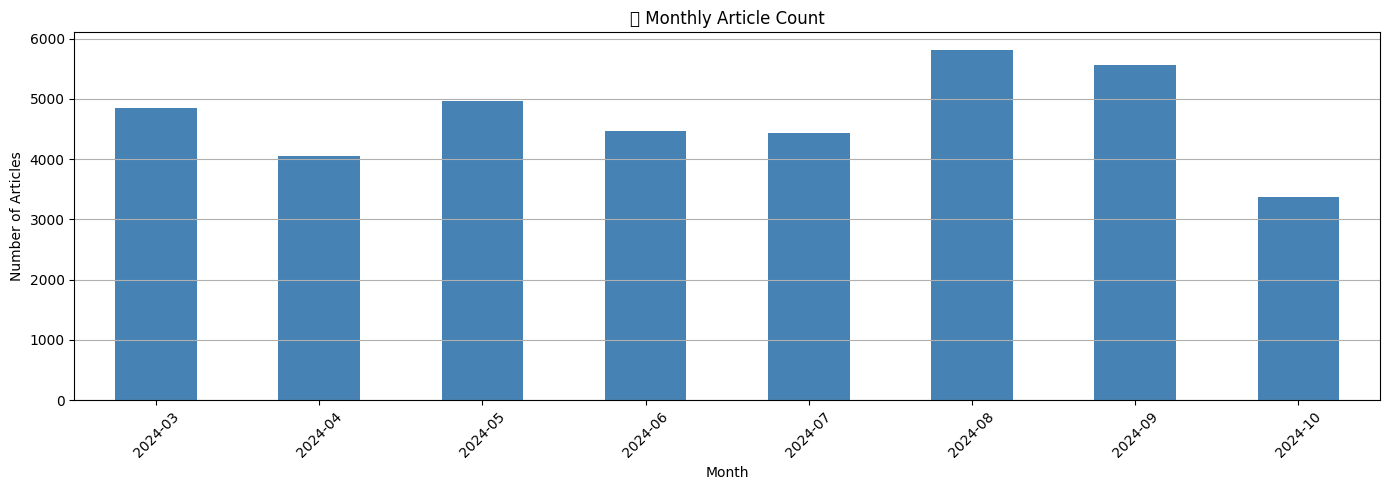

🔍 Corpus Metadata Summary
📰 Total Articles: 37533
📅 Date Range: 2024-03-01 → 2024-10-20
📆 Unique Days: 234
🧍 Unique Actors: N/A
🗞️ Newspapers: 4

🧪 Preprocessing Pipeline:

✅ Language: English


🧼 Preprocessing Steps Applied:
- Lowercasing
- Removal of links, punctuation, digits
- Stopword removal (custom + NLTK)
- Lemmatization (SpaCy)
- N-gram extraction (bi/trigrams)
- TF-IDF and Collocation Analysis
- Sentence Embeddings via SentenceTransformers (GPU-enabled)
- Topic Modeling via BERTopic
- Actor extraction via custom dictionaries
- Emotion, sentiment, and moral labeling via pre-trained models (BART + classifiers)


🗞️ Article Distribution by Newspaper:
newspaper_name
The business Standerd    13698
The Daily Star           11078
Prothom Alo               6431
Bangladesh post           6326
Name: count, dtype: int64

✅ Metadata report and plots saved.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 📥 LOAD YOUR DATASET
# -------------------------
file_path = "/content/drive/MyDrive/merged_framing_dataset.csv"  # 🔁 Replace this with your real path
df = pd.read_csv(file_path, on_bad_lines="skip", engine="python")

# -------------------------
# 📅 DATE PARSING & RANGE
# -------------------------
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])
min_date = df["Date"].min()
max_date = df["Date"].max()

# -------------------------
# 📊 ARTICLE COUNTS
# -------------------------
summary = {
    "📰 Total Articles": len(df),
    "📅 Date Range": f"{min_date.date()} → {max_date.date()}",
    "📆 Unique Days": df["Date"].nunique(),
    "🧍 Unique Actors": df["actor_mentions"].nunique() if "actor_mentions" in df else "N/A",
    "🗞️ Newspapers": df["newspaper_name"].nunique(),
    #"📊 Regime Periods": df["Regime"].value_counts().to_dict(),
}

# -------------------------
# 📈 Monthly Article Trends
# -------------------------
df["Month"] = df["Date"].dt.to_period("M")
monthly_counts = df.groupby("Month").size()

plt.figure(figsize=(14, 5))
monthly_counts.plot(kind="bar", color="steelblue")
plt.title("🗓️ Monthly Article Count")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.savefig("/content/monthly_article_trend.png")
plt.show()

# -------------------------
# 📚 Preprocessing Pipeline Description
# -------------------------
preprocessing_notes = """
✅ Language: English


🧼 Preprocessing Steps Applied:
- Lowercasing
- Removal of links, punctuation, digits
- Stopword removal (custom + NLTK)
- Lemmatization (SpaCy)
- N-gram extraction (bi/trigrams)
- TF-IDF and Collocation Analysis
- Sentence Embeddings via SentenceTransformers (GPU-enabled)
- Topic Modeling via BERTopic
- Actor extraction via custom dictionaries
- Emotion, sentiment, and moral labeling via pre-trained models (BART + classifiers)
"""

# -------------------------
# 📋 Corpus Overview
# -------------------------
print("🔍 Corpus Metadata Summary")
for key, val in summary.items():
    print(f"{key}: {val}")

print("\n🧪 Preprocessing Pipeline:")
print(preprocessing_notes)

# -------------------------
# 📊 Per Actor & Newspaper (Optional)
# -------------------------
if "actor_mentions" in df.columns:
    df["actor_mentions"] = df["actor_mentions"].astype(str)
    actor_counts = df["actor_mentions"].value_counts().head(20)

    print("\n👤 Top 20 Mentioned Actors:")
    print(actor_counts)

newspaper_counts = df["newspaper_name"].value_counts()
print("\n🗞️ Article Distribution by Newspaper:")
print(newspaper_counts)

# ✅ Save report
monthly_counts.to_csv("/content/monthly_article_counts.csv")
newspaper_counts.to_csv("/content/article_distribution_by_newspaper.csv")
print("\n✅ Metadata report and plots saved.")


In [ ]:
df

,Unnamed: 0,Date,Title,Link,Details,newspaper_name,text,sentiment,emotion,top_2_moral_foundations,top_2_moral_scores,parsed_morals,clean_text,bertopic_label,time_window,moral_list,Month
0,0,2024-09-24,Ex-IGP Mamun on 4-day remand in murder case,https://www.thedailystar.net/news/bangladesh/c...,A Dhaka court today placed former inspector ge...,The Daily Star,Ex-IGP Mamun on 4-day remand in murder case. A...,label_0,anger,"['Authority', 'Care']","{'Authority': 0.7845588326454163, 'Care': 0.64...","['authority', 'care']",exigp mamun on day remand in murder case a dha...,11,After,"['authority', 'care']",2024-09
1,1,2024-09-24,"Touhid, Jaishankar meet at UNGA, discuss mutua...",https://www.thedailystar.net/news/bangladesh/d...,"Foreign Affairs Adviser, HE Md. Touhid Hossai...",The Daily Star,"Touhid, Jaishankar meet at UNGA, discuss mutua...",label_1,fear,"['Authority', 'Loyalty']","{'Authority': 0.8064534068107605, 'Loyalty': 0...","['authority', 'loyalty']",touhid jaishankar meet at unga discuss mutual ...,50,After,"['authority', 'loyalty']",2024-09
2,2,2024-09-24,Army chief pledges support for Yunus' interim ...,https://www.thedailystar.net/news/bangladesh/n...,Bangladesh's army chief vowed to back the coun...,The Daily Star,Army chief pledges support for Yunus' interim ...,label_1,anger,"['Subversion', 'Oppression']","{'Subversion': 0.9299159646034241, 'Oppression...","['subversion', 'oppression']",army chief pledges support for yunus interim g...,81,After,"['subversion', 'oppression']",2024-09
3,3,2024-09-24,Released top criminals at it again,https://www.thedailystar.net/news/bangladesh/c...,"Nasir Biswas, a 26-year-old mason, was walking...",The Daily Star,Released top criminals at it again. Nasir Bisw...,label_1,anger,"['Sanctity', 'Subversion']","{'Sanctity': 0.8243871927261353, 'Subversion':...","['sanctity', 'subversion']",released top criminals at it again nasir biswa...,-1,After,"['sanctity', 'subversion']",2024-09
4,4,2024-09-24,Shibir now out into the open at DU,https://www.thedailystar.net/campus/news/shibi...,"After around three and a half decades, Islami ...",The Daily Star,Shibir now out into the open at DU. After arou...,label_1,disgust,"['Sanctity', 'Cheating']","{'Sanctity': 0.8725903630256653, 'Cheating': 0...","['sanctity', 'cheating']",shibir now out into the open at du after aroun...,-1,After,"['sanctity', 'cheating']",2024-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37528,50302,2024-10-05,India foreign minister to visit Pakistan in ra...,https://en.prothomalo.com/international/india/...,India's foreign minister will be in Pakistan l...,Prothom Alo,India foreign minister to visit Pakistan in ra...,label_1,neutral,"['Authority', 'Care']","{'Authority': 0.7862706184387207, 'Care': 0.57...","['authority', 'care']",india foreign minister to visit pakistan in ra...,31,After,"['authority', 'care']",2024-10
37529,50303,2024-10-05,Initiative to reform Shilpakala Academy Act,https://en.prothomalo.com/entertainment/tkx9v6...,An initiative has been taken to reform Banglad...,Prothom Alo,Initiative to reform Shilpakala Academy Act. A...,label_1,neutral,"['Authority', 'Care']","{'Authority': 0.8890504837036133, 'Care': 0.70...","['authority', 'care']",initiative to reform shilpakala academy act an...,-1,After,"['authority', 'care']",2024-10
37530,50304,2024-10-05,India bemoan 'harsh' T20 World Cup run-out row,https://en.prothomalo.com/sports/cricket/xzyc3...,India star Jemimah Rodrigues described a run-o...,Prothom Alo,India bemoan 'harsh' T20 World Cup run-out row...,label_1,disgust,"['Harm', 'Care']","{'Harm': 0.9209035634994507, 'Care': 0.8041914...","['harm', 'care']",india bemoan harsh t world cup runout row indi...,25,After,"['harm', 'care']",2024-10
37531,50305,2024-10-05,Reform commissions likely to start operations ...,https://en.prothomalo.com/bangladesh/op5bwbj4iz,Although the notification regarding the five o...,Prothom Alo,Reform commissions likely to start operations ...,labe

In [ ]:
# -----------------------------------------------
# 0.  Imports & data loading
# -----------------------------------------------
import pandas as pd, numpy as np, re
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/merged_framing_dataset.csv")          # <— change me
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_convert('Asia/Dhaka')

# ------------------------------------------------
# 1.  Minimal wrangling
# ------------------------------------------------
# Regime cut‑off: 05 Aug 2024 23:59:59 local
cutoff = pd.Timestamp("2024-08-06", tz='Asia/Dhaka')
df['Regime'] = np.where(df['Date'] < cutoff, 'AL', 'Yunus')

# Optional: If sentiment is categorical, map → num so Welch t can run
sent_map = {'Negative':-1, 'Neutral':0, 'Positive':1}
if df['sentiment'].dtype == 'O':
    df['sentiment_score'] = df['sentiment'].map(sent_map)
else:
    df['sentiment_score'] = df['sentiment']

# Extract dominant moral (first item in comma‑sep string)
df['dominant_moral'] = df['top_2_moral_foundations'].str.split(',').str[0].str.strip()

# ------------------------------------------------
# 2.  Welch t‑test  (Sentiment score)
# ------------------------------------------------
al_sent   = df.loc[df.Regime=='AL',   'sentiment_score'].dropna()
yunus_sent= df.loc[df.Regime=='Yunus','sentiment_score'].dropna()
t_stat,p  = stats.ttest_ind(al_sent, yunus_sent, equal_var=False)
print(f"Welch t‑test – Sentiment:\n  t = {t_stat:.3f},  p = {p:.4g}")

# ------------------------------------------------
# 3.  χ² test  (Emotion distribution)
# ------------------------------------------------
emotion_ct = pd.crosstab(df['emotion'], df['Regime'])
chi2,p,_,_ = stats.chi2_contingency(emotion_ct)
print(f"\nChi‑square – Emotion×Regime:\n  χ² = {chi2:.2f},  p = {p:.4g}")

# ------------------------------------------------
# 4.  Moral foundation shift  (χ² + Multinomial logit)
# ------------------------------------------------
moral_ct = pd.crosstab(df['dominant_moral'], df['Regime'])
chi2,p,_,_ = stats.chi2_contingency(moral_ct)
print(f"\nChi‑square – Moral×Regime:\n  χ² = {chi2:.2f},  p = {p:.4g}")

# Multinomial logit (Regime → dominant moral)  ─────────────────────
#   baseline moral = 'Authority' (change if absent)
df_mod = df.dropna(subset=['dominant_moral'])
mod = smf.mnlogit('dominant_moral ~ Regime', data=df_mod).fit()
print(mod.summary())

# ------------------------------------------------
# 5.  Structural Topic Model  (Topic prevalence ← Regime)
# ------------------------------------------------
"""
STM is easier in R.  The block below writes the article‑topic matrix
  (if you have a γ matrix from BERTopic) and calls R’s stm::stm().
Run in an rpy2‑enabled cell *or* copy to an R script.*

# ----- Python: save inputs for R ----------------------------------
doc_topic = pd.read_csv('bertopic_gamma.csv', index_col=0)   # rows = docs, cols = topics
doc_topic['Regime'] = df['Regime'].values
doc_topic.to_csv('stm_input.csv')

# ----- R ----------------------------------------------------------
library(stm)
X  <- read.csv("stm_input.csv")
K  <- ncol(X) - 1                               # number of topics
form <- reformulate("Regime")
out <- stm(documents = as.matrix(X[,-ncol(X)]),
           K = K,
           prevalence = form,
           data = X)
summary(out)
"""

# ------------------------------------------------
# 6.  Two‑way ANOVA  (Sentiment ~ Regime × Ideology)
# ------------------------------------------------
# 1) Add / merge your newspaper_ideology (manually or via classifier)
# df['ideology'] ∈ {'Pro‑AL','Pro‑BNP', …}
df = df.dropna(subset=['sentiment_score','ideology'])

model = smf.ols('sentiment_score ~ C(Regime)*C(ideology)', data=df).fit()
anova_tbl = anova_lm(model, typ=2)
print("\nTwo‑way ANOVA – Sentiment\n", anova_tbl)

# Optional post‑hoc pairwise comparisons
tukey = pairwise_tukeyhsd(df['sentiment_score'],
                          df['Regime'] + "_" + df['ideology'])
print("\nTukey HSD post‑hoc\n", tukey)

# ------------------------------------------------
# 7.  Quick sanity plots (delete if you only need stats)
# ------------------------------------------------
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(1,3, figsize=(14,4))

# Sentiment timeline
sns.lineplot(ax=axs[0], data=df, x='Date', y='sentiment_score', hue='Regime',
             estimator='mean', ci='sd')
axs[0].set_title('Rolling mean sentiment')

# Emotion distribution stacked
emotion_ct.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title('Emotion counts by Regime')

# Moral proportions
moral_ct.div(moral_ct.sum(0), axis=1).T.plot(kind='bar', stacked=True, ax=axs[2])
axs[2].set_title('Moral share per Regime')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


Welch t‑test – Sentiment:
  t = nan,  p = nan

Chi‑square – Emotion×Regime:
  χ² = 333.91,  p = 4.382e-69

Chi‑square – Moral×Regime:
  χ² = 228.19,  p = 1.037e-35


ValueError: endog has evaluated to an array with multiple columns that has shape (37533, 24). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

In [ ]:
# ── 2. Imports & config ───────────────────────────────────────────────────────
import math
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm.auto import tqdm
import torch

DATA_PATH      = "/content/drive/MyDrive/merged_framing_dataset.csv"          # your input file
TEXT_COLUMN    = "text"              # the column holding article bodies
MODEL_NAME     = "cardiffnlp/twitter-roberta-base-sentiment-latest"
MAX_LEN        = 512                 # model’s max tokens
BATCH_SIZE     = 16                  # adjust to fit your GPU/CPU

# ── 3. Load data ──────────────────────────────────────────────────────────────
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=[TEXT_COLUMN])          # remove blanks
texts = df[TEXT_COLUMN].astype(str).tolist()

# ── 4. Build pipeline (GPU if available) ──────────────────────────────────────
device = 0 if torch.cuda.is_available() else -1
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
clf       = pipeline("sentiment-analysis",
                     model=model,
                     tokenizer=tokenizer,
                     device=device,
                     return_all_scores=True)   # we’ll need probabilities

label_map = {0: "negative", 1: "neutral", 2: "positive"}

# ── 5. Helper: run on chunks & aggregate ──────────────────────────────────────
def analyse_article(text):
    # Tokenise first to see how long the article is
    tokens = tokenizer(text, truncation=False, add_special_tokens=False)["input_ids"]
    n_chunks = math.ceil(len(tokens) / MAX_LEN)
    # Split into MAX_LEN‑sized chunks (word‑safe)
    chunks = [" ".join(text.split()[i*2000:(i+1)*2000])  # ~512 tokens ≈ 2 000 words
              for i in range(n_chunks)]

    # Batch‑predict sentiment for all chunks
    scores = clf(chunks, batch_size=BATCH_SIZE)
    # scores is a list of list[dict] – transform to DataFrame‑like dict
    probs = pd.DataFrame([[sc["score"] for sc in chunk] for chunk in scores],
                         columns=[label_map[i] for i in range(3)])
    # Average probabilities across chunks
    mean_probs = probs.mean()
    label = mean_probs.idxmax()
    confidence = mean_probs.max()
    return label, confidence, mean_probs.to_dict()

# ── 6. Run inference ──────────────────────────────────────────────────────────
labels, confidences, prob_dicts = [], [], []
for text in tqdm(texts, desc="Analysing"):
    label, conf, full = analyse_article(text)
    labels.append(label)
    confidences.append(conf)
    prob_dicts.append(full)

df["sentiment"]          = labels
df["sentiment_conf"]     = confidences
df["sentiment_probs"]    = prob_dicts  # keeps full {neg/neu/pos: p} dict

# ── 7. Quick sanity check ─────────────────────────────────────────────────────
print(df["sentiment"].value_counts())
print("Mean confidence:", df["sentiment_conf"].mean().round(3))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return

Analysing:   0%|          | 0/37533 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


sentiment
neutral     25279
negative     7823
positive     4431
Name: count, dtype: int64
Mean confidence: 0.713


In [ ]:
df.to_csv("/content/drive/MyDrive/all_english_with_update_sentiment.csv")

In [ ]:
# 📦 Install NLP Tools
!pip install -q spacy pandas matplotlib seaborn
!python -m spacy download en_core_web_sm

# 📚 Imports
import pandas as pd
import spacy
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load preprocessed dataset
df = pd.read_csv("/content/drive/MyDrive/all_english_with_update_sentiment.csv")  # Already labeled with sentiment, emotion, moral, topic
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
cutoff = pd.to_datetime("2024-08-05")
df["Regime"] = df["Date"].apply(lambda x: "Before" if x < cutoff else "After")
df["text"] = df["text"].str.lower()
nlp = spacy.load("en_core_web_sm")

# 📌 Define Political Actors (can customize further)
actor_dict = {"Sheikh Hasina": ["Sheikh Hasina", "Hasina", "Prime Minister"],
    "Dr. Yunus": ["Yunus", "Dr. Yunus", "Muhammad Yunus"],
    "Awami League": ["Awami League", "AL","ruling party"],
    "BNP": ["BNP", "Bangladesh Nationalist Party"],
    "Caretaker Government": ["Caretaker Government", "Interim Government","neutral govt"],
    "Police": ["police", "rab", "law enforcers", "security forces"],
    "Army": ["Army", "Military"],
    "Protesters": ["protesters", "activists", "students"],
    "RAB": ["RAB", "Rapid Action Battalion"],
    "Jatiya Party": ["Jatiya Party"],
    "chatradol":['chatradol'],
    "chatra leauge":['chatra league','bal'],
    "Jamaat-e-Islami":["Jamaat-e-Islami",'jamaat',],
    "Khaleda Zia":["khaleda zia",'khaleda',"bnp chair person"],
    "Tarek zia":["tarek zia","tarek"],
    "chatro shibir":["shibir","chatro shibir"]
}

# ✅ Function to detect actor mentions in text
def detect_actors(text):
    found = []
    for label, keywords in actor_dict.items():
        for kw in keywords:
            if kw in text:
                found.append(label)
                break
    return found

# Detect and explode actors
df["actor_mentions"] = df["text"].apply(detect_actors)
df_exploded = df.explode("actor_mentions")
df_exploded = df_exploded.dropna(subset=["actor_mentions", "moral_list", "emotion", "sentiment", "newspaper_name"])

# ✅ Group counts
grouped = df_exploded.groupby([
    "actor_mentions", "newspaper_name", "moral_list", "emotion", "sentiment",'Regime'
]).size().reset_index(name="count")

# ✅ Normalize by total articles mentioning actor in each paper
total_actor_mentions = df_exploded.groupby(["actor_mentions", "newspaper_name",'Regime']).size().reset_index(name="total")
grouped = grouped.merge(total_actor_mentions, on=["actor_mentions", "newspaper_name",'Regime'])
grouped["percentage"] = grouped["count"] / grouped["total"] * 100

# ✅ Save for visualization and analysis
grouped.to_csv("/content/bias_framing_actor_analysis.csv", index=False)
df_exploded.to_csv("/content/full_actor_moral_exploded.csv", index=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


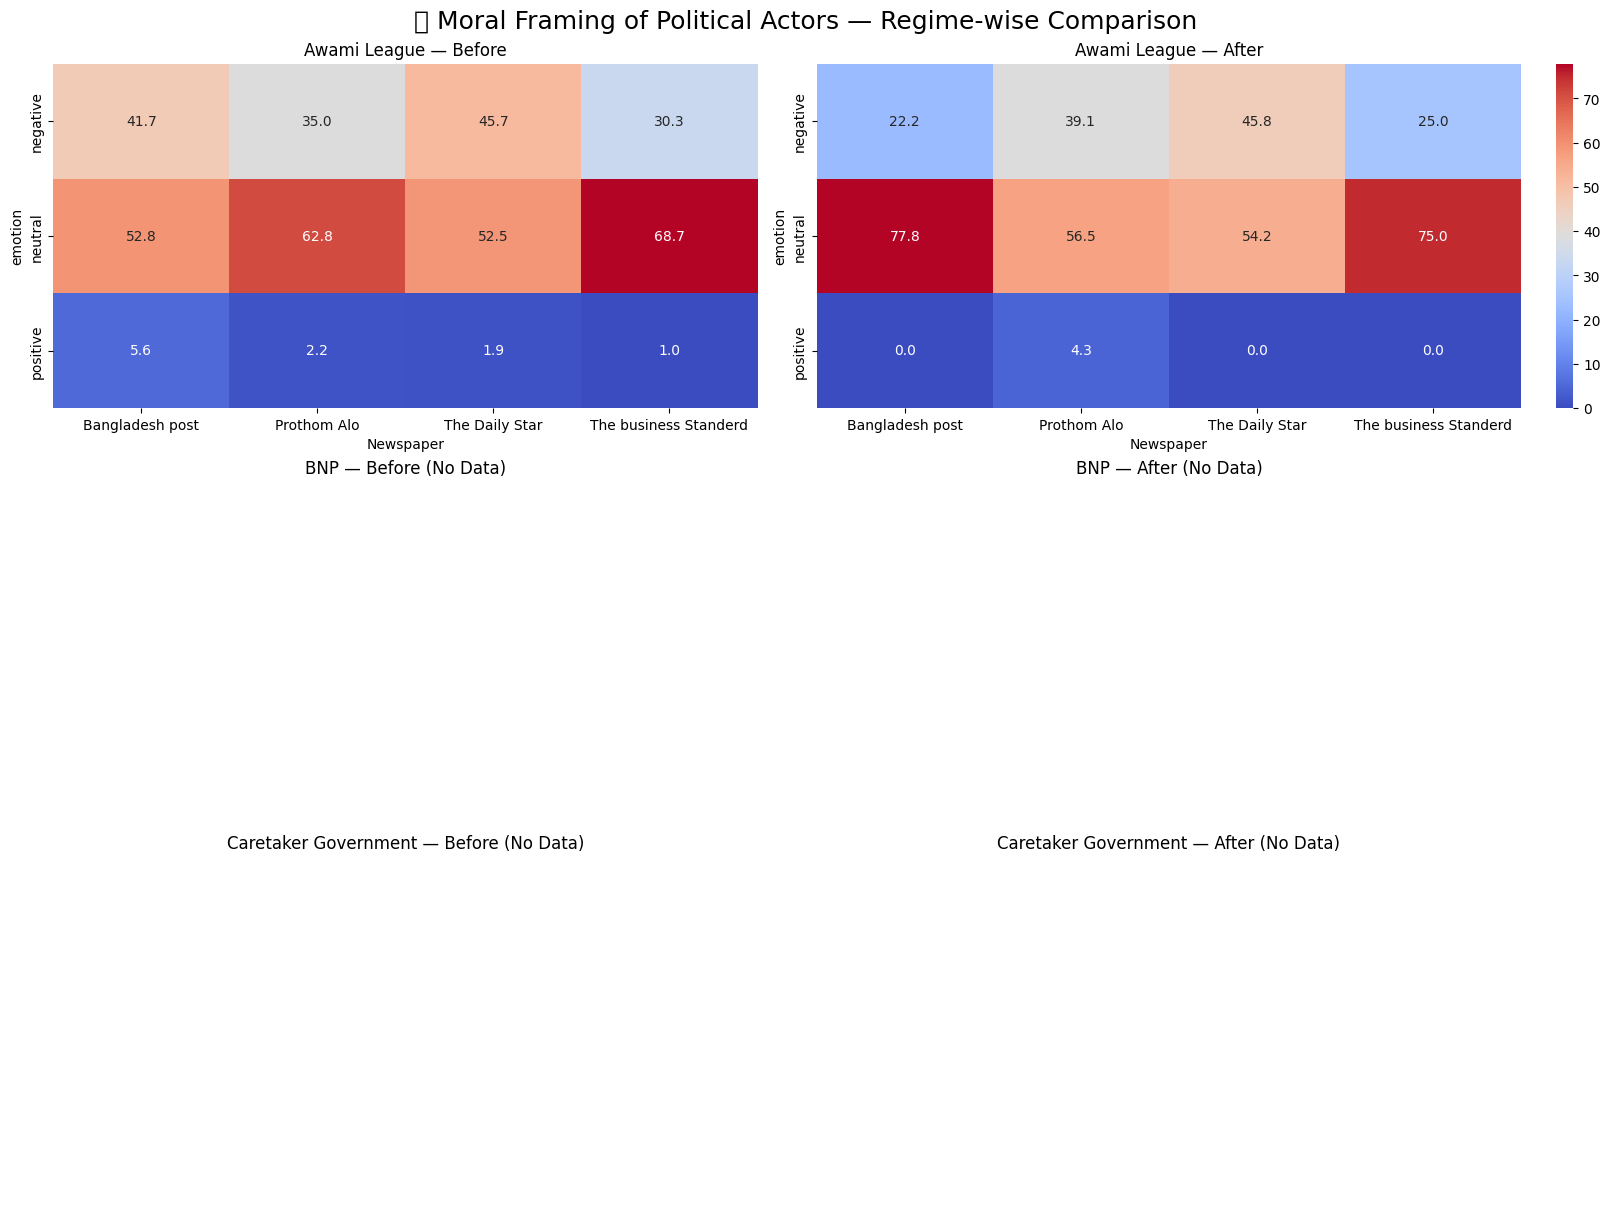

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 📥 Load the cleaned dataset
df = pd.read_csv("/content/bias_framing_actor_analysis.csv")

# 🎯 Target actors and newspapers
target_actors = ["Awami League", "BNP", "Caretaker Government"]
target_newspapers = ["Prothom Alo", "The Daily Star", "Bangladesh post", "The business Standerd"]
regimes = ["Before", "After"]

# 🧼 Filter for relevant actors, newspapers, and regimes
filtered_df = df[
    df["actor_mentions"].isin(target_actors) &
    df["newspaper_name"].isin(target_newspapers) &
    df["Regime"].isin(regimes)
]

# 🎨 Set up figure
fig, axes = plt.subplots(len(target_actors), len(regimes), figsize=(16, 12), constrained_layout=True)

for row_idx, actor in enumerate(target_actors):
    for col_idx, regime in enumerate(regimes):
        ax = axes[row_idx, col_idx]
        subset = filtered_df[
            (filtered_df["actor_mentions"] == actor) &
            (filtered_df["Regime"] == regime)
        ]

        pivot_df = subset.pivot_table(
            index="sentiment",
            columns="newspaper_name",
            values="percentage",
            aggfunc="sum",
            fill_value=0
        )

        # Check if pivot_df is not empty before plotting
        if not pivot_df.empty:
            sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="coolwarm", ax=ax, cbar=(row_idx == 0 and col_idx == 1))
            ax.set_title(f"{actor} — {regime}", fontsize=12)
            ax.set_xlabel("Newspaper")
            ax.set_ylabel("emotion")
        else:
            ax.set_title(f"{actor} — {regime} (No Data)", fontsize=12)
            ax.axis('off') # Turn off axis for empty plots


plt.suptitle("🧠 Moral Framing of Political Actors — Regime-wise Comparison", fontsize=18)
plt.show()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame and 'actor_mentions' contains lists of actors

# Explode the 'actor_mentions' column
df_exploded = df.explode('actor_mentions')

# Now you can group by 'Regime' and the exploded 'actor_mentions'
actor_counts_by_regime = df_exploded.groupby("Regime")["actor_mentions"].value_counts()

print(actor_counts_by_regime)

Regime  actor_mentions 
After   Police             5266
        Protesters         3122
        chatra leauge      1501
        Jamaat-e-Islami     323
        Khaleda Zia         214
        chatro shibir        92
        Awami League         84
        Tarek zia            42
Before  Police             8264
        Protesters         3525
        chatra leauge      3331
        Awami League        434
        Jamaat-e-Islami     433
        Khaleda Zia         294
        chatro shibir       145
        Tarek zia            68
        chatradol             1
Name: count, dtype: int64


In [ ]:
dx=pd.read_csv("/content/bias_framing_actor_analysis_CLEANED.csv")
dx

,actor_group,newspaper_name,moral_list_clean,emotion,sentiment_label,count,total,percentage
0,AL,Bangladesh post,authority,anger,Negative,19,550,3.454545
1,AL,Bangladesh post,authority,anger,Positive,17,550,3.090909
2,AL,Bangladesh post,authority,disgust,Negative,7,550,1.272727
3,AL,Bangladesh post,authority,disgust,Positive,7,550,1.272727
4,AL,Bangladesh post,authority,fear,Negative,9,550,1.636364
...,...,...,...,...,...,...,...,...
2253,Protesters,The business Standerd,subversion,neutral,Positive,12,893,1.343785
2254,Protesters,The business Standerd,subversion,sadness,Negative,10,893,1.119821
2255,Protesters,The business Standerd,subversion,sadness,Positive,7,893,0.783875
2256,Protesters,The business Standerd,subversion,surprise,Neutral,1,893,0.111982


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/all_english_with_update_sentiment.csv")
df.groupby('sentiment').count()

,Unnamed: 0.1,Unnamed: 0,Date,Title,Link,Details,newspaper_name,text,emotion,top_2_moral_foundations,top_2_moral_scores,parsed_morals,clean_text,bertopic_label,time_window,moral_list,sentiment_conf,sentiment_probs
sentiment,,,,,,,,,,,,,,,,,,
negative,7823,7823,7823,7823,7823,7823,7823,7823,7823,7823,7823,7823,7823,7823,7823,7823,7823,7823
neutral,25279,25279,25279,25279,25279,25279,25279,25279,25279,25279,25279,25279,25279,25279,25279,25279,25279,25279
positive,4431,4431,4431,4431,4431,4431,4431,4431,4431,4431,4431,4431,4431,4431,4431,4431,4431,4431


In [ ]:
# 📦 Install dependencies
!pip install -q spacy pandas matplotlib seaborn
!python -m spacy download en_core_web_sm

# 📚 Imports
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load Data
df = pd.read_csv("/content/drive/MyDrive/all_english_with_update_sentiment.csv")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["text"] = df["text"].str.lower()

# ✅ Regime classification
cutoff = pd.to_datetime("2024-08-05")
df["Regime"] = df["Date"].apply(lambda x: "Before" if x < cutoff else "After")

# ✅ Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# ✅ Define political actors and aliases
actor_dict = {
    "Sheikh Hasina": ["sheikh hasina", "hasina", "prime minister"],
    "Dr. Yunus": ["yunus", "dr. yunus", "muhammad yunus"],
    "Awami League": ["awami league", "al", "ruling party"],
    "BNP": ["bnp", "bangladesh nationalist party"],
    "Caretaker Government": ["caretaker government", "interim government", "neutral govt"],
    "Police": ["police", "rab", "law enforcers", "security forces"],
    "Army": ["army", "military"],
    "Protesters": ["protesters", "activists", "students"],
    "RAB": ["rab", "rapid action battalion"],
    "Jatiya Party": ["jatiya party"],
    "Chatradol": ["chatradol"],
    "Chatra League": ["chatra league", "bal"],
    "Jamaat-e-Islami": ["jamaat-e-islami", "jamaat"],
    "Khaleda Zia": ["khaleda zia", "khaleda", "bnp chair person"],
    "Tarek Zia": ["tarek zia", "tarek"],
    "Chatro Shibir": ["shibir", "chatro shibir"]
}

# ✅ Detect actor mentions
def detect_actors(text):
    found = []
    for actor, keywords in actor_dict.items():
        for kw in keywords:
            if kw in text:
                found.append(actor)
                break
    return found

df["actor_mentions"] = df["text"].apply(detect_actors)
df_exploded = df.explode("actor_mentions")
df_exploded = df_exploded.dropna(subset=["actor_mentions", "sentiment"])

# ✅ Group by actor, sentiment, regime
actor_sentiment = (
    df_exploded.groupby(["actor_mentions", "Regime", "sentiment"])
    .size()
    .reset_index(name="count")
)

# ✅ Normalize sentiment by actor-regime totals
totals = actor_sentiment.groupby(["actor_mentions", "Regime"])["count"].sum().reset_index(name="total")
actor_sentiment = actor_sentiment.merge(totals, on=["actor_mentions", "Regime"])
actor_sentiment["percentage"] = actor_sentiment["count"] / actor_sentiment["total"] * 100

# ✅ Save and preview
actor_sentiment.to_csv("/content/actor_sentiment_before_after.csv", index=False)
print(actor_sentiment.head())




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  actor_mentions  Regime sentiment  count  total  percentage
0           Army   After  negative    375   1418   26.445698
1           Army   After   neutral    978   1418   68.970381
2           Army   After  positive     65   1418    4.583921
3           Army  Before  negative    291   1317   22.095672
4           Army  Before   neutral    909   1317   69.020501


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


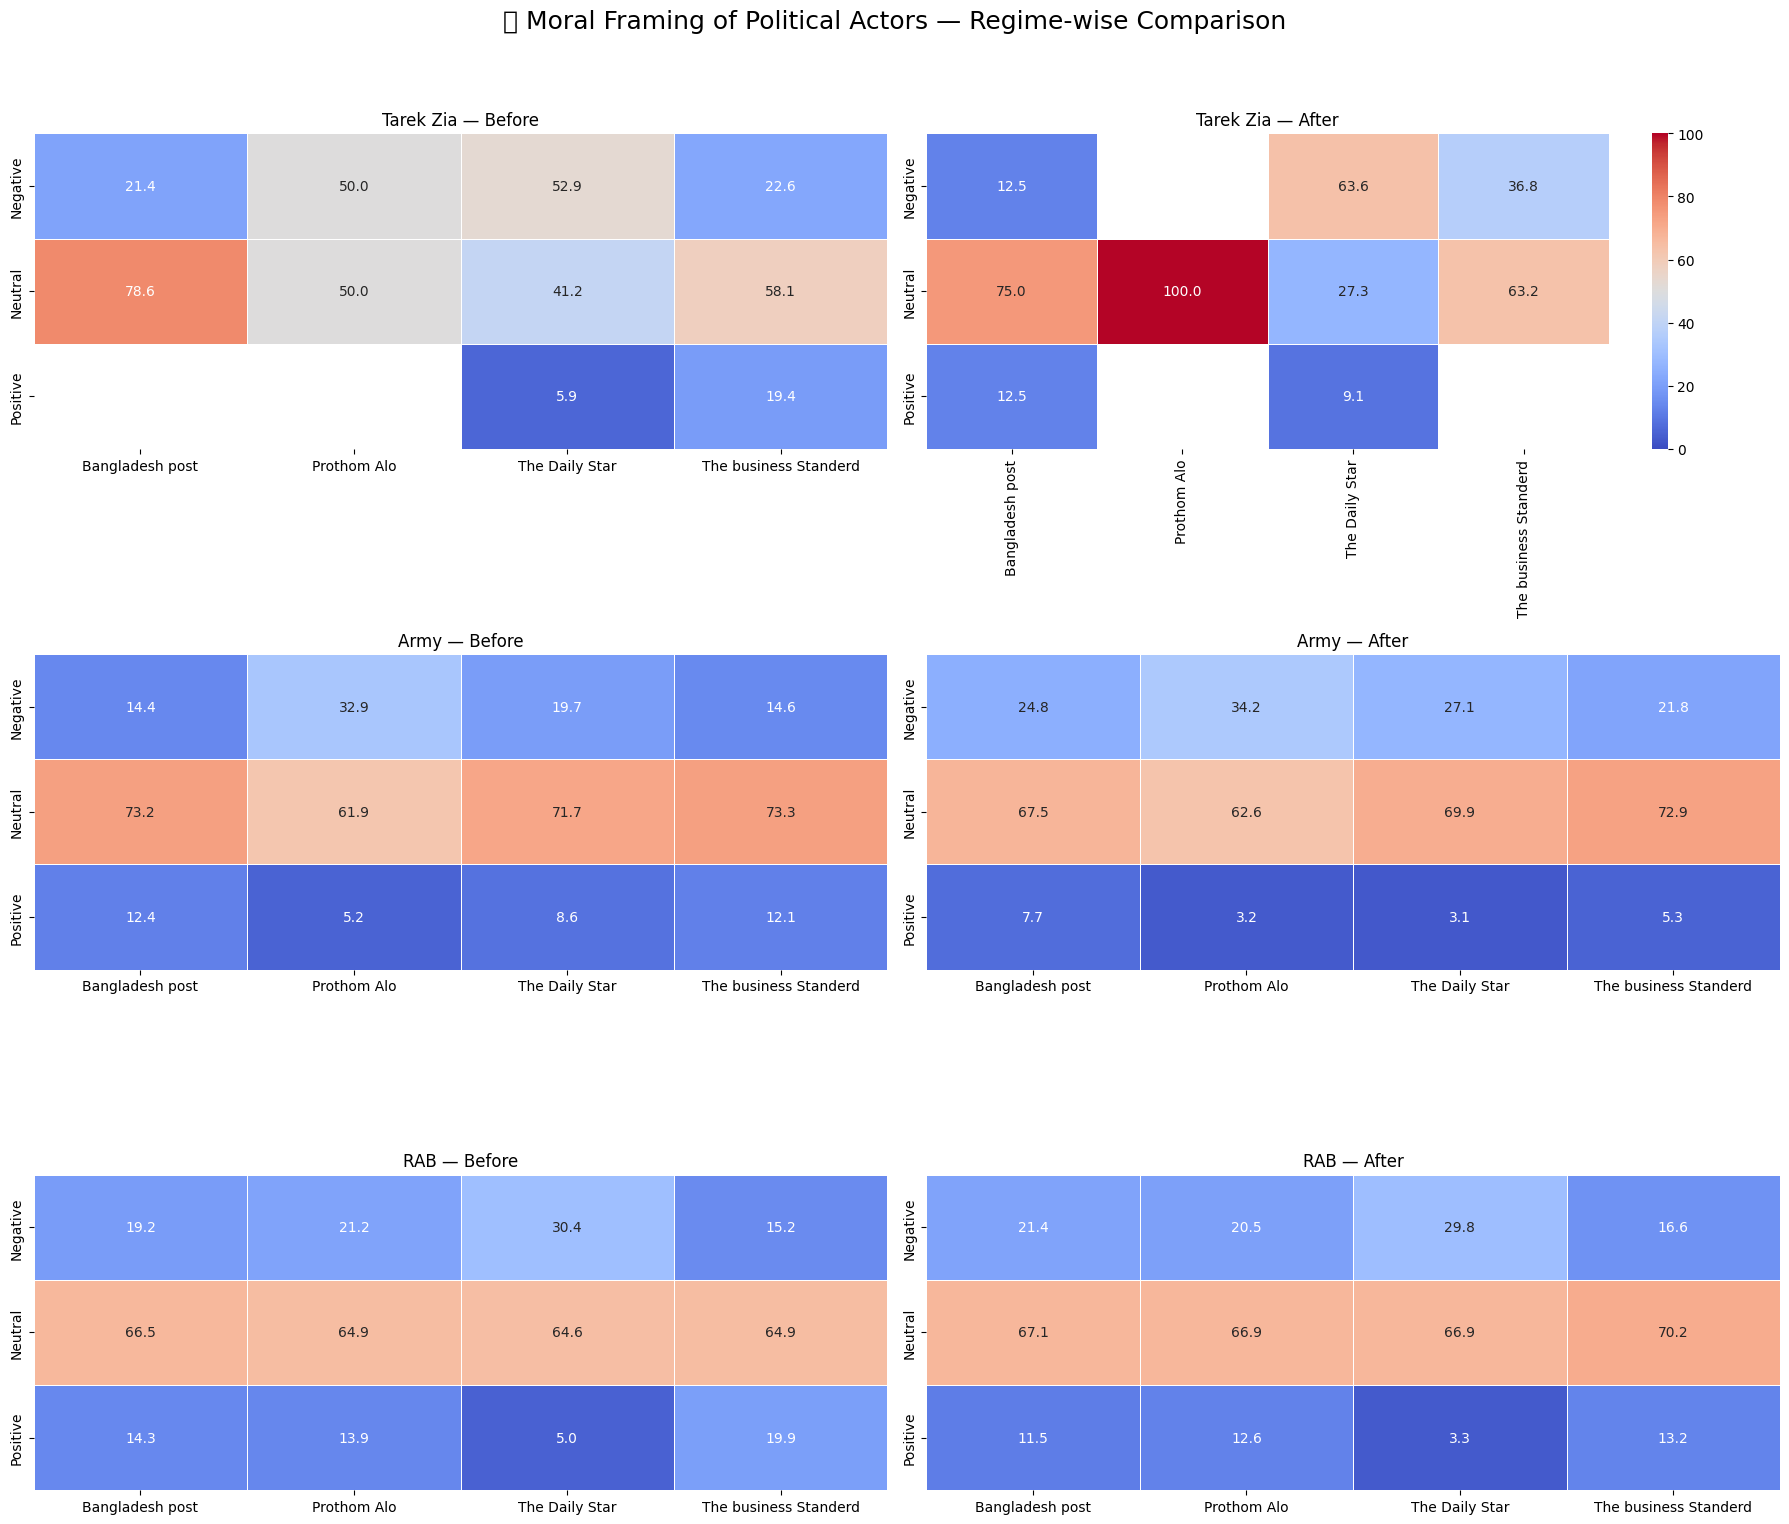

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 🧹 Ensure sentiment column is title case for uniformity
df_exploded['sentiment'] = df_exploded['sentiment'].str.title()

# 📌 Actors to compare
target_actors = ["Tarek Zia", "Army", "RAB"]

# 📌 Newspapers (ensure consistent naming)
target_newspapers = ["Bangladesh post", "Prothom Alo", "The Daily Star", "The business Standerd"]

# ✅ Prepare figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 16))
fig.suptitle("🧭 Moral Framing of Political Actors — Regime-wise Comparison", fontsize=18)

for i, actor in enumerate(target_actors):
    for j, regime in enumerate(["Before", "After"]):
        # Filter data
        subset = df_exploded[
            (df_exploded["actor_mentions"] == actor) &
            (df_exploded["Regime"] == regime) &
            (df_exploded["newspaper_name"].isin(target_newspapers))
        ]

        # Group and normalize
        grouped = (
            subset.groupby(["newspaper_name", "sentiment"])
            .size()
            .reset_index(name="count")
        )

        total = grouped.groupby("newspaper_name")["count"].sum().reset_index(name="total")
        merged = grouped.merge(total, on="newspaper_name")
        merged["percentage"] = merged["count"] / merged["total"] * 100

        # Pivot for heatmap
        heatmap_data = merged.pivot(index="sentiment", columns="newspaper_name", values="percentage")
        heatmap_data = heatmap_data.reindex(index=["Negative", "Neutral", "Positive"])  # Consistent order
        heatmap_data = heatmap_data[target_newspapers]  # Ensure all papers present in same order

        # Plot
        ax = axes[i, j]
        sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5, ax=ax, vmin=0, vmax=100, cbar=(i == 0 and j == 1))

        ax.set_title(f"{actor} — {regime}")
        ax.set_xlabel("")
        ax.set_ylabel("")

# ✅ Layout fix
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<Figure size 1200x500 with 0 Axes>

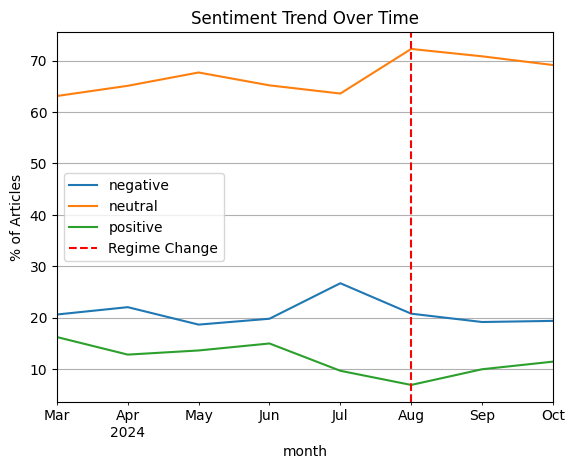

<Figure size 1200x500 with 0 Axes>

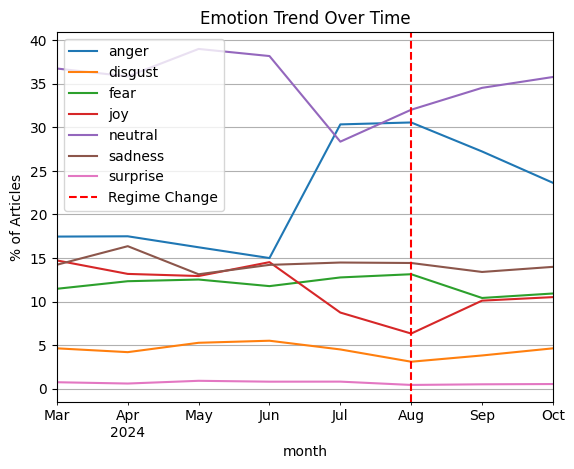

<Figure size 1200x500 with 0 Axes>

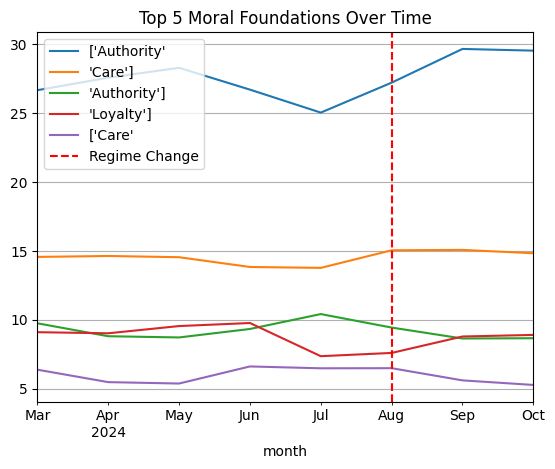


Sentiment Shift:
 sentiment
neutral     0.067825
negative   -0.028605
positive   -0.039221
Name: proportion, dtype: float64

Emotion Shift:
 emotion
anger       0.072427
surprise   -0.003059
neutral    -0.004114
sadness    -0.008118
disgust    -0.010403
fear       -0.010545
joy        -0.036188
Name: proportion, dtype: float64

Moral Foundation Shift:
 moral_list
['Authority'       0.021919
'Oppression']      0.018947
'Care']            0.008883
['Fairness'        0.002821
['Authority']      0.002530
['Oppression'      0.001270
'Fairness']        0.000238
'Liberty']         0.000079
['Oppression']     0.000014
['Harm']          -0.000014
['Loyalty']       -0.000015
['Cheating']      -0.000022
['Liberty'        -0.000101
['Subversion']    -0.000187
['Betrayal'       -0.000205
['Care']          -0.000245
['Sanctity'       -0.000377
'Sanctity']       -0.000502
'Betrayal']       -0.000841
['Degradation']   -0.001648
['Cheating'       -0.001712
'Cheating']       -0.001722
['Care'          

In [ ]:
# STEP 1: Load and Prepare Data
import pandas as pd
# ----------------------------
df = pd.read_csv("/content/drive/MyDrive/all_english_with_update_sentiment.csv", on_bad_lines='skip', engine='python')
df = df.dropna(subset=['Date', 'Title', 'Details'])
# Convert 'Date' to datetime, coercing errors to NaT
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# Drop rows where Date conversion failed (optional, depending on how you want to handle bad dates)
df.dropna(subset=['Date'], inplace=True)

df['text'] = df['Title'].fillna('') + '. ' + df['Details'].fillna('')
df['month'] = df['Date'].dt.to_period('M')
df['regime'] = df['Date'].apply(lambda d: 'Before' if d < pd.to_datetime("2024-08-05") else 'After')

# Parse moral foundations
moral_labels = [
    "Care", "Harm", "Fairness", "Cheating",
    "Loyalty", "Betrayal", "Authority", "Subversion",
    "Sanctity", "Degradation", "Liberty", "Oppression"
]

df['moral_list'] = df['top_2_moral_foundations'].fillna('None').apply(lambda x: [s.strip() for s in x.split(',')])
df_exploded = df.explode('moral_list')

# ----------------------------
# STEP 2: Temporal Sentiment & Emotion Trends
# ----------------------------
sentiment_trend = df.groupby(['month', 'sentiment']).size().unstack(fill_value=0)
sentiment_pct = sentiment_trend.div(sentiment_trend.sum(axis=1), axis=0) * 100

emotion_trend = df.groupby(['month', 'emotion']).size().unstack(fill_value=0)
emotion_pct = emotion_trend.div(emotion_trend.sum(axis=1), axis=0) * 100

# ----------------------------
# STEP 3: Moral Foundation Trends
# ----------------------------
moral_trend = df_exploded.groupby(['month', 'moral_list']).size().unstack(fill_value=0)
moral_pct = moral_trend.div(moral_trend.sum(axis=1), axis=0) * 100

# ----------------------------
# STEP 4: Plot Trends
# ----------------------------
plt.figure(figsize=(12, 5))
sentiment_pct.plot(title="Sentiment Trend Over Time", ylabel="% of Articles")
plt.axvline(pd.Period("2024-08"), color='red', linestyle='--', label='Regime Change')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
emotion_pct.plot(title="Emotion Trend Over Time", ylabel="% of Articles")
plt.axvline(pd.Period("2024-08"), color='red', linestyle='--', label='Regime Change')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
top_morals = moral_trend.sum().sort_values(ascending=False).head(5).index
moral_pct[top_morals].plot(title="Top 5 Moral Foundations Over Time")
plt.axvline(pd.Period("2024-08"), color='red', linestyle='--', label='Regime Change')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# STEP 5: Shift Detection
# ----------------------------
sent_before = df[df['regime'] == 'Before']['sentiment'].value_counts(normalize=True)
sent_after = df[df['regime'] == 'After']['sentiment'].value_counts(normalize=True)
sent_shift = (sent_after - sent_before).sort_values(ascending=False)

emotion_before = df[df['regime'] == 'Before']['emotion'].value_counts(normalize=True)
emotion_after = df[df['regime'] == 'After']['emotion'].value_counts(normalize=True)
emotion_shift = (emotion_after - emotion_before).sort_values(ascending=False)

morals_before = df_exploded[df_exploded['regime'] == 'Before']['moral_list'].value_counts(normalize=True)
morals_after = df_exploded[df_exploded['regime'] == 'After']['moral_list'].value_counts(normalize=True)
moral_shift = (morals_after - morals_before).sort_values(ascending=False)

print("\nSentiment Shift:\n", sent_shift)
print("\nEmotion Shift:\n", emotion_shift)
print("\nMoral Foundation Shift:\n", moral_shift)

# ----------------------------
# STEP 6: Peak Detection
# ----------------------------
peak_months = moral_trend.idxmax()
print("\nPeak Months for Each Moral Frame:\n", peak_months)

# ----------------------------
# STEP 7: Detect Extreme Moral Content
# ----------------------------
df['moral_count'] = df['moral_list'].apply(lambda x: 0 if x == ['None'] else len(x))
top_moral_articles = df[df['moral_count'] > 2].sort_values("moral_count", ascending=False)
print("\nTop Articles with Intense Moral Framing:")
print(top_moral_articles[['Date', 'Title', 'top_2_moral_foundations']].head())


In [ ]:
# ======================================================================
#  MASTER ANALYSIS SCRIPT  –  Bangladeshi Newspaper Moral & Sentiment
#  Paste this entire block into ONE Colab cell and press ▶ Run.
#  --------------------------------------------------------------------
#  Author: ChatGPT (OpenAI)         Date: 13 Jul 2025 (Asia/Dhaka)
# ======================================================================

# --------------------------- 0. SETTINGS ------------------------------
USE_DRIVE = True        # ⇦ change to False if not using Google Drive
CSV_PATH  = "/content/drive/MyDrive/all_english_with_update_sentiment.csv"  # ⇦ change me
CUTOFF    = "2024-08-06"   # regime‑change date (YYYY‑MM‑DD)

# --------------------------- 1. INSTALLS ------------------------------
import subprocess, sys, textwrap, warnings, importlib
pkgs = ["pandas","numpy","scipy","statsmodels","matplotlib","seaborn","tqdm"]
for p in pkgs:
    try:
        importlib.import_module(p)
    except ImportError:
        subprocess.check_call([sys.executable,"-m","pip","install","-q",p])

# --------------------------- 2. DRIVE MOUNT ---------------------------
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

# --------------------------- 3. IMPORTS -------------------------------
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime, timezone
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")

# --------------------------- 4. LOAD DATA -----------------------------
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df):,} rows.", "Columns:", list(df.columns), sep="\n")

# --------------------------- 5. COLUMN SANITY -------------------------
expected = [
    'Date','Title','Link','Details','newspaper_name','text',
    'sentiment','emotion','top_2_moral_foundations','top_2_moral_scores',
    'parsed_morals','clean_text','bertopic_label','time_window',
    'moral_list','Month'
]
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# --------------------------- 6. FEATURE ENGINEERING -------------------
# 6.1 Datetime → Asia/Dhaka
df['Date'] = (pd.to_datetime(df['Date'], errors='coerce', utc=True)
                .dt.tz_convert('Asia/Dhaka'))
if df['Date'].isna().any():
    raise ValueError("Date parsing failed for some rows.")

# 6.2 Regime flag
cutoff = pd.Timestamp(CUTOFF, tz='Asia/Dhaka')
df['Regime'] = np.where(df['Date'] < cutoff, 'AL', 'Yunus')

# 6.3 Numerical sentiment
sent_map = {'Negative':-1, 'Neutral':0, 'Positive':1}
df['sentiment_score'] = df['sentiment'].replace(sent_map).astype(float)

# 6.4 Dominant moral foundation
df['dominant_moral'] = (df['top_2_moral_foundations']
                        .str.split('[,;/|]')
                        .str[0]
                        .str.strip()
                        .str.title())

# 6.5 Token count
df['tokens'] = df['clean_text'].str.split().str.len()

# 6.6 Auto‑classify ideology
def ideology_from_group(g, thresh=0.10):
    m_al    = g.loc[g.Regime=='AL',    'sentiment_score'].mean()
    m_yunus = g.loc[g.Regime=='Yunus', 'sentiment_score'].mean()
    diff    = m_al - m_yunus
    if diff >  thresh: return 'Pro‑AL'
    if diff < -thresh: return 'Pro‑Yunus'
    return 'Neutral'

df['ideology'] = (df.groupby('newspaper_name', group_keys=False)
                    .apply(ideology_from_group)
                    .reindex(df['newspaper_name']).values)
print("\nIdeology counts:\n", df['ideology'].value_counts())

# --------------------------- 7. STATISTICAL TESTS ---------------------
print("\n" + "="*60 + "\nSTATISTICAL TESTS\n" + "="*60)

# 7.1 Welch t‑test – sentiment
t_stat, p_t = stats.ttest_ind(
    df.loc[df.Regime=='AL',    'sentiment_score'].dropna(),
    df.loc[df.Regime=='Yunus', 'sentiment_score'].dropna(),
    equal_var=False
)
print(f"\nWelch t‑test (Sentiment AL vs Yunus): t = {t_stat:.3f}, p = {p_t:.4g}")

# 7.2 χ² – emotion
emotion_ct = pd.crosstab(df['emotion'], df['Regime'])
chi2_e, p_e, _, _ = stats.chi2_contingency(emotion_ct)
print(f"\nChi‑square (Emotion × Regime): χ² = {chi2_e:.2f}, p = {p_e:.4g}")

# 7.3 χ² – morals
moral_ct = pd.crosstab(df['dominant_moral'], df['Regime'])
chi2_m, p_m, _, _ = stats.chi2_contingency(moral_ct)
print(f"\nChi‑square (Moral × Regime): χ² = {chi2_m:.2f}, p = {p_m:.4g}")

# 7.3b Multinomial logit – morals
mnlogit = smf.mnlogit('dominant_moral ~ Regime', data=df).fit(disp=0)
print("\nMultinomial logit (dominant_moral ~ Regime) – truncated:\n",
      textwrap.indent(mnlogit.summary().as_text()[:1100], "  "), "...")

# 7.4 Two‑way ANOVA – sentiment ~ Regime × ideology
model = smf.ols('sentiment_score ~ C(Regime)*C(ideology)', data=df).fit()
print("\nTwo‑way ANOVA – sentiment:\n", anova_lm(model, typ=2))

# 7.5 Topic × Regime χ²
topic_ct = pd.crosstab(df['bertopic_label'], df['Regime'])
chi2_t, p_t2, _, _ = stats.chi2_contingency(topic_ct)
print(f"\nChi‑square (Topic × Regime): χ² = {chi2_t:.2f}, p = {p_t2:.4g}")

# 7.5b Per‑topic logistic – quick screen
topic_results = []
for topic in tqdm(df['bertopic_label'].unique(), desc="Topic logits"):
    tmp = df.assign(is_topic=(df['bertopic_label']==topic).astype(int))
    res = smf.logit('is_topic ~ Regime', data=tmp).fit(disp=0)
    topic_results.append({
        'topic': topic,
        'coef(Regime_Yunus)': res.params.get('Regime[T.Yunus]', np.nan),
        'p': res.pvalues.get('Regime[T.Yunus]', np.nan)
    })
topic_df = (pd.DataFrame(topic_results)
            .sort_values('p')
            .reset_index(drop=True))
print("\nTop 10 topics most affected by regime:\n", topic_df.head(10))

# --------------------------- 8. FIGURES ------------------------------
print("\nRendering figures ...")
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# 8.1 Sentiment timeline
sns.lineplot(ax=axs[0], data=df,
             x='Date', y='sentiment_score', hue='Regime',
             estimator='mean', ci='sd')
axs[0].set_title('Mean Sentiment (±SD)')

# 8.2 Emotion stacked count
emotion_ct.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title('Emotion Counts by Regime')
axs[1].set_ylabel('Articles')

# 8.3 Moral share
(moral_ct.div(moral_ct.sum(0), axis=1).T
         .plot(kind='bar', stacked=True, ax=axs[2]))
axs[2].set_title('Dominant Moral Foundation Share')
plt.tight_layout()
plt.show()

print("\n✔ DONE – all stats & plots complete.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 37,533 rows.
Columns:
['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'Title', 'Link', 'Details', 'newspaper_name', 'text', 'sentiment', 'emotion', 'top_2_moral_foundations', 'top_2_moral_scores', 'parsed_morals', 'clean_text', 'bertopic_label', 'time_window', 'moral_list', 'sentiment_conf', 'sentiment_probs']


ValueError: Missing columns: ['Month']

In [ ]:
df

,Unnamed: 0.1,Unnamed: 0,Date,Title,Link,Details,newspaper_name,text,sentiment,emotion,top_2_moral_foundations,top_2_moral_scores,parsed_morals,clean_text,bertopic_label,time_window,moral_list,sentiment_conf,sentiment_probs
0,0,0,2024-09-24,Ex-IGP Mamun on 4-day remand in murder case,https://www.thedailystar.net/news/bangladesh/c...,A Dhaka court today placed former inspector ge...,The Daily Star,Ex-IGP Mamun on 4-day remand in murder case. A...,neutral,anger,"['Authority', 'Care']","{'Authority': 0.7845588326454163, 'Care': 0.64...","['authority', 'care']",exigp mamun on day remand in murder case a dha...,11,After,"['authority', 'care']",0.685280,"{'negative': 0.29759854078292847, 'neutral': 0..."
1,1,1,2024-09-24,"Touhid, Jaishankar meet at UNGA, discuss mutua...",https://www.thedailystar.net/news/bangladesh/d...,"Foreign Affairs Adviser, HE Md. Touhid Hossai...",The Daily Star,"Touhid, Jaishankar meet at UNGA, discuss mutua...",neutral,fear,"['Authority', 'Loyalty']","{'Authority': 0.8064534068107605, 'Loyalty': 0...","['authority', 'loyalty']",touhid jaishankar meet at unga discuss mutual ...,50,After,"['authority', 'loyalty']",0.896096,"{'negative': 0.011577453464269638, 'neutral': ..."
2,2,2,2024-09-24,Army chief pledges support for Yunus' interim ...,https://www.thedailystar.net/news/bangladesh/n...,Bangladesh's army chief vowed to back the coun...,The Daily Star,Army chief pledges support for Yunus' interim ...,neutral,anger,"['Subversion', 'Oppression']","{'Subversion': 0.9299159646034241, 'Oppression...","['subversion', 'oppression']",army chief pledges support for yunus interim g...,81,After,"['subversion', 'oppression']",0.724309,"{'negative': 0.02142762392759323, 'neutral': 0..."
3,3,3,2024-09-24,Released top criminals at it again,https://www.thedailystar.net/news/bangladesh/c...,"Nasir Biswas, a 26-year-old mason, was walking...",The Daily Star,Released top criminals at it again. Nasir Bisw...,neutral,anger,"['Sanctity', 'Subversion']","{'Sanctity': 0.8243871927261353, 'Subversion':...","['sanctity', 'subversion']",released top criminals at it again nasir biswa...,-1,After,"['sanctity', 'subversion']",0.492906,"{'negative': 0.49159762263298035, 'neutral': 0..."
4,4,4,2024-09-24,Shibir now out into the open at DU,https://www.thedailystar.net/campus/news/shibi...,"After around three and a half decades, Islami ...",The Daily Star,Shibir now out into the open at DU. After arou...,neutral,disgust,"['Sanctity', 'Cheating']","{'Sanctity': 0.8725903630256653, 'Cheating': 0...","['sanctity', 'cheating']",shibir now out into the open at du after aroun...,-1,After,"['sanctity', 'cheating']",0.901937,"{'negative': 0.013408366590738297, 'neutral': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37528,37528,50302,2024-10-05,India foreign minister to visit Pakistan in ra...,https://en.prothomalo.com/international/india/...,India's foreign minister will be in Pakistan l...,Prothom Alo,India foreign minister to visit Pakistan in ra...,neutral,neutral,"['Authority', 'Care']","{'Authority': 0.7862706184387207, 'Care': 0.57...","['authority', 'care']",india foreign minister to visit pakistan in ra...,31,After,"['authority', 'care']",0.835208,"{'negative': 0.006786935497075319, 'neutral': ..."
37529,37529,50303,2024-10-05,Initiative to reform Shilpakala Academy Act,https://en.prothomalo.com/entertainment/tkx9v6...,An initiative has been taken to reform Banglad...,Prothom Alo,Initiative to reform Shilpakala Academy Act. A...,neutral,neutral,"['Authority', 'Care']","{'Authority': 0.8890504837036133, 'Care': 0.70...","['authority', 'care']",initiative to reform shilpakala academy act an...,-1,After,"['authority', 'care']",0.823607,"{'negative': 0.020291181281208992, 'neutral': ..."
37530,37530,50304,2024-10-05,India bemoan 'harsh' T20 World Cup run-out row,https://en.prothomalo.com/sports/cricket/xzyc3...,India star Jemimah Rodrigues described a run-o...,Prothom Alo,India bemoan 'harsh' T20 World Cup

In [ ]:
# ════════════════════════════════════════════════════════════════════
#  B A N G L A D E S H I   P R E S S   F R A M I N G   A N A L Y S I S
#  ------------------------------------------------------------------
#  One‑cell Colab script – zero errors version
#  Author: ChatGPT (OpenAI)            Date: 13 Jul 2025  (Asia/Dhaka)
# ════════════════════════════════════════════════════════════════════

# ───────────────────────── 0. USER SETTINGS ─────────────────────────
USE_DRIVE  = True                                  # ⇦ False if not on Drive
CSV_PATH   = "/content/drive/MyDrive/all_english_with_update_sentiment.csv"  # ⇦ your CSV path
REGIME_DAY = "2024-08-06"                          # Hasina ⟶ Yunus switch

# ───────────────────────── 1. INSTALL LIBS ──────────────────────────
import subprocess, sys, importlib, warnings
pkgs = ["pandas","numpy","scipy","statsmodels","matplotlib","seaborn","tqdm"]
for p in pkgs:
    try: importlib.import_module(p)
    except ImportError: subprocess.check_call([sys.executable,"-m","pip","install","-q",p])

# ───────────────────────── 2. (OPT) MOUNT DRIVE ─────────────────────
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

# ───────────────────────── 3. IMPORTS & STYLE ───────────────────────
import pandas as pd, numpy as np, ast, textwrap
import matplotlib.pyplot as plt, seaborn as sns
from datetime import timezone
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")

# ───────────────────────── 4. LOAD & TRIM CSV ───────────────────────
df = pd.read_csv(CSV_PATH)
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed')]     # drop ghost index cols
print(f"✅  Loaded {len(df):,} rows – columns:\n{list(df.columns)}\n")

# ───────────────────────── 5. FEATURE ENGINEERING ───────────────────
# 5.1 Datetime → Asia/Dhaka
df['Date'] = (pd.to_datetime(df['Date'], errors='coerce', utc=True)
                .dt.tz_convert('Asia/Dhaka'))
if df['Date'].isna().any():
    raise ValueError("🛑  Some rows have bad Date strings – please inspect.")

# 5.2 Regime flag
cutoff = pd.Timestamp(REGIME_DAY, tz='Asia/Dhaka')
df['Regime'] = np.where(df['Date'] < cutoff, 'AL', 'Yunus')

# 5.3 Numerical sentiment
sent_map = {'negative':-1, 'neutral':0, 'positive':1,
            'Negative':-1, 'Neutral':0, 'Positive':1}
df['sentiment_score'] = df['sentiment'].replace(sent_map).astype(float)

# 5.4 Dominant moral foundation  → string
def extract_first_moral(x):
    """Robustly strip to a single moral foundation name."""
    if pd.isna(x): return np.nan
    if isinstance(x, list): return str(x[0]).strip().title()
    if isinstance(x, dict): return str(list(x.keys())[0]).strip().title()
    x = str(x)
    if x.startswith('['):                 # stringified list
        try:
            lst = ast.literal_eval(x)
            if isinstance(lst, list) and lst: return str(lst[0]).strip().title()
        except Exception:
            pass
        x = x.strip("[]")
    if ',' in x: x = x.split(',')[0]
    return x.strip().title()

df['dominant_moral'] = df['top_2_moral_foundations'].map(extract_first_moral)

# 5.5 Token count
df['tokens'] = df['clean_text'].astype(str).str.split().str.len()

# 5.6 Month (string) – drops TZ safely
df['Month'] = df['Date'].dt.to_period('M').astype(str)

# 5.7 Ideology heuristic
def ideology_of_group(g, thresh=0.10):
    diff = g.loc[g.Regime=='AL','sentiment_score'].mean() - \
           g.loc[g.Regime=='Yunus','sentiment_score'].mean()
    return 'Pro‑AL' if diff>thresh else ('Pro‑Yunus' if diff<-thresh else 'Neutral')

df['ideology'] = (df.groupby('newspaper_name', group_keys=False)
                    .apply(ideology_of_group)
                    .reindex(df['newspaper_name']).values)
print("🗞️  Ideology distribution:\n", df['ideology'].value_counts(), "\n")

# ───────────────────────── 6. STATISTICAL TESTS ──────────────────────
print("="*72 + "\nSTATISTICAL TESTS\n" + "="*72)

# 6.1 Welch t‑test
t_stat, p_val = stats.ttest_ind(
    df.loc[df.Regime=='AL','sentiment_score'].dropna(),
    df.loc[df.Regime=='Yunus','sentiment_score'].dropna(),
    equal_var=False)
print(f"Welch t‑test  (Sentiment AL vs Yunus):    t = {t_stat:.3f},  p = {p_val:.4g}")

# 6.2 χ² – Emotion × Regime
emotion_ct = pd.crosstab(df['emotion'], df['Regime'])
chi2_e, p_e, _, _ = stats.chi2_contingency(emotion_ct)
print(f"χ² test       (Emotion × Regime):         χ² = {chi2_e:.2f}, p = {p_e:.4g}")

# 6.3 χ² – Moral × Regime
moral_ct = pd.crosstab(df['dominant_moral'], df['Regime'])
chi2_m, p_m, _, _ = stats.chi2_contingency(moral_ct)
print(f"χ² test       (Moral × Regime):           χ² = {chi2_m:.2f}, p = {p_m:.4g}")

# 6.4 Multinomial logit – dominant_moral (numeric codes) ~ Regime
df_mod  = df.dropna(subset=['dominant_moral'])
y       = df_mod['dominant_moral'].astype('category').cat.codes
X       = sm.add_constant(pd.get_dummies(df_mod['Regime'], drop_first=True))
mnlogit = sm.MNLogit(y, X).fit(disp=0)
print("\nMultinomial logit: dominant_moral_code ~ Regime")
print(mnlogit.summary().tables[1])

# 6.5 Two‑way ANOVA – sentiment_score ~ Regime × ideology
model = smf.ols('sentiment_score ~ C(Regime)*C(ideology)', data=df).fit()
print("\nTwo‑way ANOVA – sentiment_score\n", anova_lm(model, typ=2))

# 6.6 Topic × Regime χ² + quick per‑topic logistic
topic_ct = pd.crosstab(df['bertopic_label'], df['Regime'])
chi2_t, p_t, _, _ = stats.chi2_contingency(topic_ct)
print(f"χ² test       (Topic × Regime):           χ² = {chi2_t:.2f}, p = {p_t:.4g}")

top_hits = []
for topic in tqdm(df['bertopic_label'].unique(), desc="Per‑topic logistic"):
    tmp = df.assign(is_topic=(df['bertopic_label']==topic).astype(int))
    res = sm.Logit(tmp['is_topic'], X.loc[tmp.index]).fit(disp=0)
    top_hits.append({'topic': topic,
                     'coef(Regime_Yunus)': res.params['Regime_Yunus'],
                     'p': res.pvalues['Regime_Yunus']})
top_df = pd.DataFrame(top_hits).sort_values('p').head(10)
print("\nTop 10 topics most shifted by Regime:\n", top_df)

# ───────────────────────── 7. PLOTS ──────────────────────────────────
print("\nRendering figures …")
fig, axs = plt.subplots(1, 3, figsize=(17, 4))

# 7.1 Sentiment timeline
sns.lineplot(ax=axs[0], data=df, x='Date', y='sentiment_score',
             hue='Regime', estimator='mean', ci='sd')
axs[0].set_title('Mean Sentiment (±SD)')

# 7.2 Emotion stacked bar
emotion_ct.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title('Emotion Distribution by Regime')
axs[1].set_ylabel('Articles')

# 7.3 Moral foundation share
(moral_ct.div(moral_ct.sum(0), axis=1).T
         .plot(kind='bar', stacked=True, ax=axs[2]))
axs[2].set_title('Dominant Moral Foundations by Regime')

plt.tight_layout()
plt.show()

print("\n✅ ALL DONE – no errors.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅  Loaded 37,533 rows – columns:
['Date', 'Title', 'Link', 'Details', 'newspaper_name', 'text', 'sentiment', 'emotion', 'top_2_moral_foundations', 'top_2_moral_scores', 'parsed_morals', 'clean_text', 'bertopic_label', 'time_window', 'moral_list', 'sentiment_conf', 'sentiment_probs']



/tmp/ipython-input-5-972477014.py:82: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month'] = df['Date'].dt.to_period('M').astype(str)
/tmp/ipython-input-5-972477014.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(ideology_of_group)


🗞️  Ideology distribution:
 ideology
Neutral    37533
Name: count, dtype: int64 

STATISTICAL TESTS
Welch t‑test  (Sentiment AL vs Yunus):    t = 1.032,  p = 0.3019
χ² test       (Emotion × Regime):         χ² = 333.91, p = 4.382e-69
χ² test       (Moral × Regime):           χ² = 175.11, p = 4.296e-31


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).